In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import seaborn as sns

from matplotlib.colors import LogNorm, Normalize
import astropy.units as u
from astropy.cosmology import Planck18, z_at_value
import pycbc.conversions as conv
from scipy.interpolate import CubicSpline
import scipy.integrate as integrate
import scipy.interpolate as interpolate


from matplotlib.ticker import AutoMinorLocator, LogLocator
from matplotlib import ticker as mticker


from astropy.cosmology import Planck18 as cosmology


In [2]:
import matplotlib as mpl

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 18
})


%config InlineBackend.figure_format='retina' # very useful command for high-res images

In [3]:
# takes ~ 2 min
files = glob.glob1('powerlaw_smooth_hybrid_3G_production/', '*')
print(files)

df = pd.DataFrame()
for fi in files:
    df_temp = pd.read_csv('powerlaw_smooth_hybrid_3G_production/'+fi)
    df = pd.concat([df,df_temp])
# drop the zero rows that resulted from NoneType Networks
df = df.loc[~(df==0).all(axis=1)]

print(len(df[(df["hybr"]==0.0)]))

['hybr_0.0_0_20000.csv', 'hybr_0.0_20000_40000.csv', 'hybr_0.0_60000_80000.csv', 'hybr_0.0_40000_60000.csv', 'hybr_0.0_80000_100000.csv']
97191


In [4]:
df.columns

Index(['index', 'Mc', 'eta', 'chi1x', 'chi2x', 'chi1y', 'chi2y', 'chi1z',
       'chi2z', 'DL', 'tc', 'phic', 'iota', 'ra', 'dec', 'psi', 'gmst0',
       'hybr', 'Mc_err', 'eta_err', 'chi1z_err', 'chi2z_err', 'DL_err',
       'tc_err', 'phic_err', 'iota_err', 'ra_err', 'dec_err', 'psi_err',
       'Mc_bias', 'eta_bias', 'chi1z_bias', 'chi2z_bias', 'DL_bias', 'tc_bias',
       'phic_bias', 'iota_bias', 'ra_bias', 'dec_bias', 'psi_bias', 'snr',
       'faith', 'inner_prod', 'z', 'z_err', 'z_bias', 'm1_src', 'm2_src',
       'm1_src_err', 'm2_src_err', 'm1_src_bias', 'm2_src_bias', 'm1_det',
       'm2_det', 'm1_det_err', 'm2_det_err', 'm1_det_bias', 'm2_det_bias', 'q',
       'q_err', 'q_bias'],
      dtype='object')

In [5]:
df

,index,Mc,eta,chi1x,chi2x,chi1y,chi2y,chi1z,chi2z,DL,...,m2_src_bias,m1_det,m2_det,m1_det_err,m2_det_err,m1_det_bias,m2_det_bias,q,q_err,q_bias
0,0,18.298679,0.236284,0.0,0.0,0.0,0.0,-0.482613,0.270886,41193.336675,...,0.311878,26.836575,16.650439,21.528315,1.110722,-2.579334,1.630270,0.620438,0.068323,0.133180
1,1,52.679891,0.244827,0.0,0.0,0.0,0.0,-0.180888,0.143514,137088.571572,...,-0.275947,70.092217,52.462408,142.921442,1.653561,5.892369,-3.946155,0.748477,0.029563,-0.109976
2,2,23.032595,0.244628,0.0,0.0,0.0,0.0,-0.002122,-0.296966,28010.846657,...,0.315615,30.733837,22.875349,28.341257,1.939626,-1.766887,1.317287,0.744305,0.096846,0.090876
3,3,14.302577,0.249535,0.0,0.0,0.0,0.0,0.151719,0.119241,17283.346042,...,0.071425,17.157263,15.738176,25.656113,1.747047,-0.366144,0.336445,0.917289,0.126806,0.040039
4,4,14.430436,0.229965,0.0,0.0,0.0,0.0,0.174159,-0.083464,10629.700422,...,-0.164179,22.361928,12.494453,12.517292,1.818876,0.855814,-0.409000,0.558738,0.155113,-0.038211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17186,99995,35.735800,0.249773,0.0,0.0,0.0,0.0,0.028379,0.050928,45156.842233,...,-0.710298,42.308963,39.835058,62.871092,2.465331,5.094606,-4.189794,0.941528,0.072955,-0.189574
17187,99996,24.258988,0.248576,0.0,0.0,0.0,0.0,-0.274842,0.127368,30482.819163,...,-0.068582,30.072640,25.851284,51.756244,2.266158,0.321495,-0.287444,0.859628,0.094320,-0.018550
17188,99997,16.600685,0.249588,0.0,0.0,0.0,0.0,-0.089437,-0.104939,19728.610329,...,0.219040,19.863065,18.313066,29.602908,1.885931,-0.795859,0.754140,0.921966,0.116896,0.078034
17189,99998,10.623052,0.230933,0.0,0.0,0.0,0.0,-0.188788,-0.151036,11649.285157,...,0.242302,16.331798,9.263334,27.752163,1.825681,-1.148663,0.632498,0.567196,0.165422,0.084569


In [6]:
print("Median SNR:", np.median(df[(df["hybr"]==0.0)]["snr"]))

print(">0:", np.sum((df["hybr"]==0.0) & (df["snr"]>0)))
print(">10:", np.sum((df["hybr"]==0.0) & (df["snr"]>10)))
print(">50:", np.sum((df["hybr"]==0.0) & (df["snr"]>50)))
print(">100:", np.sum((df["hybr"]==0.0) & (df["snr"]>100)))
print(">200:", np.sum((df["hybr"]==0.0) & (df["snr"]>200)))
print(">300:", np.sum((df["hybr"]==0.0) & (df["snr"]>300)))

Median SNR: 22.16248620953203
>0: 97191
>10: 86244
>50: 12211
>100: 2980
>200: 895
>300: 502


In [7]:
labels = {
    'Mc': '$\mathcal{M}_c$',
    'eta': '$\eta$',
    'chi1z': '$\chi_{1,\\rm z} \;\;\,$',
    'chi2z': '$\chi_{2, \\rm z}$',
    'DL': '$D_{\\rm L}$',
    'z': '$z \;\;\;\;\;\;$',
    'm1_det': '$m_{1, \\rm det}$',
    'm2_det': '$m_{2, \\rm det}$',
    'm1_src': '$m_{1, \\rm src}$',
    'm2_src': '$m_{2, \\rm src}$',
    'chi_eff': '$\chi_{\\rm eff}$',
    'ra': 'ra',
    'dec': 'dec',
    'psi': 'psi',
    'iota': 'iota',
    'q': '$q \;\;\;\;\;\;\,$',
    'm_tot': '$M_{\\rm total}$'
}

## Set the $\chi_{1,2}$ biases to their max allowed value

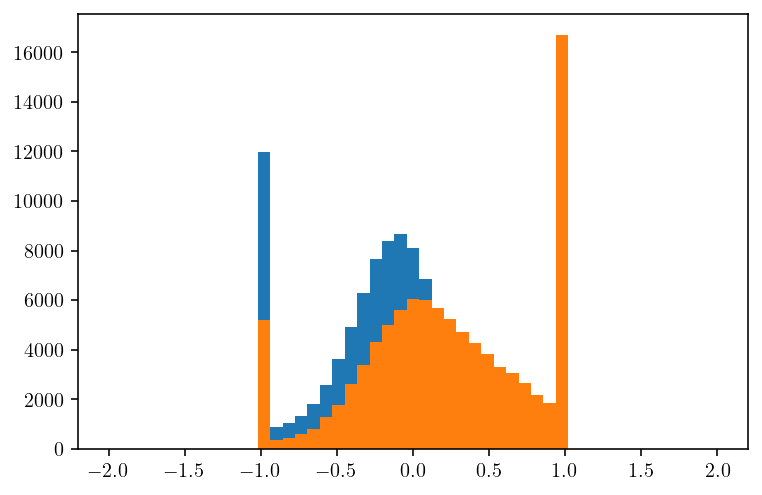

In [8]:
mask = (np.abs(df["chi1z"]+ df["chi1z_bias"]) > 1.0)
df.loc[(np.abs(df["chi1z"]+ df["chi1z_bias"]) > 1.0), "chi1z_bias"] = np.sign(df[mask]["chi1z_bias"]) - df[mask]["chi1z"]

mask = (np.abs(df["chi2z"]+ df["chi2z_bias"]) > 1.0)
df.loc[(np.abs(df["chi2z"]+ df["chi2z_bias"]) > 1.0), "chi2z_bias"] = np.sign(df[mask]["chi2z_bias"]) - df[mask]["chi2z"]

plt.hist(df["chi1z_bias"] + df["chi1z"], bins=np.linspace(-2.0, 2.0, 50));
plt.hist(df["chi2z_bias"] + df["chi2z"], bins=np.linspace(-2.0, 2.0, 50));

# Compute M_tot

In [9]:
df["m_tot"] = df["m1_src"] + df["m2_src"]
df["m_tot_bias"] = df["m1_src_bias"] + df["m2_src_bias"]
df["m_tot_err"] = np.sqrt(df["m1_src_err"]**2 + df["m2_src_err"]**2)

In [10]:
data = df[(df["hybr"]==0.0) & (df["snr"]>100)]

# plt.scatter(data["snr"], np.abs(data["m_tot_bias"])/data["m_tot_err"], s=4)
# plt.scatter(data["snr"], np.abs(data["m1_src_bias"])/data["m1_src_err"], s=4)
# plt.scatter(data["snr"], np.abs(data["m2_src_bias"])/data["m2_src_err"], s=4)

# # plt.ylim(0, 100)
# plt.show()

print(np.median(np.abs(data["m_tot_bias"])/data["m_tot_err"]))
print(np.median(np.abs(data["m1_src_bias"])/data["m1_src_err"]))
print(np.median(np.abs(data["m2_src_bias"])/data["m2_src_err"]))
print()
print(np.median(np.abs(data["m_tot_bias"])))
print(np.median(np.abs(data["m1_src_bias"])))
print(np.median(np.abs(data["m2_src_bias"])))

print()
print(np.median(np.abs(data["m_tot_err"])))
print(np.median(np.abs(data["m1_src_err"])))
print(np.median(np.abs(data["m2_src_err"])))


1.827760323616888
1.2786858882500889
1.5709539194558464

3.4687211499637414
2.075329496774759
1.3307728884068954

2.091416225997345
1.844463819049115
0.9526713357849679


# Compute $\chi_{eff}$

In [11]:
def chi_eff_from_df(df):
    chi1 = df["chi1z"]
    chi2 = df["chi2z"]
    m1 = df["m1_det"]
    m2 = df["m2_det"]

    chi_eff = (1/(m1+m2)) * (m1*chi1 + m2*chi2)

    chi1_biased = chi1 + df["chi1z_bias"]
    chi2_biased = chi2 + df["chi2z_bias"]
    m1_biased = m1 + df["m1_det_bias"]
    m2_biased = m2 + df["m2_det_bias"]

    chi_eff_biased = (1/(m1_biased+m2_biased)) * (m1_biased*chi1_biased + m2_biased*chi2_biased)
    chi_eff_bias = chi_eff_biased - chi_eff


    sigchi1 = df["chi1z_err"]
    sigchi2 = df["chi2z_err"]
    sigm1 = df["m1_det_err"]
    sigm2 = df["m2_det_err"]

    aux0=((((chi1-chi2)**2))*((m2**2)*(sigm1**2)))+((((chi1-chi2)**2))*((m1**2)*(sigm2**2)))
    aux1=((m1**2)*((((m1+m2)**2))*(sigchi1**2)))+(((m2**2)*((((m1+m2)**2))*(sigchi2**2)))+aux0)

    chi_eff_err = np.sqrt((((m1+m2)**-4.)*aux1))

    return chi_eff, chi_eff_bias, chi_eff_err


def chi_eff_src_from_df(df):
    chi1 = df["chi1z"]
    chi2 = df["chi2z"]
    m1 = df["m1_src"]
    m2 = df["m2_src"]

    chi_eff = (1/(m1+m2)) * (m1*chi1 + m2*chi2)

    chi1_biased = chi1 + df["chi1z_bias"]
    chi2_biased = chi2 + df["chi2z_bias"]
    
    m1_biased = m1 + df["m1_src_bias"]
    m2_biased = m2 + df["m2_src_bias"]

    chi_eff_biased = (1/(m1_biased+m2_biased)) * (m1_biased*chi1_biased + m2_biased*chi2_biased)
    chi_eff_bias = chi_eff_biased - chi_eff


    sigchi1 = df["chi1z_err"]
    sigchi2 = df["chi2z_err"]
    sigm1 = df["m1_src_err"]
    sigm2 = df["m2_src_err"]

    aux0=((((chi1-chi2)**2))*((m2**2)*(sigm1**2)))+((((chi1-chi2)**2))*((m1**2)*(sigm2**2)))
    aux1=((m1**2)*((((m1+m2)**2))*(sigchi1**2)))+(((m2**2)*((((m1+m2)**2))*(sigchi2**2)))+aux0)

    chi_eff_err = np.sqrt((((m1+m2)**-4.)*aux1))

    return chi_eff, chi_eff_bias, chi_eff_err

In [12]:
# df["chi_eff"], df["chi_eff_bias"], df["chi_eff_err"] = chi_eff_src_from_df(df)
# df = df.dropna()

# Population Distribution

In [8]:
from scipy import interpolate, integrate

def power(m1, alpha, m_min, m_max):
    '''
    BBH merger primary mass PDF.
    '''
    if alpha != -1:
        N1 = 1 / ((m_max**(alpha+1) - m_min**(alpha+1))/(alpha+1))
    else:
        N1 = 1/(np.log(m_max/m_min))

    return np.piecewise(m1, [(m1 < m_min), (m1 >= m_min)*(m1 < m_max), (m1 >= m_max)],
                        [0, lambda m1: N1*m1**alpha, 0])

def butterworth(m1, m0, eta):
    norm = integrate.trapezoid((1+ (m0/m1)**eta)**(-1), m1)

    return (1+ (m0/m1)**eta)**(-1) / norm

def truncation(m1, m_min, m_max):
    return np.piecewise(m1, [(m1 < m_max), (m1 >= m_min)*(m1 < m_max), (m1 >= m_max)],
                        [0, 1.0, 0])

def beta(chi, a, b):
    func = chi**(a-1) * (1-chi)**(b-1)
    norm = integrate.trapezoid(func, chi)
    return func/norm

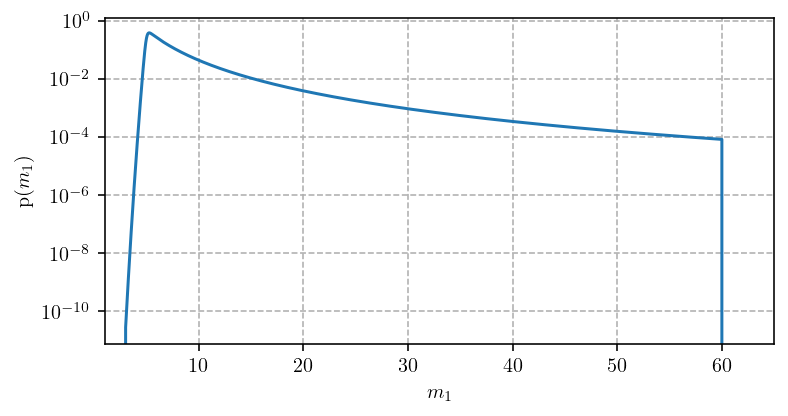

In [9]:
# Mass Distribution
fig, ax = plt.subplots(figsize=(6,3))

m1 = np.geomspace(2, 100, 100000)
pdf_m1 = butterworth(m1, 5, 50) * power(m1, -3.5, 3, 60)
pdf_m1 = pdf_m1/integrate.trapezoid(pdf_m1, m1)
plt.plot(m1, pdf_m1)


plt.xlim(1, 65)

plt.xlabel("$m_1$")
plt.ylabel("p($m_1$)")
# plt.legend(loc='upper right')

# plt.title("Truncated Power Law", variant='small-caps')

plt.semilogy()

plt.grid(ls='--')


plt.show()

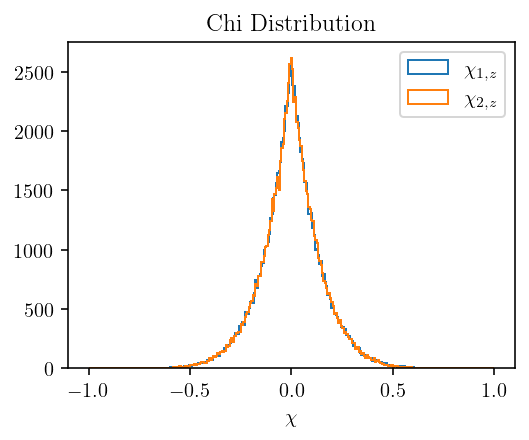

In [10]:
# Chi Distribution
fig, ax = plt.subplots(figsize=(4, 3))

chi_range = np.linspace(0, 1, 100000)
a = 2
b = 7
pdf_chi = beta(chi_range, a, b)
# plt.plot(chi_range, pdf_chi)

data = df[df["hybr"]==0.0]
bins = np.linspace(-1, 1, 300)
plt.hist(data["chi1z"], bins=bins, histtype='step', label="$\chi_{1,z}$")
plt.hist(data["chi2z"], bins=bins, histtype='step', label="$\chi_{2,z}$")

# plt.xlim(0, 1)
plt.xlabel("$\chi$")
plt.ylabel("")
plt.legend(loc='upper right')
plt.title("Chi Distribution")

plt.show()

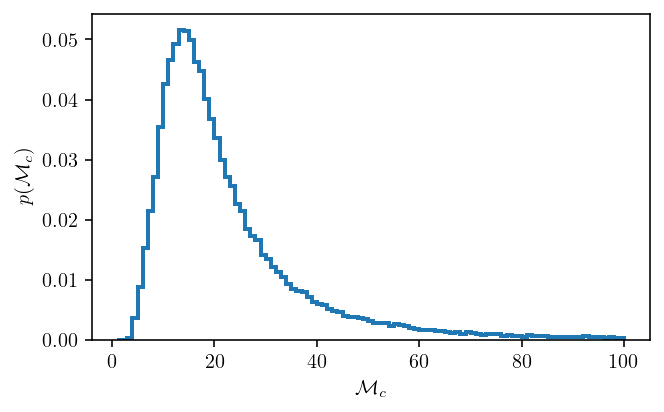

In [11]:
# Mc Distribution
fig, ax = plt.subplots(figsize=(5, 3))

data = df[df["hybr"]==0.0]
bins = np.linspace(1, 100, 100)
plt.hist(data["Mc"], bins=bins, lw=2, density=True, histtype='step')

plt.xlabel("$\mathcal{M}_c$")
plt.ylabel("$p(\mathcal{M}_c )$")

plt.show()

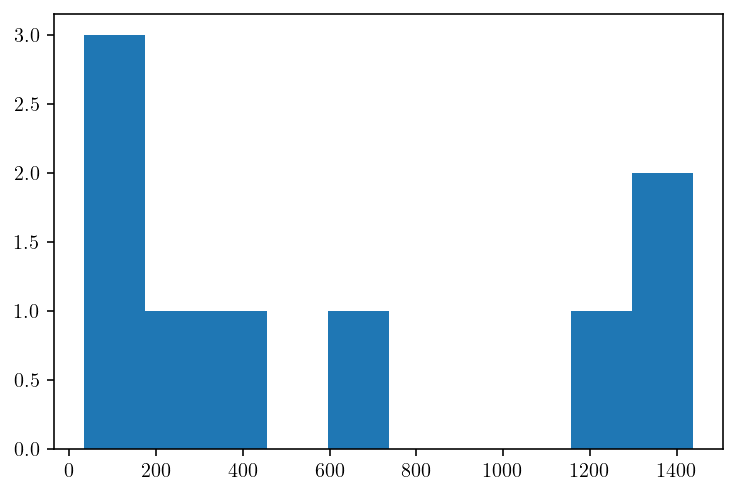

147


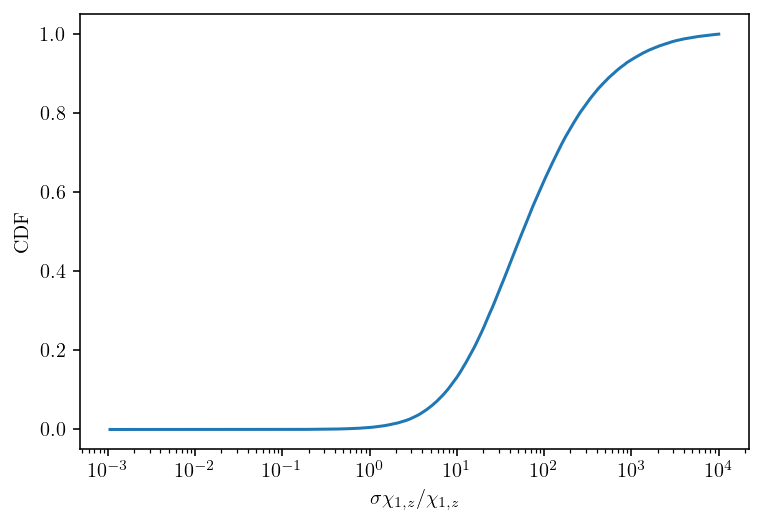

In [12]:
# How well are the spins measured?

data = np.abs(df[df["hybr"]==0]["chi1z_err"]/df[df["hybr"]==0]["chi1z"])

plt.hist(df[(df["hybr"]==0) & (np.abs(df["chi1z_err"]/df["chi1z"])<0.1)]["snr"])
plt.show()

# print(df[(df["hybr"]==0) & (np.abs(df["chi1z_err"])<0.1)]["snr"])
print(np.sum(data<0.50))

fig, ax = plt.subplots(figsize=(6,4))

bins = np.geomspace(0.001, 10000.0, 300)
count, bins_count = np.histogram(data, bins=bins)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
ax.plot(bins_count[1:], cdf)
ax.set_ylabel("CDF")
ax.set_xlabel("$\sigma\chi_{1,z}/\chi_{1,z}$")

plt.semilogx()
plt.show()


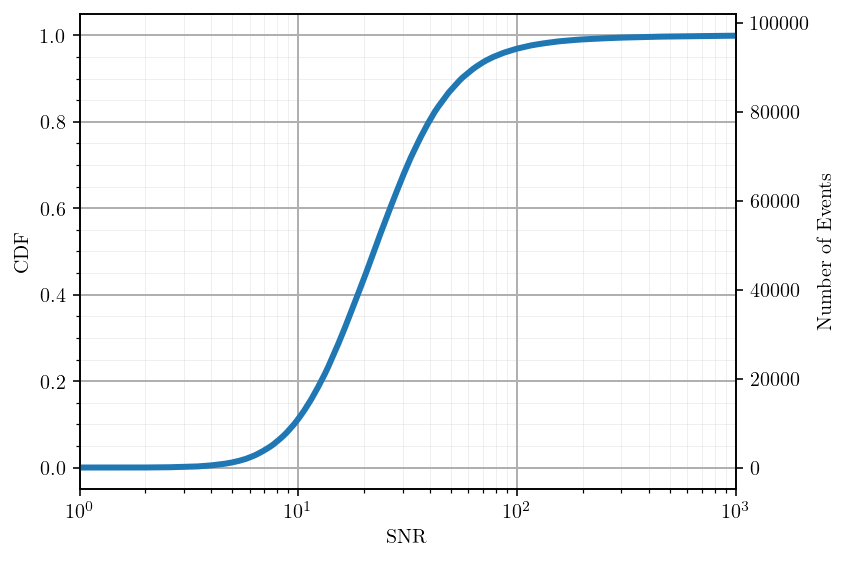

In [13]:
# SNR Distribution
fig, ax = plt.subplots(figsize=(6,4))

data = df[df["hybr"]==0]["snr"]

bins = np.geomspace(0.1, 5000, 300)
# plt.hist(data, bins=bins, histtype='step')

count, bins_count = np.histogram(data, bins=bins)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
ax.plot(bins_count[1:], cdf)
ax.set_ylabel("CDF")
ax.set_xlabel("SNR")

ax.grid(which = "major", linewidth = 1)
ax.grid(which = "minor", linewidth = 0.5, alpha=0.2)
ax.minorticks_on()

ax2 = ax.twinx()
count, bins_count = np.histogram(data, bins=bins)
pdf = count
cdf = np.cumsum(pdf)
ax2.plot(bins_count[1:], cdf, lw=3)
ax2.set_ylabel("Number of Events")


plt.xlim(1, 1000)
plt.xlabel("SNR")
plt.semilogx()
plt.tick_params(axis='y', which='minor')

plt.tight_layout()
# plt.savefig("1D_bias_plots/snr_cdf.pdf", dpi=300)
plt.show()

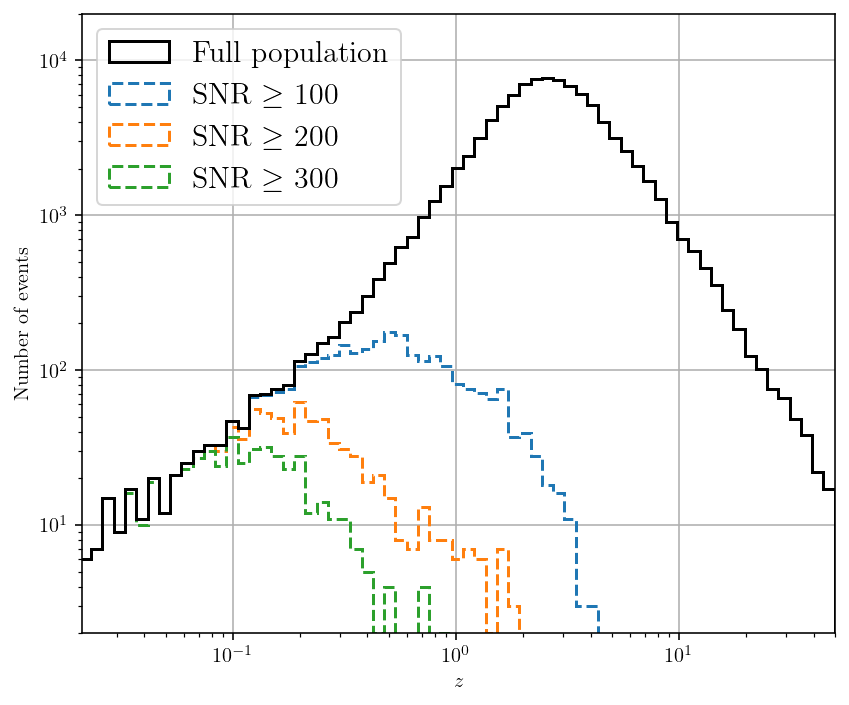

In [14]:
snrs = [100, 200, 300]

fig, ax = plt.subplots(figsize=(6,5))


data = df[(df["hybr"]==0.0) & (df["snr"]>0)]
bins = np.geomspace(0.001, 100, 100)
# bins = np.linspace(0, 10, 1000)

plt.hist(data["z"], bins=bins, label="Full population", color='k', lw=1.5, histtype='step', zorder=20)

for snr in snrs:
    data = df[(df["hybr"]==0.0) & (df["snr"]>snr)]
    bins = np.geomspace(0.001, 100, 100)
    plt.hist(data["z"], bins=bins, label=f"SNR $\geq$ {snr}", lw=1.5, ls='--', histtype='step')

plt.loglog()
plt.xlim(0.021, 50)
plt.ylim(2, 2e4)
plt.legend(fontsize=15, loc='upper left')
plt.grid()

plt.xlabel("$z$")
plt.ylabel("Number of events")

plt.tight_layout()
# plt.savefig('1D_bias_plots/snr_vs_z_dist.pdf', dpi=300)
plt.show()

# Interesting Sub-populations

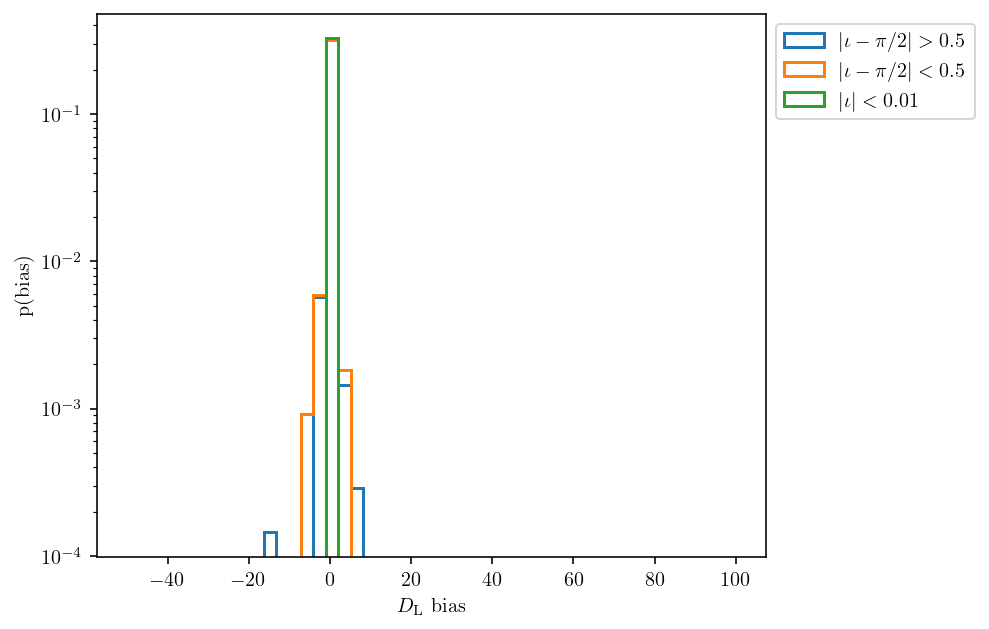

In [15]:
fig, ax = plt.subplots(figsize=(6,5))

data = df[(df["hybr"]==0.0) & (df["snr"]>100)]

param = "DL"

data_1 = data[(np.abs(data["iota"]-np.pi/2)>(0.5))]
data_2 = data[(np.abs(data["iota"]-np.pi/2)<(0.5))]
data_3 = data[((data["iota"])<(0.01))]

cond1 = "$|\iota-\pi/2| > 0.5$"
cond2 = "$|\iota-\pi/2| < 0.5$"
cond3 = "$|\iota| < 0.01$"

bins = np.linspace(-50, 100, 50)
plt.hist(data_1[param+"_bias"]/data_1[param+"_err"], bins=bins, density=True, lw=1.5, histtype='step', label=cond1)
plt.hist(data_2[param+"_bias"]/data_2[param+"_err"], bins=bins, density=True, lw=1.5, histtype='step', label=cond2)
plt.hist(data_3[param+"_bias"]/data_3[param+"_err"], bins=bins, density=True, lw=1.5, histtype='step', label=cond3)



plt.xlabel(labels[param]+" bias")
plt.ylabel('p(bias)')

plt.semilogy()

plt.legend(bbox_to_anchor=(1,1))

plt.show()

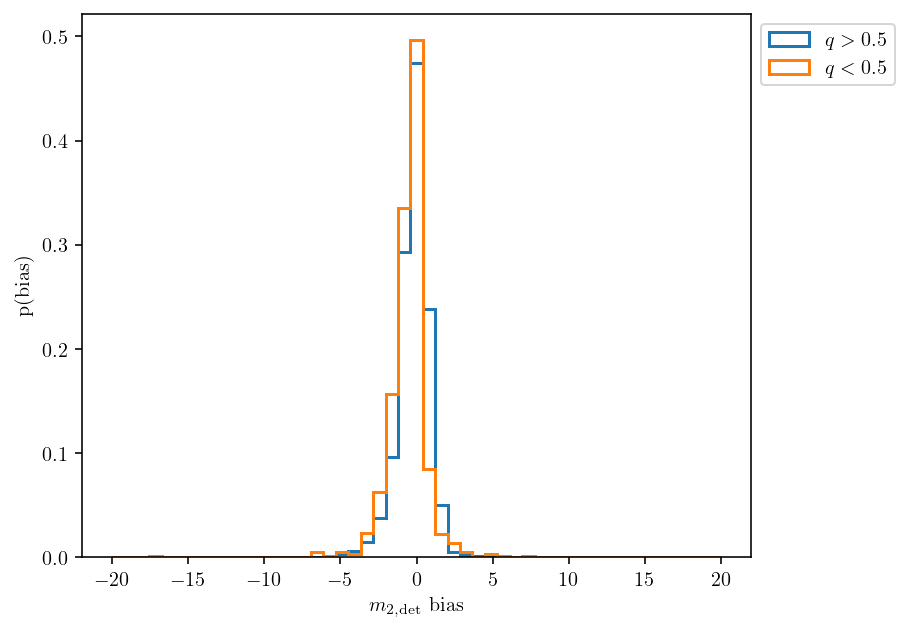

In [16]:
fig, ax = plt.subplots(figsize=(6,5))

data = df[(df["hybr"]==0.0) & (df["snr"]>100)]


data_1 = data[(np.abs(data["q"])>(0.6))]
data_2 = data[(np.abs(data["q"])<(0.6))]
cond1 = "$q > 0.5$"
cond2 = "$q < 0.5$"

param = 'm2_det'
bins = np.linspace(-20, 20, 50)
plt.hist(data_1[param+"_bias"]/data_1[param+"_err"], bins=bins, density=True, lw=1.5, histtype='step', label=cond1)
plt.hist(data_2[param+"_bias"]/data_2[param+"_err"], bins=bins, density=True, lw=1.5, histtype='step', label=cond2)

plt.xlabel(labels[param]+" bias")
plt.ylabel('p(bias)')

plt.legend(bbox_to_anchor=(1,1))

plt.show()

## Explaining the positive DL, z biases

Usman+ 2019 (https://iopscience.iop.org/article/10.3847/1538-4357/ab0b3e) study the correlation between DL and inclination posteriors. They explain first that for most ~face-on and face-away binaries, there is a strong degeneracy between the DL and inclination measurements due to how the two dependancies show up in the GW amplitude terms.

In Fig. 8, they show the posteriors for ET with an injection of i=~60, where we can see that there is a strong support for larger DL values. Most of our binaries have i~$\pi/2$, which corresponds to this region vaguely. Hence, the Fisher analysis prefers a positive DL bias.

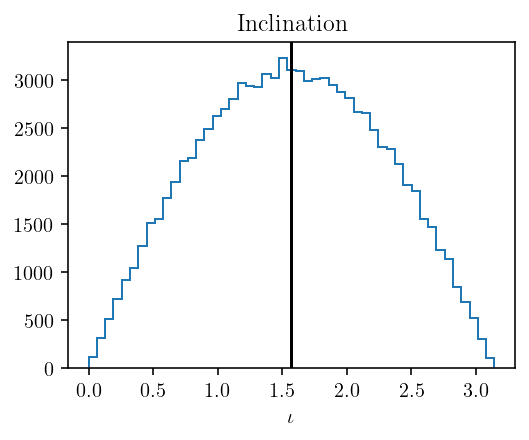

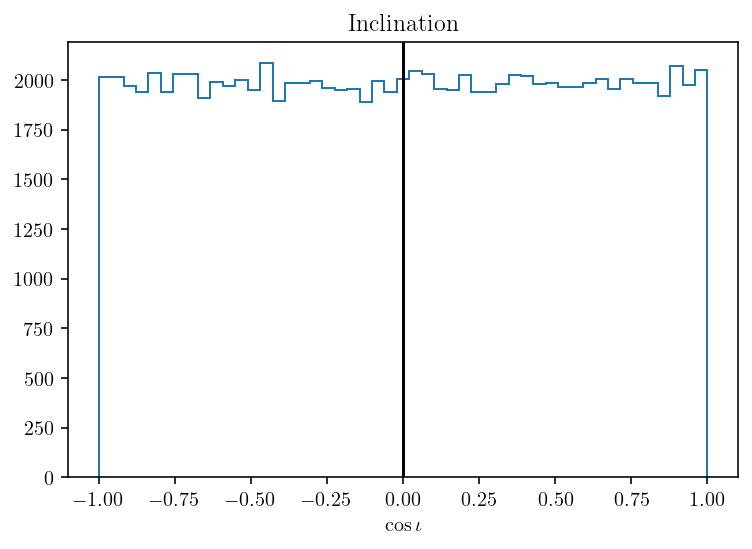

In [17]:
fig, ax = plt.subplots(figsize=(4, 3))

bins = np.linspace(0, np.pi, 50)
plt.hist(df["iota"], bins=bins, histtype='step')
plt.axvline(np.pi/2, color='k')

# plt.xlim(0, 1)
plt.xlabel("$\iota$")
plt.ylabel("")
plt.title("Inclination")

plt.show()

bins = np.linspace(-1, 1, 50)
plt.hist(np.cos(df["iota"]), bins=bins, histtype='step')
plt.axvline(0.0, color='k')

# plt.xlim(0, 1)
plt.xlabel("$\cos \iota$")
plt.ylabel("")
plt.title("Inclination")

plt.show()

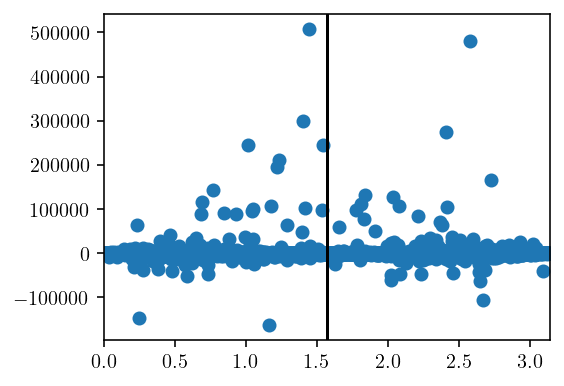

In [19]:
fig, ax = plt.subplots(figsize=(4, 3))

data = df[(df["hybr"]==0.0) & (df["snr"]>12)]
plt.scatter(data["iota"], data["DL_bias"])
plt.axvline(np.pi/2, color='k')
plt.xlim(0, np.pi)
# plt.semilogy()
plt.show()

# Astrophysical Implications

## Listening to the Universe SNR comparison

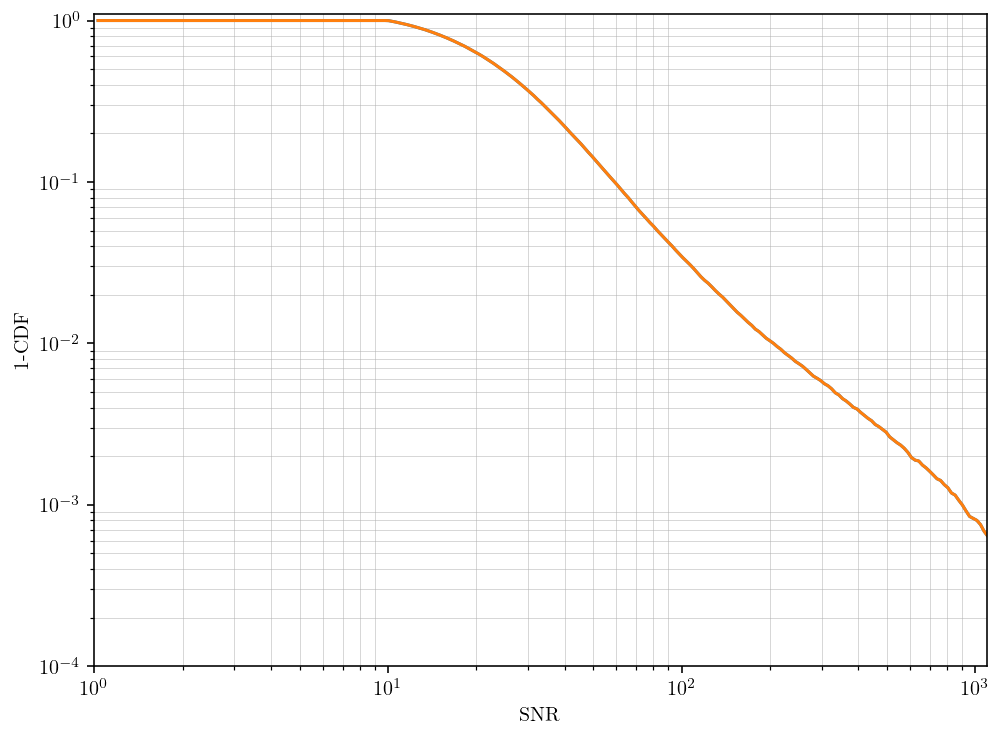

In [20]:
fig, ax = plt.subplots(figsize=(8,6))

bins = np.geomspace(1, 5000, 300)

data = df[(df["hybr"]==0.0) & (df["snr"]>10)]["snr"]
count, bins_count = np.histogram(data, bins=bins)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
ax.plot(bins_count[1:], 1-cdf)

data = df[(df["hybr"]==0.0) & (df["snr"]>10) & (np.abs(df["chi1z"])<0.75) & (np.abs(df["chi2z"])<0.75)]["snr"]
count, bins_count = np.histogram(data, bins=bins)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
ax.plot(bins_count[1:], 1-cdf)

ax.set_ylabel("1-CDF")
ax.set_xlabel("SNR")

ax.grid(which = "major", linewidth = 1)
ax.grid(which = "minor", linewidth = 0.5, alpha=0.5)
ax.minorticks_on()

ax.set_ylim(1e-4, 1.1)
ax.set_xlim(1, 1.1e3)
plt.loglog()
plt.grid()
plt.show()

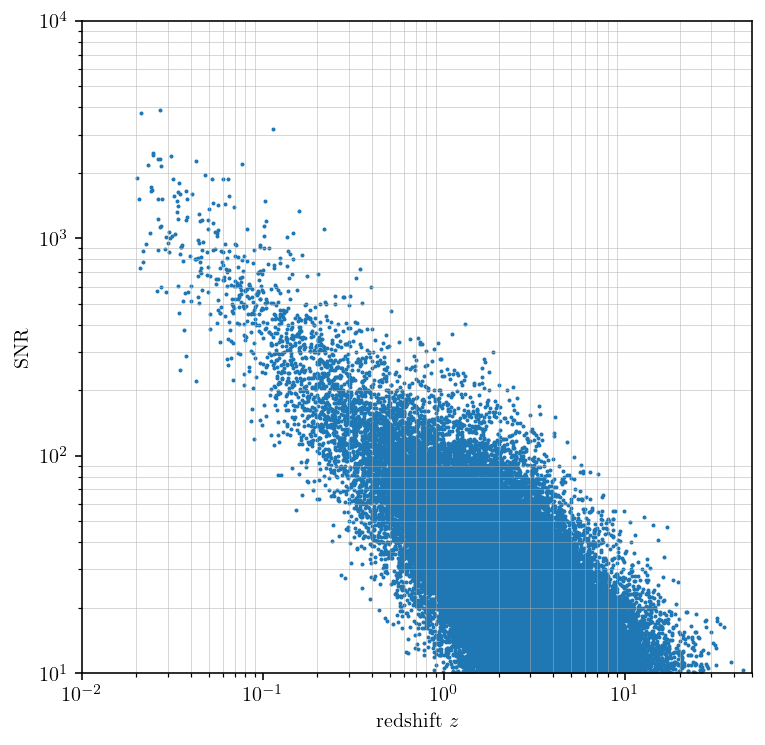

In [21]:
# compare to Fig. 5 of Listening to the Universe
# They clearly have more low redshift binaries, probably due to delay times

fig, ax = plt.subplots(figsize=(6,6))

data = df[(df["hybr"]==0.0) & (df["snr"]>10)]

plt.scatter(data["z"], data["snr"], s=1)

ax.grid(which = "minor", linewidth = 0.5, alpha=0.5)
ax.minorticks_on()

plt.xlabel("redshift $z$")
plt.ylabel("SNR")

plt.xlim(1e-2, 5e1)
plt.ylim(10, 1e4)

plt.loglog()

plt.show()

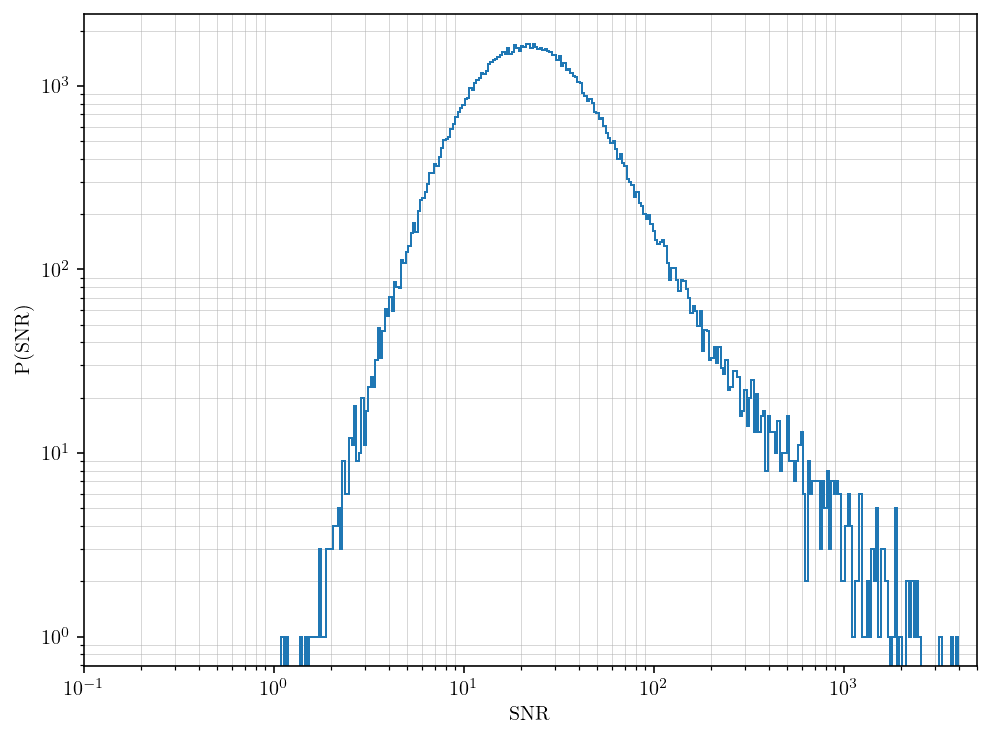

In [22]:
# compare to Fig. 7 of Iacovelli 2022 (https://iopscience.iop.org/article/10.3847/1538-4357/ac9cd4)
# compare to Fig. 6. of Pieroni 2022 (https://www.nature.com/articles/s41598-022-19540-7)

# The peak of SNR, and overall distribution, is almost identical 
# EVEN THOUGH THEY ARE USING POWER+PEAK!!!


fig, ax = plt.subplots(figsize=(8,6))

bins = np.geomspace(1, 5000, 300)

data = df[(df["hybr"]==0.0) & (df["snr"]>0)]["snr"]
# count, bins_count = np.histogram(data, bins=bins)

plt.hist(data, bins=bins, histtype='step')

ax.grid(which = "minor", linewidth = 0.5, alpha=0.5)
ax.minorticks_on()

plt.xlabel("SNR")
plt.ylabel("P(SNR)")

plt.xlim(1e-1, 5e3)
# plt.ylim(10, 1e4)

plt.loglog()

plt.show()

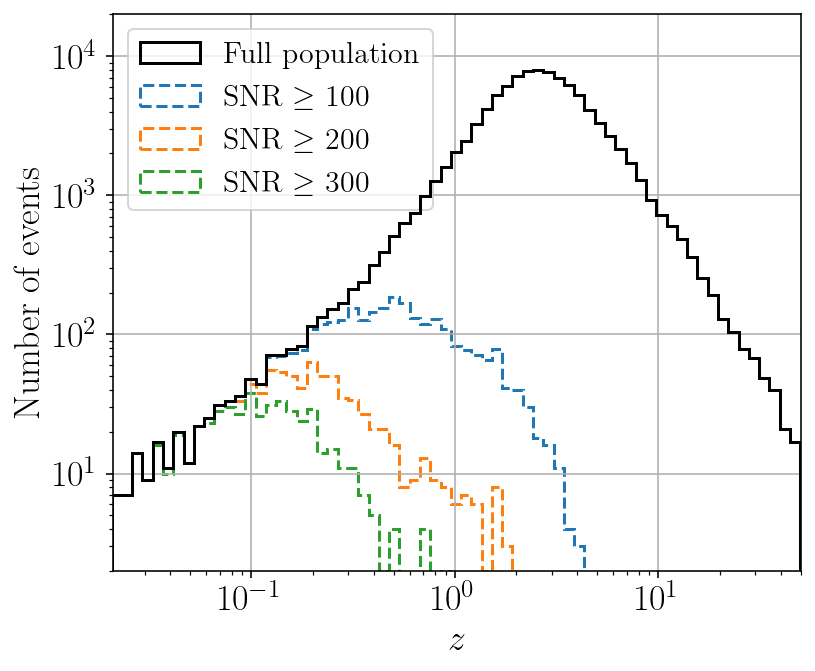

In [33]:
# Compare to Fig. 11 Iacovelli 2022 (https://iopscience.iop.org/article/10.3847/1538-4357/ac9cd4)
# The SNR distributions match almost perfectly
snrs = [100, 200, 300]

fig, ax = plt.subplots(figsize=(6,5))


data = df[(df["hybr"]==0.0) & (df["snr"]>0)]
bins = np.geomspace(0.001, 100, 100)
# bins = np.linspace(0, 10, 1000)

plt.hist(data["z"], bins=bins, label="Full population", color='k', lw=1.5, histtype='step', zorder=20)

for snr in snrs:
    data = df[(df["hybr"]==0.0) & (df["snr"]>snr)]
    bins = np.geomspace(0.001, 100, 100)
    plt.hist(data["z"], bins=bins, label=f"SNR $\geq$ {snr}", lw=1.5, ls='--', histtype='step')

plt.loglog()
plt.xlim(0.021, 50)
plt.ylim(2, 2e4)
plt.legend(fontsize=15, loc='upper left')
plt.grid()

plt.xlabel("$z$")
plt.ylabel("Number of events")

plt.tight_layout()
plt.show()

## Muttoni 2023, Dark Siren Cosmology

In [23]:
# cosmology.luminosity_distance(0.25)
# cosmology.luminosity_distance(0.1)
cosmology.luminosity_distance(1e-8)

<Quantity 4.43086699e-05 Mpc>

In [24]:
data = df[(df["hybr"]==0.0) & (df["snr"]>300) & (df["z"]<1)]
biases = np.abs(data["z_bias"])/data["z_err"]
np.median(biases)

0.33893076073256373

## PISN Mass Gap Contamination

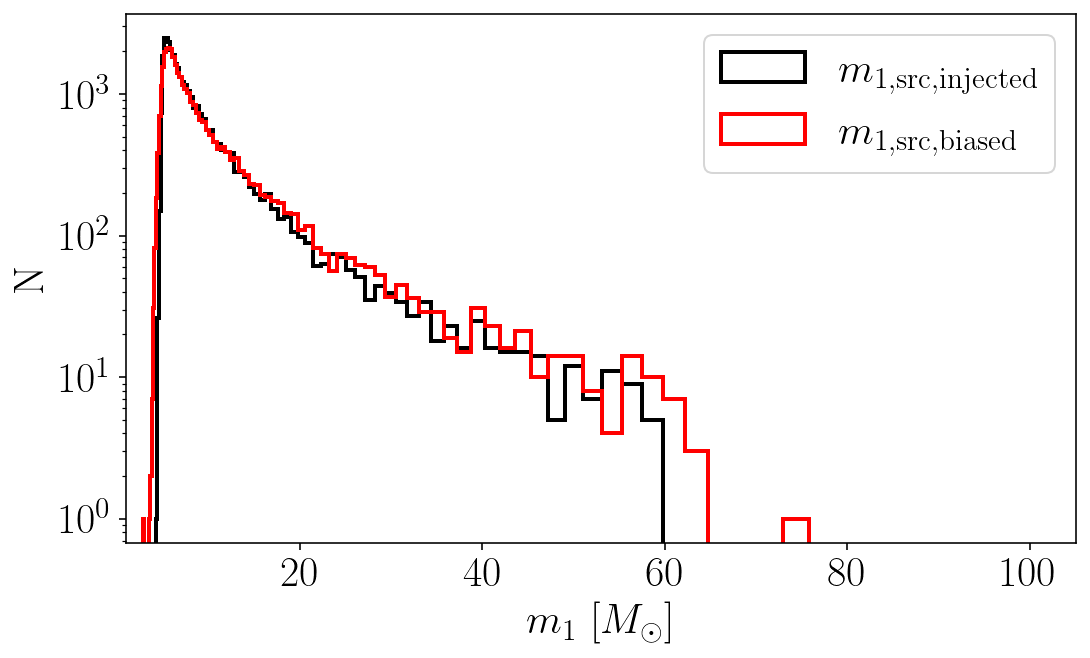

In [25]:
# Mass Distribution
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 21
})


fig, ax = plt.subplots(figsize=(8,5))

bins = np.geomspace(2, 200, 100)


data = df[(df["hybr"]==0.0) & (df["snr"]>12) & (df["z"]<2)]
bins = np.geomspace(2, 100, 100)
plt.hist(data["m1_src"], bins=bins, lw=2, histtype='step', color='k', label="$m_{1, \\rm src, injected}$")
plt.hist(data["m1_src"] + data["m1_src_bias"], lw=2, bins=bins, histtype='step', color='r', label="$m_{1, \\rm src, biased}$")

plt.xlim(1, 105)

plt.xlabel("$m_1$ [$M_\odot$]")
plt.ylabel("N")
plt.legend(loc='upper right')

plt.semilogy()

# plt.grid(ls='--')
plt.tight_layout()
# plt.savefig("1D_bias_plots/m1_src_dist.pdf", dpi=300)

plt.show()

## Ng 2021 Pop III inference

In [167]:
zs = [0.2, 1, 2, 5, 10, 14]
params= ["m1_src", "q", "chi1z", "z"]

for i, param in enumerate(params):
    for j, z in enumerate(zs):
        data = df[(df["hybr"]==0.0) & (df["z"]>z) & (df["snr"]>12)]
        biases = np.abs(data[param+"_bias"])
        biases = biases[~np.isnan(biases)]
        errs = data[param+"_err"]
        print(param, f", z > {z}, median bias = {np.median(biases):.1f}, median err: {np.median(errs):.1f}")

m1_src , z > 0.2, median bias = 3.6, median err: 5.4
m1_src , z > 1, median bias = 3.7, median err: 5.6
m1_src , z > 2, median bias = 3.8, median err: 5.7
m1_src , z > 5, median bias = 4.0, median err: 5.6
m1_src , z > 10, median bias = 4.1, median err: 6.4
m1_src , z > 14, median bias = 4.7, median err: 8.7
q , z > 0.2, median bias = 0.3, median err: 0.1
q , z > 1, median bias = 0.3, median err: 0.1
q , z > 2, median bias = 0.3, median err: 0.1
q , z > 5, median bias = 0.3, median err: 0.0
q , z > 10, median bias = 0.2, median err: 0.0
q , z > 14, median bias = 0.2, median err: 0.0
chi1z , z > 0.2, median bias = 1.0, median err: 3.5
chi1z , z > 1, median bias = 1.0, median err: 3.6
chi1z , z > 2, median bias = 1.0, median err: 3.9
chi1z , z > 5, median bias = 1.0, median err: 4.4
chi1z , z > 10, median bias = 1.0, median err: 6.0
chi1z , z > 14, median bias = 1.0, median err: 9.2
z , z > 0.2, median bias = 2.8, median err: 0.4
z , z > 1, median bias = 3.1, median err: 0.4
z , z > 2, m

### Reproducing the paper plots

2400 Pop III injections


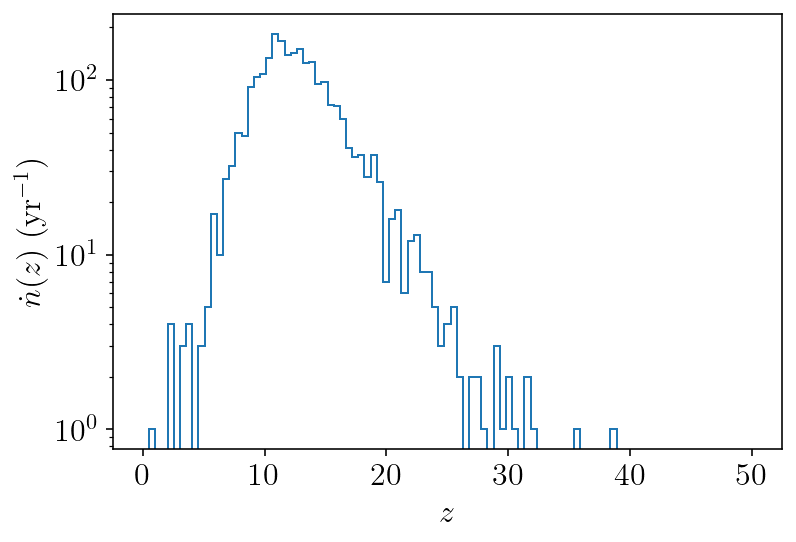

In [139]:
# create some pop III events
def pop3_z(z, a, b, c):
    return np.exp(a*(z-c)) / (b + a*np.exp((a+b)*(z-c)))

data = df[(df["hybr"]==0.0) & (df["snr"]>12)]

# num_injs = int(0.024*len(data)) #0.024 is the pop III branching ratio
num_injs = 2400
print(num_injs, "Pop III injections")

a = 0.66
b = 0.3
c = 11.6

z_range = np.linspace(0.02, 50.0, 10000)
pdf_z= pop3_z(z_range, a,b,c) 
pdf_z = pdf_z/integrate.trapezoid(pdf_z, z_range)

cdf_z = integrate.cumulative_trapezoid(pdf_z, z_range, initial=0)
inv_cdf_z = interpolate.interp1d(cdf_z / cdf_z[-1], z_range)
pop3_z_samples = inv_cdf_z(np.random.rand(num_injs))

bins = np.linspace(0.02, 50, 100)
plt.hist(pop3_z_samples, bins=bins, histtype='step')

plt.xlabel('$z$')
plt.ylabel("$\dot{n}(z)$ (yr$^{-1})$")
plt.semilogy()
plt.show()

48800 Cluster injections


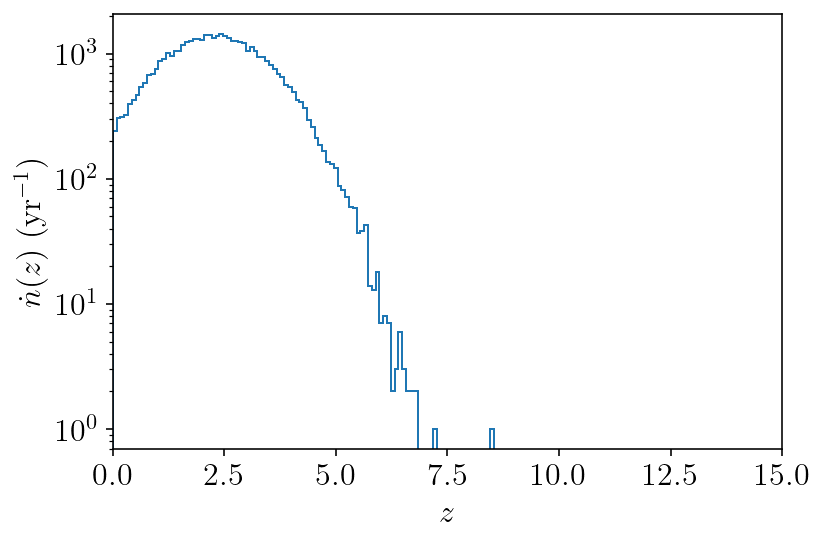

In [140]:
# create some Cluster events
data = df[(df["hybr"]==0.0) & (df["snr"]>12)]
num_injs = int(1.0*len(data)) #half of all detections are cluster
num_injs = 48800
print(num_injs, "Cluster injections")

# mu_z = z_at_value(Planck18.age, 1.63*u.Gyr)
# sigma_z = z_at_value(Planck18.age, 0.96*u.Gyr)
# t_z = z_at_value(Planck18.age, 0.66*u.Gyr)
# t_G = 0.66 # Gyr
# cluster_samples_t = np.random.lognormal(mean=1.63, sigma=0.96, size=num_injs) # Gyr
# cluster_samples_t = cluster_samples_t + t_G
# cluster_samples_t = cluster_samples_t[cluster_samples_t<13.7]
# cluster_samples_z = [z_at_value(Planck18.age, time * u.Gyr) for time in cluster_samples_t] 
# plt.hist(cluster_samples_z, bins=100, histtype='step')

cluster_samples = (np.random.normal(2.3, 1.2, size=num_injs))
cluster_samples = cluster_samples[cluster_samples>0]
plt.hist(cluster_samples, bins=100, histtype='step')

plt.xlabel('$z$')
plt.ylabel("$\dot{n}(z)$ (yr$^{-1})$")
plt.semilogy()
plt.xlim(0, 15)
plt.show()

48800 Field injections


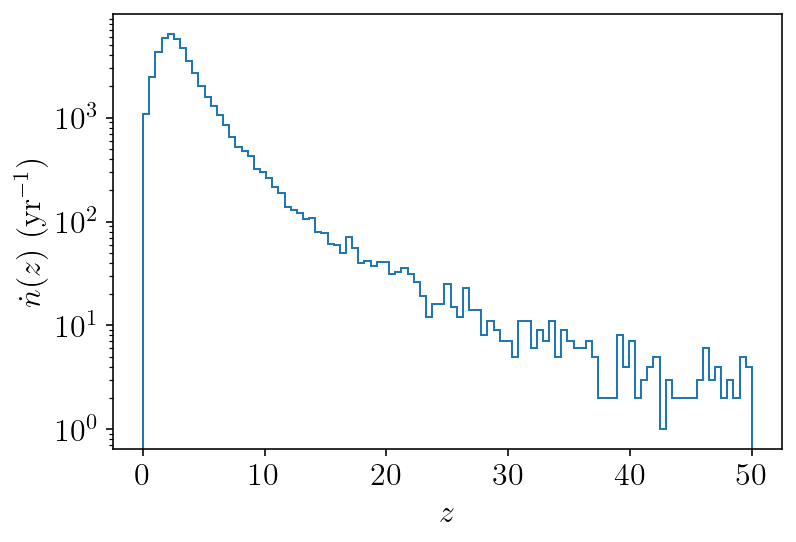

In [141]:
# create some Field events
def field_z(z, a, b, c):
    return (1+z)**a / (1 + ((1+z)/c)**b) 

data = df[(df["hybr"]==0.0) & (df["snr"]>12)]
# num_injs = int(1.0*len(data)) #half of all detections are cluster
num_injs = 48800
print(num_injs, "Field injections")

a, b, c = 2.57, 5.83, 3.36

z_range = np.linspace(0.02, 50.0, 10000)
pdf_z= field_z(z_range, a,b,c) 
pdf_z = pdf_z/integrate.trapezoid(pdf_z, z_range)

cdf_z = integrate.cumulative_trapezoid(pdf_z, z_range, initial=0)
inv_cdf_z = interpolate.interp1d(cdf_z / cdf_z[-1], z_range)
field_z_samples = inv_cdf_z(np.random.rand(num_injs))

bins = np.linspace(0.02, 50, 100)
plt.hist(field_z_samples, bins=bins, histtype='step')

plt.xlabel('$z$')
plt.ylabel("$\dot{n}(z)$ (yr$^{-1})$")
plt.semilogy()
plt.show()

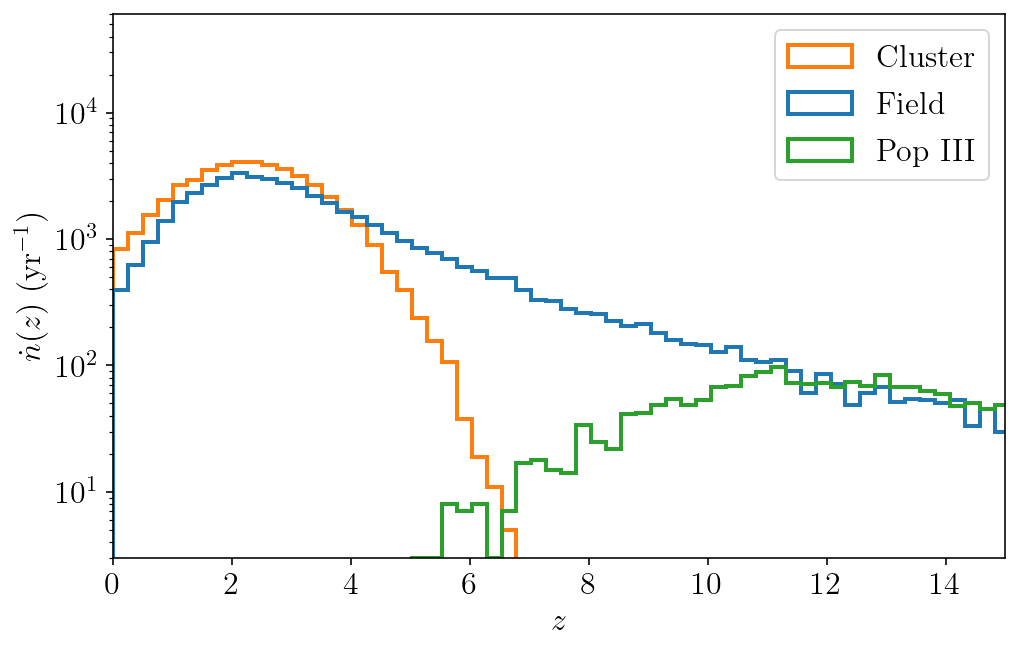

In [142]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 16
})


fig, ax = plt.subplots(figsize=(8, 5))

bins = np.linspace(0, 50, 200)

plt.hist(cluster_samples, bins=bins, lw=2, histtype='step', label="Cluster", color='C1')
plt.hist(field_z_samples, bins=bins, lw=2, histtype='step', label="Field", color='C0')
plt.hist(pop3_z_samples, bins=bins, lw=2, histtype='step', label="Pop III", color='C2')


plt.xlabel('$z$')
plt.ylabel("$\dot{n}(z)$ (yr$^{-1})$")
plt.xlim(0.00, 15.0)
plt.ylim(3, 6e4)
plt.semilogy()
plt.legend()
plt.show()



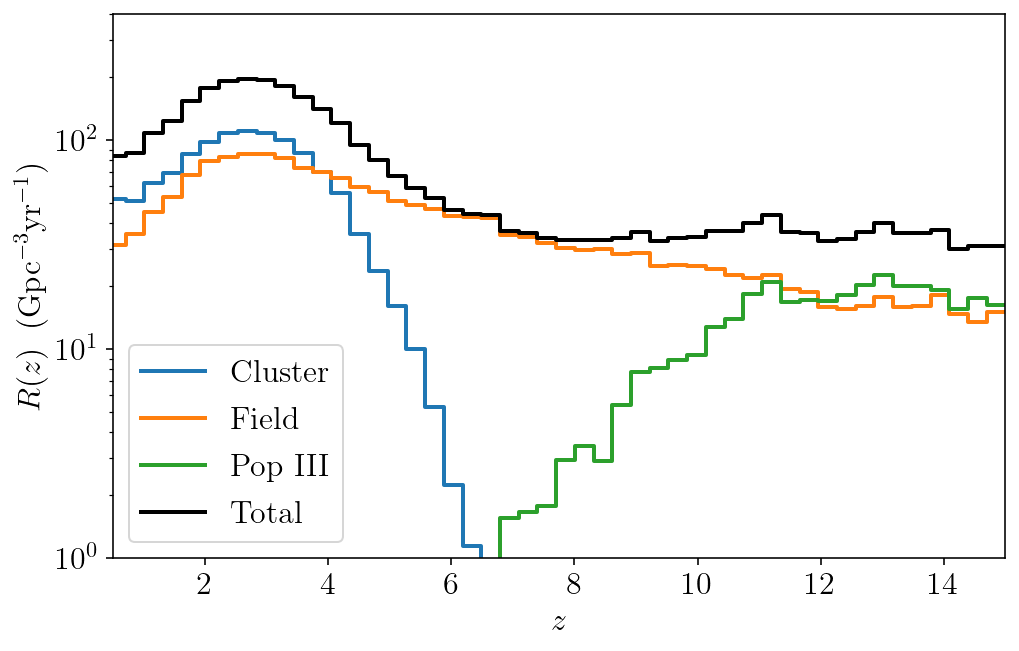

In [147]:
# Normalize by comoving volume

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 16
})


fig, ax = plt.subplots(figsize=(8, 5))

z_range = np.linspace(0.1, 15, 50)
volumes_gpc = (cosmology.comoving_volume(z_range[1:]) - cosmology.comoving_volume(z_range[:-1])).to(u.Gpc**3).value
volumes_gpc = volumes_gpc * 1/(1+z_range[1:])

counts_c, z_bins = np.histogram(cluster_samples, bins=z_range)
counts_c[0] = 0
plt.step(z_bins[1:], counts_c/volumes_gpc, color='C0', lw=2, label="Cluster")

counts_f, z_bins = np.histogram(field_z_samples, bins=z_range)
counts_f[0] = 0
plt.step(z_bins[1:],  counts_f/volumes_gpc, color='C1', lw=2, label="Field")

counts_p, z_bins = np.histogram(pop3_z_samples, bins=z_range)
counts_p[0] = 0
plt.step(z_bins[1:], counts_p/volumes_gpc, color='C2', lw=2, label="Pop III")


plt.step(z_bins[1:], (counts_f+counts_c+counts_p)/volumes_gpc, color='k', lw=2, label="Total")

plt.xlim(0.5, 15.0)
plt.ylim(1, 4e2)
plt.semilogy()

plt.legend()

plt.xlabel('$z$')
plt.ylabel("$R(z) \;\; (\\rm Gpc^{-3} yr^{-1})$")

plt.show()


### Fisher Pop results

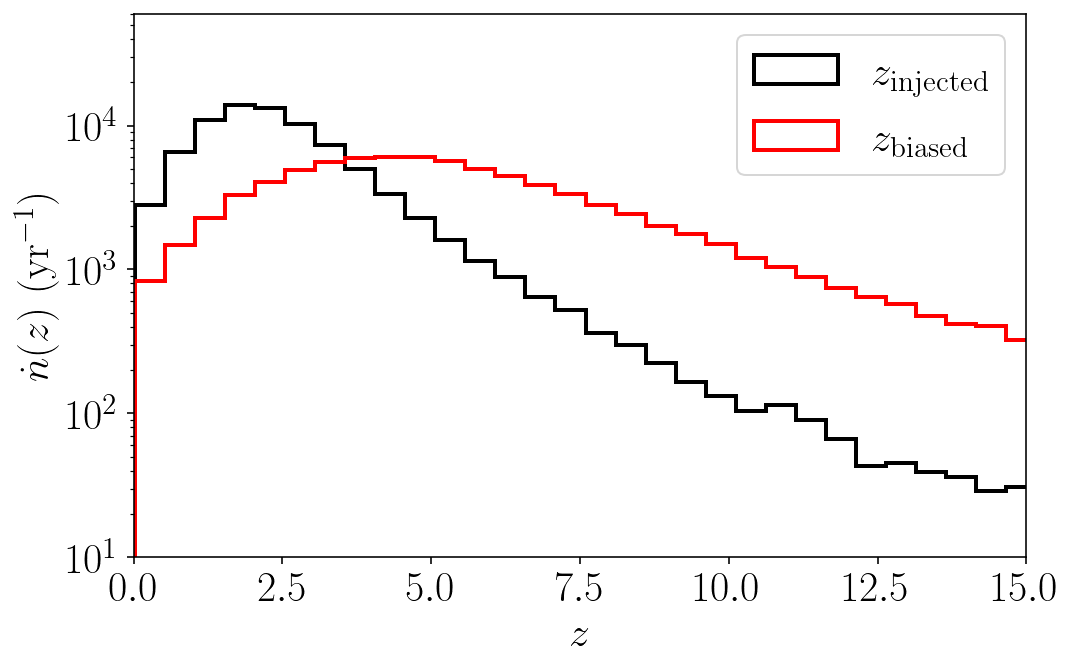

In [77]:
fig, ax = plt.subplots(figsize=(8,5))
data = df[(df["hybr"]==0.0) & (df["snr"]>12)]

bins = np.linspace(0.02, 50, 100)
plt.hist(data["z"], bins=bins, histtype='step', lw=2, label="$z_{\\rm injected}$", density=False, color='k')
plt.hist(data["z"] + data["z_bias"], bins=bins, lw=2, histtype='step', label="$z_{\\rm biased}$", density=False, color='r')

plt.xlabel('$z$')
plt.ylabel("$\dot{n}(z)$ (yr$^{-1})$")
plt.xlim(0.00, 15.0)
plt.ylim(10, 6e4)
plt.semilogy()
plt.legend()
plt.show()

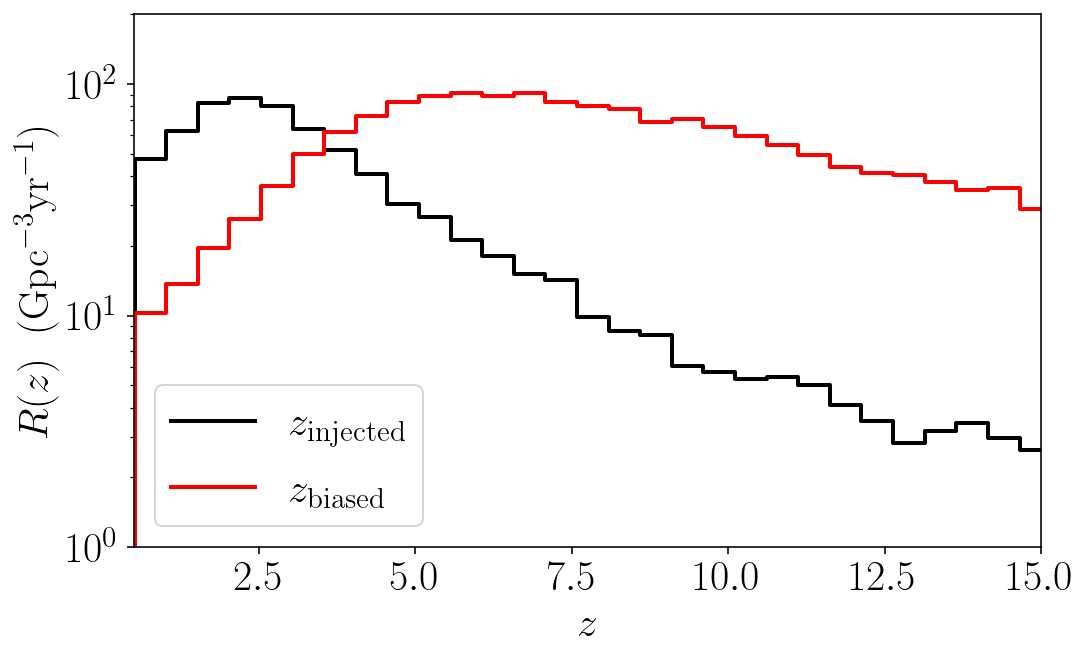

In [78]:
# Normalize by comoving volume

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 21
})

data = df[(df["hybr"]==0.0) & (df["snr"]>12)]

fig, ax = plt.subplots(figsize=(8, 5))


z_range = np.linspace(0.01, 50, 100)

volumes_gpc = (cosmology.comoving_volume(z_range[1:]) - cosmology.comoving_volume(z_range[:-1])).to(u.Gpc**3).value
volumes_gpc = volumes_gpc * 1/(1+z_range[1:])

counts, z_bins = np.histogram(data["z"][::2], bins=z_range)
counts[0] = 0
plt.step(z_bins[1:], counts/volumes_gpc, color='k', lw=2, label="$z_{\\rm injected}$")

counts, z_bins = np.histogram(data["z"][::2]+data["z_bias"][::2], bins=z_range)
counts[0] = 0
plt.step(z_bins[1:], counts/volumes_gpc, color='r', lw=2, label="$z_{\\rm biased}$")

# counts, z_bins = np.histogram(pop3_z_samples, bins=z_range)
# counts[0] = 0
# plt.step(z_bins[1:], counts/volumes_gpc)

plt.xlim(0.5, 15.0)
plt.ylim(1, 2e2)
plt.semilogy()

plt.legend()

plt.xlabel('$z$')
plt.ylabel("$R(z) \;\; (\\rm Gpc^{-3} yr^{-1})$")
plt.tight_layout()
# plt.savefig('1D_bias_plots/biased_z_dist.pdf', dpi=300)
plt.show()


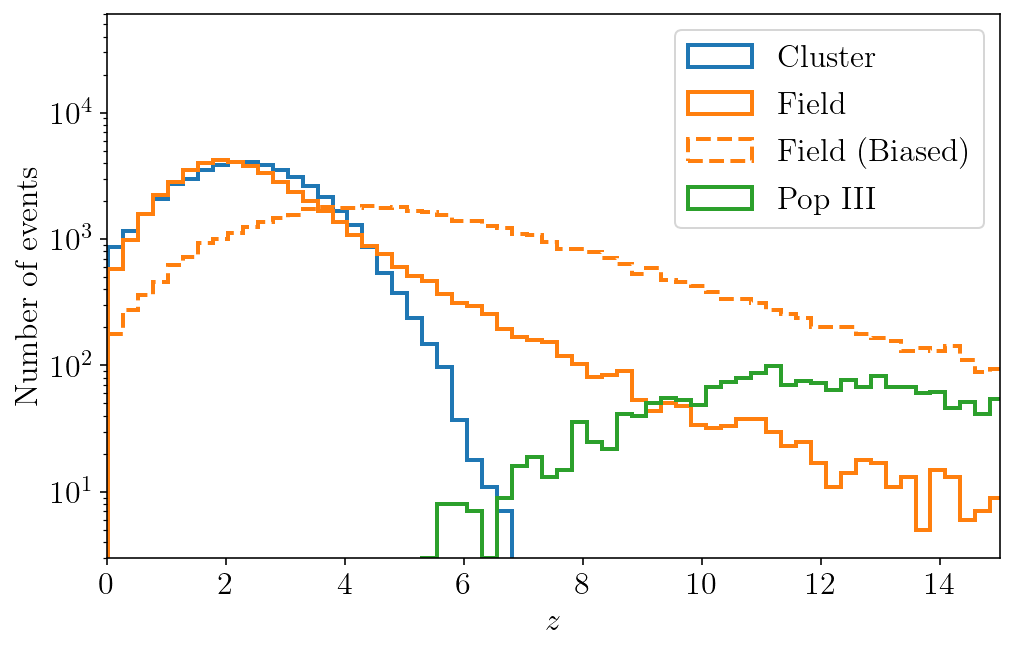

In [152]:
# superimpose mock Cluster and Pop III populations

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 16
})

data = df[(df["hybr"]==0.0) & (df["snr"]>12)]

num_field = 48800

fig, ax = plt.subplots(figsize=(8, 5))

bins = np.linspace(0.02, 50, 200)

plt.hist(cluster_samples, bins=bins, lw=2, histtype='step', label="Cluster", color='C0')

# plot half the field binaries, since half should be in cluster
plt.hist(data["z"][:num_field], bins=bins, histtype='step', lw=2, label='Field', density=False, color='C1')
plt.hist(data["z"][:num_field] + data["z_bias"][:num_field], bins=bins, lw=2, ls='--', histtype='step', label="Field (Biased)", density=False, color='C1')

plt.hist(pop3_z_samples, bins=bins, lw=2, histtype='step', label="Pop III", color='C2')

plt.xlabel('$z$')
plt.ylabel("Number of events")
plt.xlim(0.00, 15.0)
plt.ylim(3, 6e4)
plt.semilogy()
plt.legend()
plt.show()



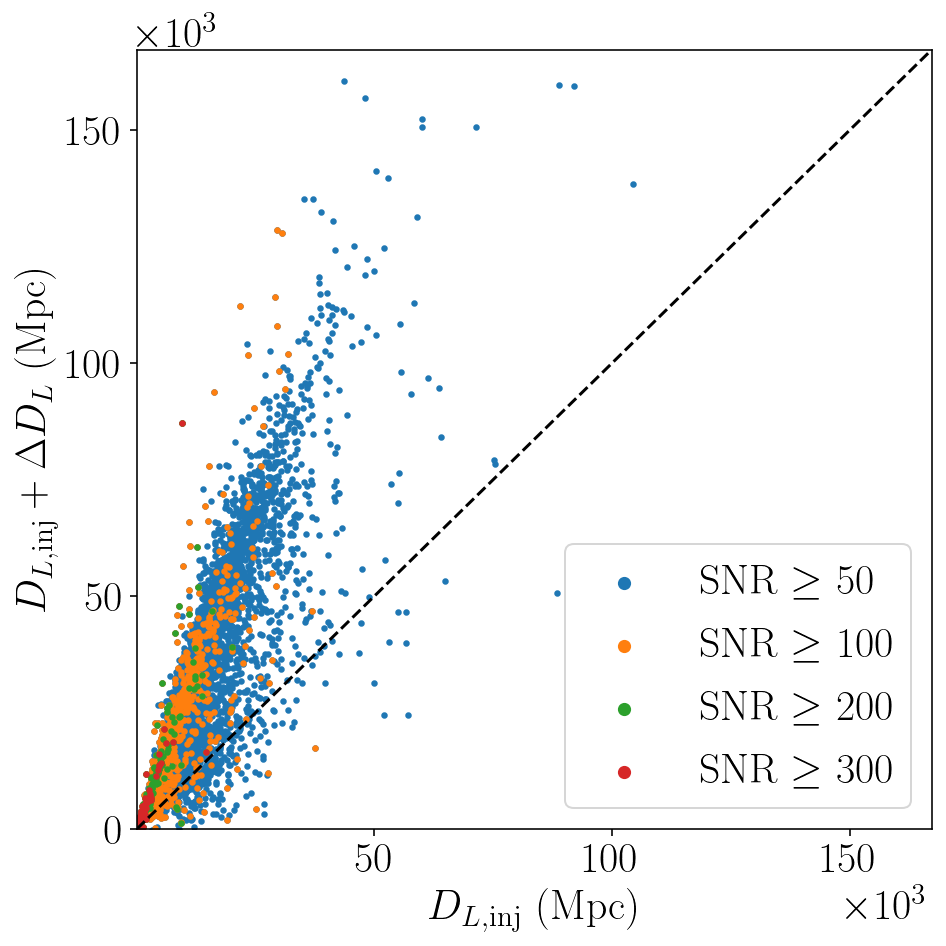

In [43]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 21
})

fig, ax = plt.subplots(figsize=(7, 7))

for snr in [50, 100, 200, 300]:
    data = df[(df["hybr"]==0.0) & (df["snr"]>snr)]
    plt.scatter(data["DL"], data["DL"]+data["DL_bias"], label=f"SNR $\geq$ {snr}", s=5)

plt.xlabel("$D_{L,\\rm inj}$ (Mpc)")
plt.ylabel("$D_{L,\\rm inj} + \Delta {D_L}$ (Mpc)")


x = np.linspace(0, dl_15, 10)
plt.plot(x, x, ls='--', color='k')
lgnd = plt.legend(markerscale=2.5)

plt.xlim(1.1e2, dl_15)
plt.ylim(1.1e2, dl_15)

plt.yticks(np.arange(0, dl_15, 50e3))

plt.ticklabel_format(axis='both', style='sci', scilimits=(3,3), useMathText=True)
plt.tight_layout()

# plt.savefig("1D_bias_plots/3g_dl_bias_hybr_0.pdf", dpi=300)
plt.show()

# Source-frame vs Detector-frame mass comparison

The overall similarity of the source frame and detector frame biases comes from the bi-directionality of the redshift bias.

When redshift is biased in the negative direction, such that the biased redshift becomes negative, the source frame mass is more biased compared to the detector frame mass. This usually correlates with $i \approx \pi/2$. 

When redshift is biased in the positive direction, the detector frame mass is more biased than the source frame mass.

These two effects compete, so that the overall result of including redshift is cancelled out.

Explanation for $- \Delta z \rightarrow$ source frame bias > detector frame bias:

When the redshift bias is $<0$, the biased $z$ tends to negative, which is unphysical. In these cases, we set the biased $z$ to 0 such that the $m_{1, \rm src}$ bias is approximately equal to the $m_{1, \rm det}$ bias.  Nevertheless, the measurement uncertainty in $m_{1, \rm src}$ becomes smaller by the addition of the $1/(1+z)$ factors to the covariance matrix (see equations). So the bias is more significant.

Explanation for $+ \Delta z \rightarrow$ source frame bias < detector frame bias:

When the redshift bias is $> 0$, there is a non-zero contribution to the $m_{1, \rm src}$ bias from $z$. This effect needs to compete with the $\mathcal{M}_c$ and $\eta$ bias, and so the total bias can be smaller OR larger than the detector mass bias in non-trivial ways. 

The measurement uncertainties are still smaller than the detector frame masses. The overall effect is mixed, with most biases being larger than the detector frame bias and a few being smaller.

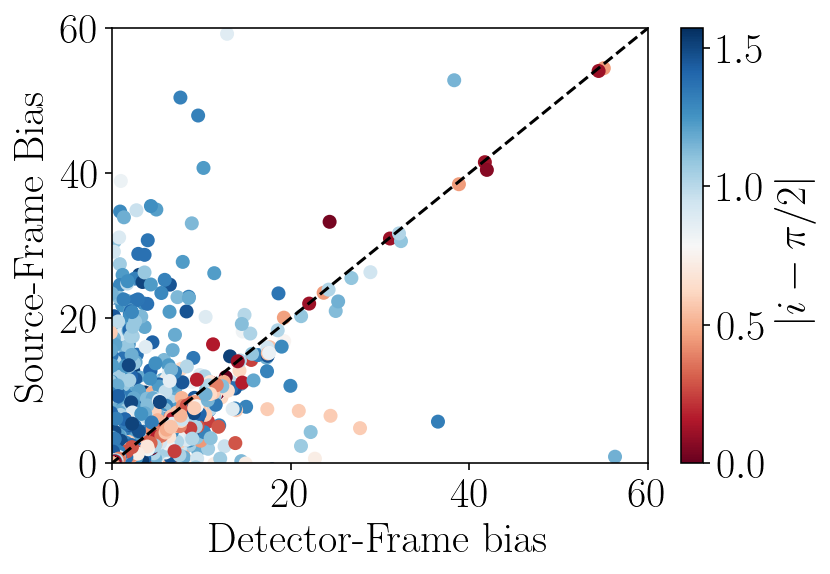

In [44]:
sc = plt.scatter((df["m1_det_bias"]/df["m1_det_err"]), (df["m1_src_bias"]/df["m1_src_err"]), c=np.abs(df["iota"]-np.pi/2), cmap="RdBu", vmin=0, vmax=np.pi/2)
cbar = plt.colorbar(sc)
cbar.set_label("$|i-\pi/2|$")

# sc = plt.scatter((df["m1_det_bias"]/df["m1_det_err"]), (df["m1_src_bias"]/df["m1_src_err"]), c=np.abs(df["DL_bias"]/df["DL"]), cmap="RdBu", vmin=-2, vmax=2)
# cbar = plt.colorbar(sc)
# cbar.set_label("$\Delta DL / DL$")

# sc = plt.scatter(df["iota"],(df["DL_bias"]/df["DL_err"]) , c=np.abs(df["iota"]-np.pi/2), cmap="RdBu", vmin=0, vmax=np.pi/2)


plt.xlabel("Detector-Frame bias")
plt.ylabel("Source-Frame Bias")
x = np.linspace(-60, 60, 10)
plt.plot(x,x, color='k', ls='--')
plt.xlim(0, 60)
plt.ylim(0, 60)

plt.show()

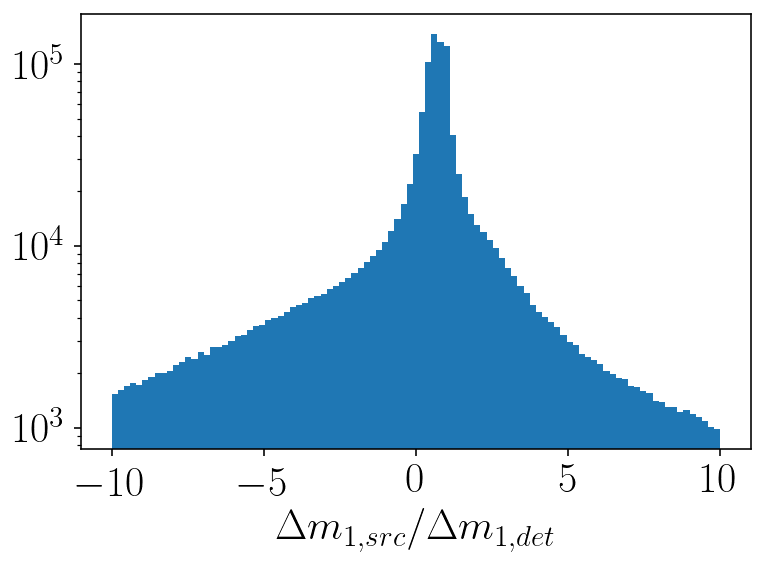

In [45]:
m1_src_bias = df["m1_src_bias"]/df["m1_src_err"]
m1_det_bias = df["m1_det_bias"]/df["m1_det_err"]
plt.hist(m1_src_bias/m1_det_bias, bins=np.linspace(-10, 10, 100))
plt.xlabel('$\Delta m_{1, src} / \Delta m_{1, det}$')
plt.semilogy()
plt.show()

# Hybr Features

## Hybr = 0.0 Median Biases

In [26]:
data = df[(df["hybr"]==0.0) & (df["snr"]>100)]
print(f"Average Mismatch = {1-np.average(data['faith']):.2e}")

Average Mismatch = 8.33e-04


In [27]:
snrs = [100, 200, 300]
# params= ["m1_src", "m2_src", "m_tot", "q", "chi1z", "chi2z", "z", "DL"]
params= ["m1_det", "m2_det", "m1_src", "m2_src", "q", "chi1z", "chi2z", "DL", "z"]

for i, param in enumerate(params):
    print()
    for j, snr in enumerate(snrs):
        data = df[(df["hybr"]==0.0) & (df["snr"]>snr)]
        biases = np.abs(data[param+"_bias"])/data[param+"_err"]
        biases = biases[~np.isnan(biases)]
        errs = data[param+"_err"]

        # abs_biases = np.abs(data[param+"_bias"])
        abs_biases = (data[param+"_bias"])
        abs_biases = abs_biases[~np.isnan(abs_biases)]

        rel_biases = np.abs(data[param+"_bias"])/data[param]
        rel_biases = rel_biases[~np.isnan(rel_biases)]
        print(param, f", snr > {snr}, median bias = {np.median(biases):.1f} $\sigma$, {np.median(abs_biases):.2f} units, err: {np.median(errs):.2f}, median injected val: {np.median(data[param]):.2f}")




m1_det , snr > 100, median bias = 0.3 $\sigma$, 0.22 units, err: 2.58, median injected val: 11.93
m1_det , snr > 200, median bias = 0.5 $\sigma$, 0.13 units, err: 1.08, median injected val: 8.93
m1_det , snr > 300, median bias = 0.6 $\sigma$, 0.11 units, err: 0.74, median injected val: 8.31

m2_det , snr > 100, median bias = 0.5 $\sigma$, -0.15 units, err: 0.95, median injected val: 8.33
m2_det , snr > 200, median bias = 0.6 $\sigma$, -0.08 units, err: 0.58, median injected val: 6.44
m2_det , snr > 300, median bias = 0.7 $\sigma$, -0.07 units, err: 0.44, median injected val: 6.15

m1_src , snr > 100, median bias = 0.3 $\sigma$, 0.16 units, err: 1.85, median injected val: 8.61
m1_src , snr > 200, median bias = 0.5 $\sigma$, 0.10 units, err: 0.92, median injected val: 7.66
m1_src , snr > 300, median bias = 0.6 $\sigma$, 0.08 units, err: 0.69, median injected val: 7.54

m2_src , snr > 100, median bias = 0.4 $\sigma$, -0.10 units, err: 0.95, median injected val: 6.04
m2_src , snr > 200, m

## SNR

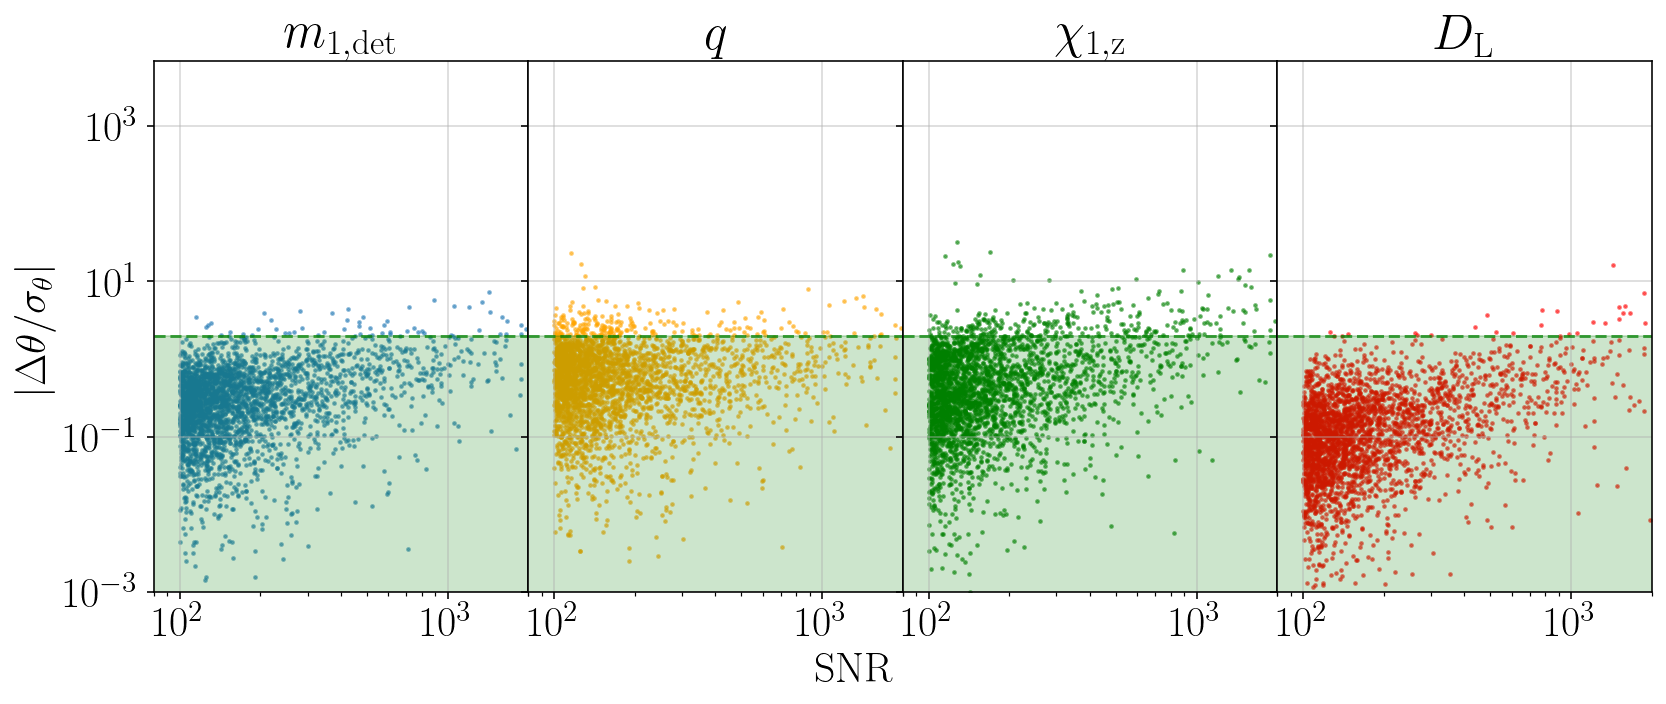

In [28]:
snr_lim = 100
params= ["m1_det", "q", "chi1z", "DL"]
cs = ["C0", "orange", "g", "red"]

fig, axes = plt.subplots(nrows=1, ncols=len(params), sharey=True, sharex=True, figsize=(12, 5))


data = df[(df["hybr"]==0.0) & (df["snr"]>snr_lim)]
for i, param in enumerate(params):
    axes[i].scatter(data["snr"], np.abs(data[param+"_bias"])/data[param+"_err"], s=2, color=cs[i], alpha=0.5)
    axes[i].set_xscale('log')
    axes[i].set_yscale('log')
    axes[i].set_ylim(1e-3, 7e3)
    axes[i].set_xlim(0.8e2, 2e3)
    
    axes[i].set_title(labels[param])

    axes[i].grid(alpha=0.5)
    # axes[i].xaxis.grid(True, which='minor')
    
    x = np.linspace(0, 1e5, 3)
    axes[i].axhline(y=2.0, c='g', ls='--', alpha=0.7)
    axes[i].fill_between(x, y1=0, y2=2.0, color='g', alpha=0.2)


axes[0].set_ylabel("$|{\Delta \\theta/\sigma_{\\theta}}|$")


plt.tight_layout()
plt.subplots_adjust(wspace=0)
plt.text(s="SNR", x=1.5, y=7e-5)


# plt.savefig('1D_bias_plots/hybr_0_bias_vs_snr.pdf', dpi=300)
plt.show()

### SNR at which median bias = 2\sigma

m1_det SNR for 2\sigma bias: 16736
m2_det SNR for 2\sigma bias: -248735
m1_src SNR for 2\sigma bias: -8173
m2_src SNR for 2\sigma bias: -7301
q SNR for 2\sigma bias: -20935
chi1z SNR for 2\sigma bias: 689
chi2z SNR for 2\sigma bias: 458


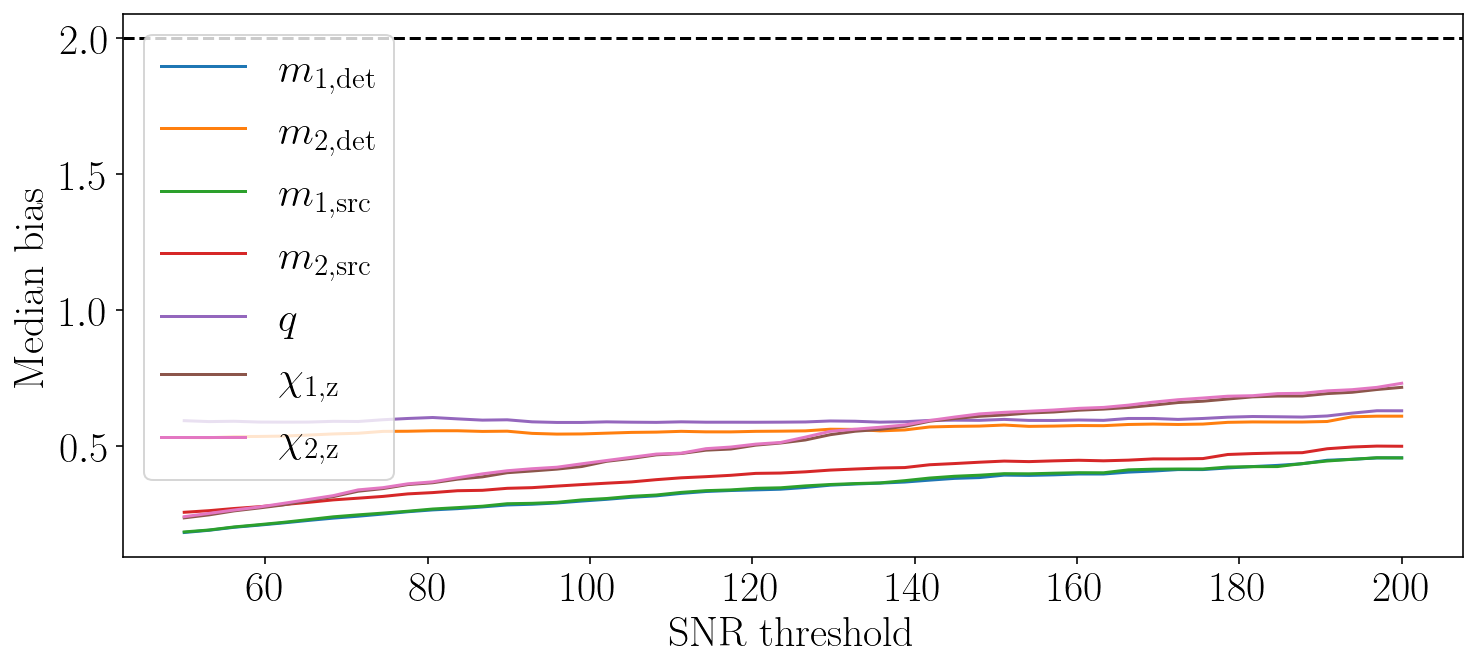

In [29]:
from scipy import interpolate

params= ["m1_det", "m2_det", "m1_src", "m2_src", "q", "chi1z", "chi2z"]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))

snr_lims = np.linspace(50, 200, 50)
med_biases = np.zeros(len(snr_lims))
for i, param in enumerate(params):
    for j, snr_lim in enumerate(snr_lims):
        data = df[(df["hybr"]==0.0) & (df["snr"]>snr_lim)]

        biases = np.abs(data[param+"_bias"])/data[param+"_err"]
        biases = biases[~np.isnan(biases)]
        med_biases[j] = np.median(biases)

    plt.plot(snr_lims, med_biases, label=labels[param])
    
    bias_interp = interpolate.interp1d(med_biases, snr_lims, fill_value='extrapolate')
    # plt.axvline(x= bias_interp(2), color='k', ls='--')
    print(param, "SNR for 2\sigma bias:", f"{bias_interp(2):.0f}")
plt.xlabel('SNR threshold')
plt.ylabel('Median bias')
plt.axhline(y=2, color='k', ls='--')
plt.legend()
# plt.semilogy()
plt.show()


m1_det SNR for 2\sigma bias: -13133
m2_det SNR for 2\sigma bias: 181
m1_src SNR for 2\sigma bias: 47
m2_src SNR for 2\sigma bias: 135
q SNR for 2\sigma bias: 179
chi1z SNR for 2\sigma bias: 104
chi2z SNR for 2\sigma bias: 606


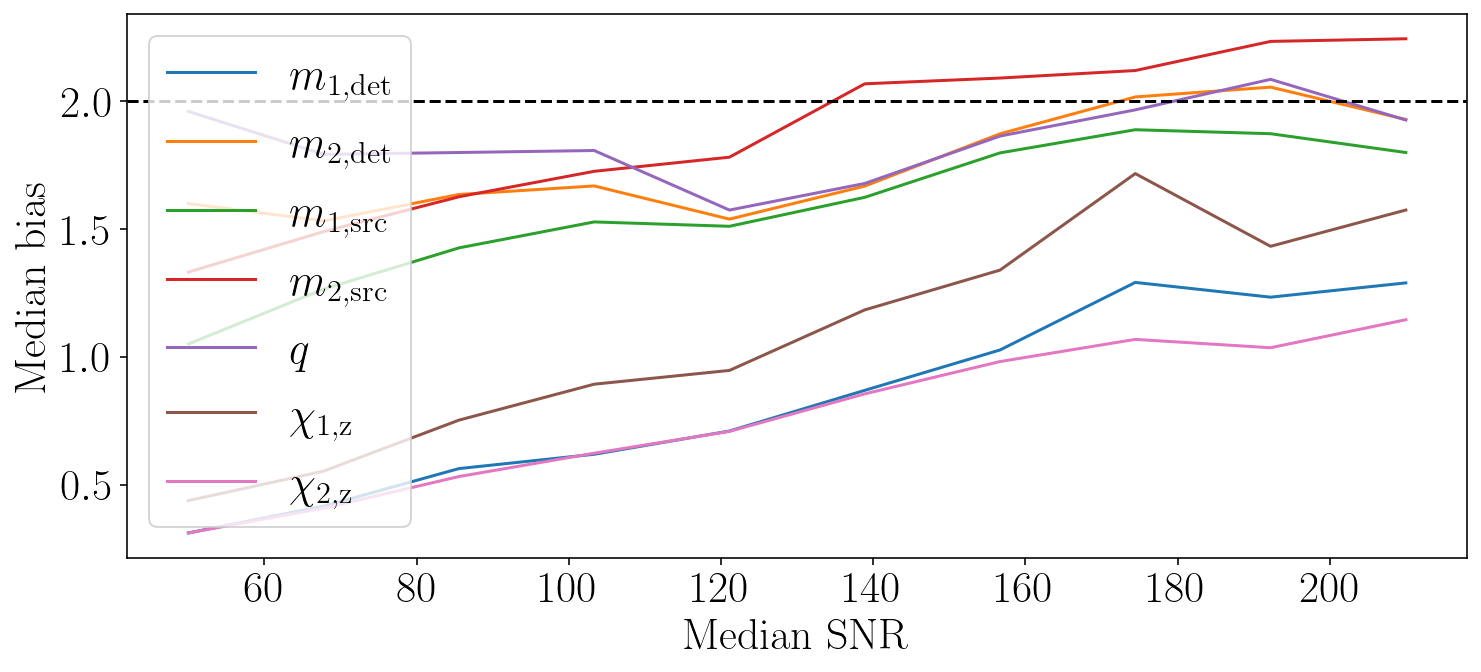

In [75]:
from scipy import interpolate

params= ["m1_det", "m2_det", "m1_src", "m2_src", "q", "chi1z", "chi2z"]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))

snr_lims = np.linspace(50, 210, 10)
med_biases = np.zeros(len(snr_lims))
for i, param in enumerate(params):
    for j, snr_lim in enumerate(snr_lims):
        data = df[(df["hybr"]==0.0) & (df["snr"]>snr_lim-10) & (df["snr"]<snr_lim+10)]

        biases = np.abs(data[param+"_bias"])/data[param+"_err"]
        biases = biases[~np.isnan(biases)]
        med_biases[j] = np.median(biases)

    plt.plot(snr_lims, med_biases, label=labels[param])
    
    bias_interp = interpolate.interp1d(med_biases, snr_lims, fill_value='extrapolate')
    # plt.axvline(x= bias_interp(2), color='k', ls='--')
    print(param, "SNR for 2\sigma bias:", f"{bias_interp(2):.0f}")
plt.xlabel('Median SNR')
plt.ylabel('Median bias')
plt.axhline(y=2, color='k', ls='--')
plt.legend()
# plt.semilogy()
plt.show()


### Theoretical Faithfulness requirement
from https://journals.aps.org/prd/abstract/10.1103/PhysRevD.95.104004

Faithfulness requirement:
$1-F \lt \frac{D}{2 SNR^2}$

$SNR \lt \sqrt{\frac{D}{2(1-F)}}$

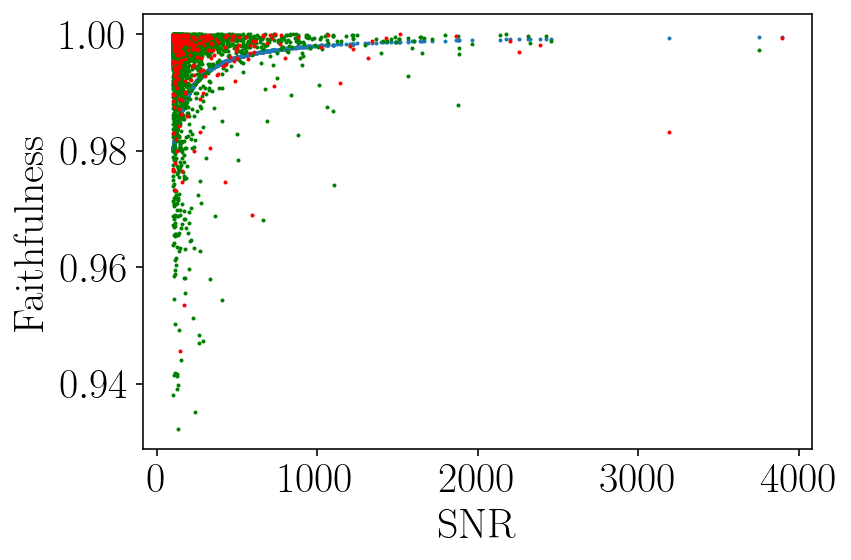

In [53]:
snr_lim = 100
data = df[(df["hybr"]==0.0) & (df["snr"]>snr_lim)]

snr_faith_lim = 1- np.sqrt(8/(2*data["snr"]**2))

vars=["m2_src"]
bias_mask = np.ones(len(data), dtype=bool)

for var in vars:
    bias_mask = bias_mask * (data[var+"_bias"]/ data[var+"_err"] > 1)


biased_data = data[bias_mask]
unbiased_data = data[~bias_mask]

# # unbiased_data = data[data[var+"_bias"]/ data[var+"_err"] < 1]

plt.scatter(data["snr"], snr_faith_lim, s=1, label="threshold")

plt.scatter(unbiased_data["snr"], unbiased_data["faith"], s=1, c='g')
plt.scatter(biased_data["snr"], biased_data["faith"], s=1, c='r')
plt.xlabel("SNR")
plt.ylabel("Faithfulness")
plt.show()



### figure out which events have large SNR but low bias

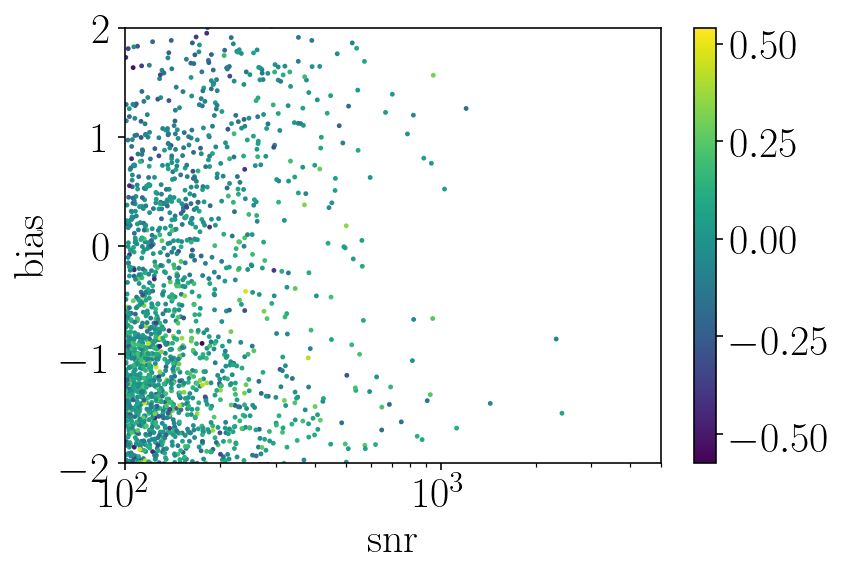

In [54]:
data = df[(df["hybr"]==0.0) & (df["snr"]>100)]
param="m1_src"


sc = plt.scatter(data["snr"], (data[param+"_bias"])/data[param+"_err"], s=2, c=data["chi2z"])
plt.colorbar(sc)

plt.xlim(100, 5000)
plt.ylim(-2, 2)

plt.semilogx()
plt.xlabel("snr")
plt.ylabel("bias")
plt.show()

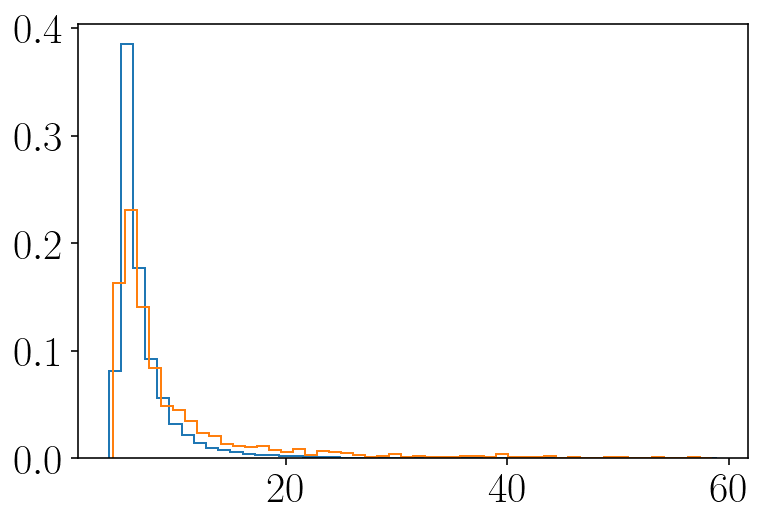

m1_src


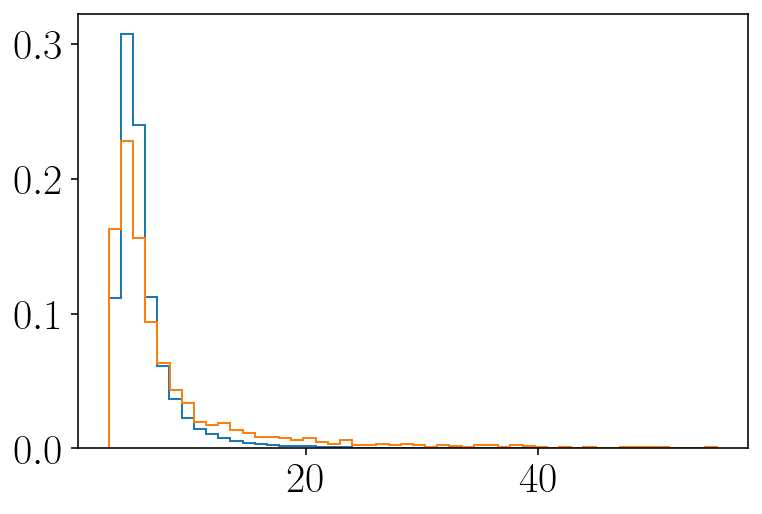

m2_src


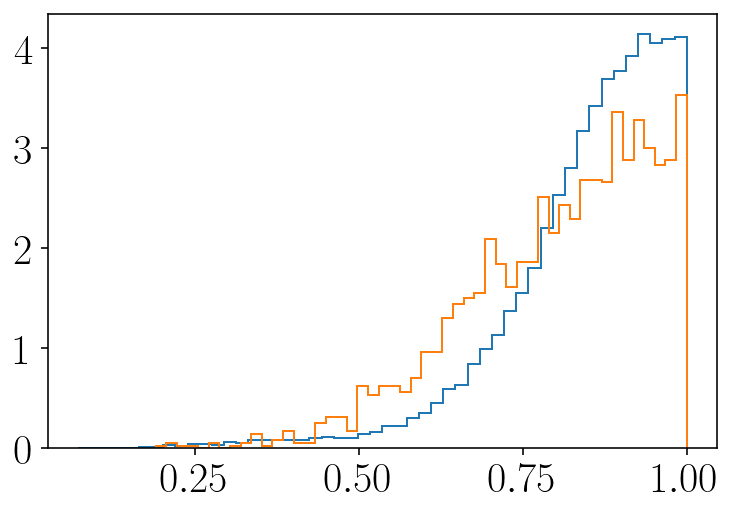

q


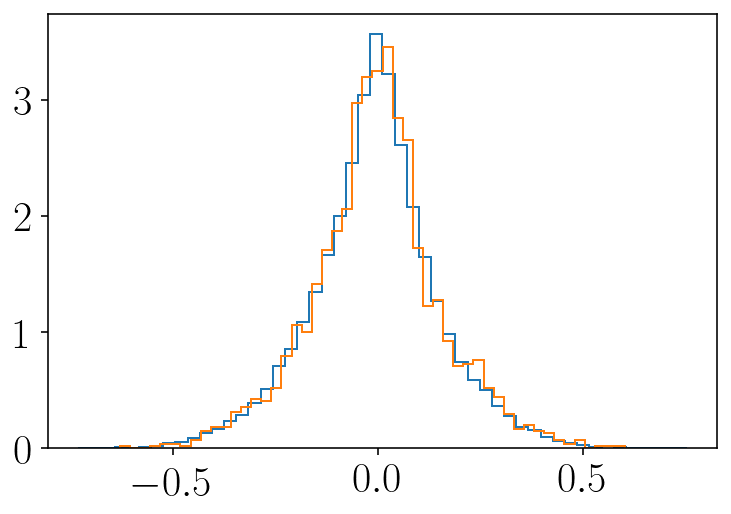

chi1z


In [88]:
bias_param = "q"
data_all = df[(df["hybr"]==0.0) & (df["snr"]>10) & ((df[bias_param+"_bias"] / df[bias_param+"_err"])<2)]
data_2 = df[(df["hybr"]==0.0) & (df["snr"]>100)& ((df[bias_param+"_bias"] / df[bias_param+"_err"])<2)]

params = ["m1_src", "m2_src", "q", "chi1z"]
for param in params:
    plt.hist(data_all[param], bins=50, histtype='step', density=True)
    plt.hist(data_2[param], bins=50, histtype='step', density=True)
    plt.show()
    print(param)

Seems like equal mass ratio binaries are the ones that survive high snrs.

## Avg Faithfulness

In [15]:
def plot_avg_vs_hybr(ax, df, quantity, x_qty="hybr", label="", **kwargs):
    hybrs = np.unique(df["hybr"])
    avg_qty = np.zeros_like(hybrs)
    x_data = np.zeros_like(hybrs)
    
    for i, hybr in enumerate(hybrs):
        mask = (df["hybr"]==hybr)
        avg_qty[i] = np.average(quantity[mask])
        x_data[i] = np.average(df[mask][x_qty])

    cs = CubicSpline(x_data, avg_qty)
    ax.scatter(x_data, avg_qty)
    x = np.linspace(0,1,50)
    ax.plot(x, cs(x), label=label)
    # ax.plot(x_data, avg_qty, label=label, **kwargs)


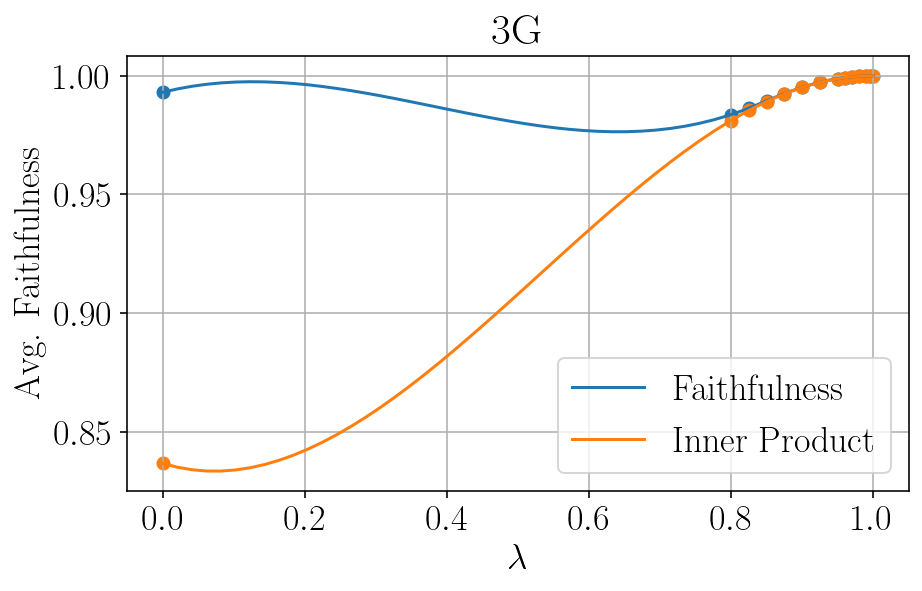

In [16]:
fig, ax = plt.subplots(figsize=(7, 4))


plot_avg_vs_hybr(ax, df, df["faith"], label="Faithfulness", lw=3)
plot_avg_vs_hybr(ax, df, df["inner_prod"], label="Inner Product", lw=3)


ax.set_xlabel("$\lambda$")
ax.set_ylabel("Avg. Faithfulness")
# plt.ylim(0.95, 1.0)
plt.grid()
# plt.loglog()
plt.title('3G')
plt.legend()
plt.show()

## Average bias vs Faithfulness

In [57]:
def bias_avg_var_plot(df, ax, hybrs=np.linspace(0.0, 1.0, 1), x_qty="hybr", xlabel='$\lambda$', title='', vars = ['Mc', 'eta', 'chi1z', 'chi2z', 'DL'],
                    legend_loc='upper right', snr_lim = None, labels=None, **kwargs):

    if snr_lim is not None:
        df = df[df["snr"]>snr_lim]
    
    for var in vars:
        x_data = np.zeros_like(hybrs)
        avg_qty = np.zeros_like(hybrs)
        x_data = np.zeros_like(hybrs)
        
        for i, hybr in enumerate(hybrs):
            mask = (df["hybr"]==hybr)
            df_hybr = df[mask]
            quantity = np.abs(df_hybr[f"{var}_bias"]/df_hybr[f"{var}_err"])
            avg_qty[i] = np.average(quantity)
            x_data[i] = np.average(df_hybr[x_qty])

        if labels is None:
            ax.plot(x_data, avg_qty, **kwargs)
        else:
            ax.plot(x_data, avg_qty, label=labels[var], **kwargs)
        

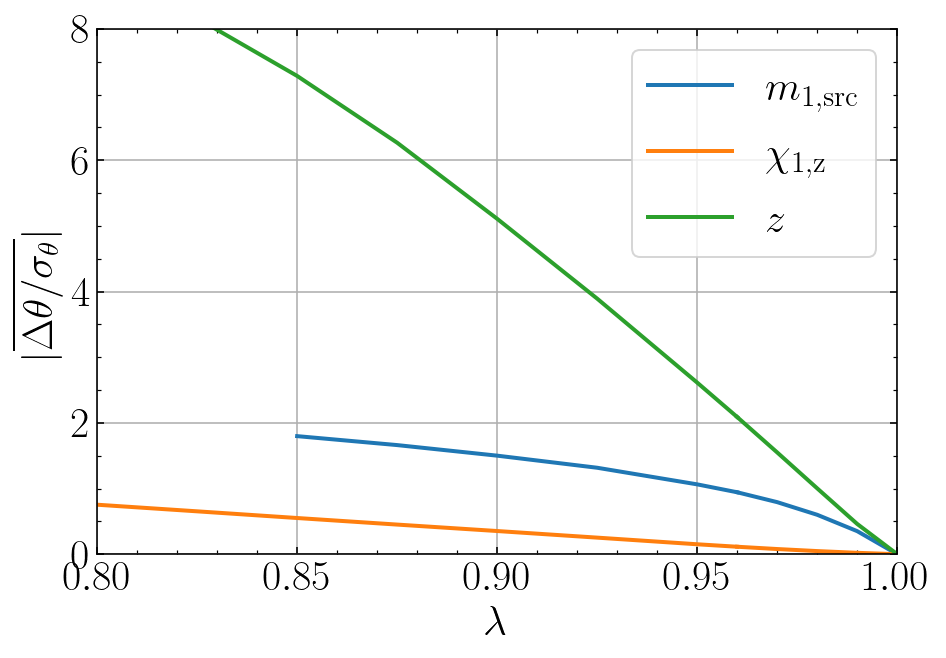

In [58]:
hybrs = np.unique(df["hybr"])

# vars = ['Mc', 'eta', 'chi1z', 'chi2z', 'DL']
# vars = ['m1', 'm2', 'chi1z', 'chi2z', 'DL']
# vars = ['m1', 'm2', 'chi_eff', 'DL']
vars = ['m1_src', 'chi1z', 'z']

# vars = ["Mc"]




snr_lim=50

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 5))


#
bias_avg_var_plot(df, ax, hybrs[:9], vars=vars, title='3G', labels=None, snr_lim=snr_lim,
                lw=2, linestyle='-')
ax.set_prop_cycle(None)
bias_avg_var_plot(df, ax, hybrs[8:], vars=vars, title='3G', labels=labels, snr_lim=snr_lim,
                lw=2)

ax.set_xlim(0.8, 1.0)
ax.set_ylim(0, 8)


ax.set_xlabel("$\lambda$")
ax.set_ylabel("$|\overline{\Delta \\theta/\sigma_{\\theta}}|$")

plt.legend(loc='upper right')

plt.grid(which='major')
plt.minorticks_on()
plt.tick_params(which='both', direction='in', tick2On=True)

plt.tight_layout()
# plt.savefig('1D_bias_plots/3g_pop_bias_sig_vs_lambda.pdf', dpi=300)

plt.show()

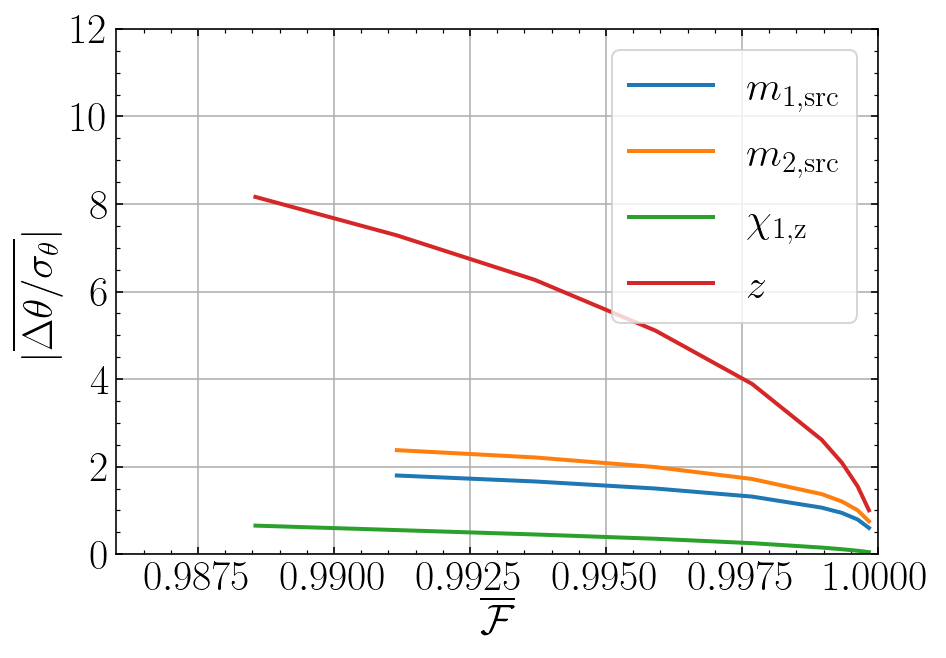

In [59]:
hybrs = np.unique(df["hybr"])[2:]

# vars = ['Mc', 'eta', 'chi1z', 'chi2z', 'DL']
# vars = ['m1', 'm2', 'chi1z', 'chi2z', 'DL']
# vars = ['m1', 'm2', 'z']
# vars = ['m1', 'm1_src', 'z']
vars = ['m1_src','m2_src', 'chi1z', 'z']

# vars = ["Mc"]

snr_lim = 50
n_sigma = 2
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 5))


bias_avg_var_plot(df, ax, hybrs[:9], x_qty="faith", vars=vars, title='3G', labels=labels, snr_lim=snr_lim,
                lw=2, linestyle='-')


ax.set_xlabel("$\overline{\mathcal{F}}$")
ax.set_ylabel("$|\overline{\Delta \\theta/\sigma_{\\theta}}|$")

plt.legend(loc='upper right')

plt.grid(which='major')
plt.minorticks_on()
plt.tick_params(which='both', direction='in', tick2On=True)

ax.set_ylim(0, 12)
ax.set_xlim(0.986, 1.0)

plt.tight_layout()
# plt.savefig('1D_bias_plots/3g_pop_bias_sig_vs_faith.pdf', dpi=300)

plt.show()

## % of Biased events from Total Population

In [29]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from scipy.interpolate import make_interp_spline
from scipy.interpolate import splrep, BSpline

def bias_perc_plot(df, ax, hybrs, axins=None, n_sigma=1.0, x_qty="hybr", xlabel='$\lambda$', title='', vars = ['Mc', 'eta', 'chi1z', 'chi2z', 'DL'], snr_factor = 1.0,
                    legend_loc='upper right', snr_lim = None, labels=None, **kwargs):

    snr_cut_str = " "
    if snr_lim is not None:
        df = df[df["snr"]>snr_lim]
        snr_cut_str = f"SNR>{snr_lim:.1f}"
    

    for var in vars:
        x_data = np.zeros_like(hybrs)
        bias_perc = np.zeros_like(hybrs)
        bias_num = np.zeros_like(hybrs)
        for i, hybr in enumerate(hybrs):
            df_hybr = df[df["hybr"]==hybr]
            x_data[i] = np.average(df_hybr[x_qty])

            data = snr_factor* df_hybr[f"{var}_bias"]/df_hybr[f"{var}_err"]
            bias_perc[i] = 100* np.sum(np.abs(data)>n_sigma) / len(data)
            bias_num[i] = np.sum(np.abs(data)>n_sigma)

        if labels is None:
            ax.plot(1-x_data, bias_perc, **kwargs)
        else:
            # cs = interpolate.interp1d(x_data, bias_perc)

            x = np.linspace(x_data[0], x_data[-1], 10000)
            # ax.plot(1-x, cs(x), label=labels[var], **kwargs)

            tck = splrep(x_data, bias_perc, s=0.02)
            ax.plot(1-x, BSpline(*tck)(x), label=labels[var], **kwargs)

            # ax.scatter(1-x_data, bias_perc, label=labels[var], **kwargs)

            if axins is not None:
                axins.plot(1-x, BSpline(*tck)(x), label=labels[var], **kwargs)
                # axins.plot(1-x_data, bias_perc, **kwargs)


            
       
            
        

    ax.set_xlabel(xlabel)
    # ax.set_ylabel(f"Biased Events (%)")
    # ax.set_title(f"{title} Bias Percentage ($\geq${n_sigma}$\sigma$)")

In [30]:
# hybrs = np.unique(df["hybr"])

# # vars = ['Mc', 'eta', 'chi1z', 'chi2z', 'DL']
# # vars = ['m1', 'm2', 'chi1z', 'chi2z', 'DL']
# # vars = ['m1', 'm2', 'chi_eff', 'DL']
# vars = ['m1_det', 'q', 'chi1z', 'z']

# # vars = ["Mc"]




# snr_lim= 50
# n_sigma = 2
# fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 5))

# bias_perc_plot(df, ax, hybrs[:], n_sigma=n_sigma, vars=vars, title='3G', labels=labels, snr_lim=snr_lim,
#                 lw=2, linestyle='-')

# # ax.set_ylim(0, 60)
# ax.set_xlim(0.95, 1.0)
# # ax.set_xscale('log')

# ax.set_ylabel('$\geq 2\sigma$ Bias (\%)')
# ax.set_xlabel("$\lambda$")

# plt.legend(loc='upper right')

# plt.grid(which='major', alpha=0.5)
# plt.minorticks_on()
# plt.tick_params(which='both', direction='in', tick2On=True)



# plt.tight_layout()
# # plt.savefig('1D_bias_plots/3g_pop_percentage_vs_lambda.pdf', dpi=300)

# plt.show()

/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars


error: (xe>=x[m-1]) failed for 2nd keyword xe: curfit:xe=nan

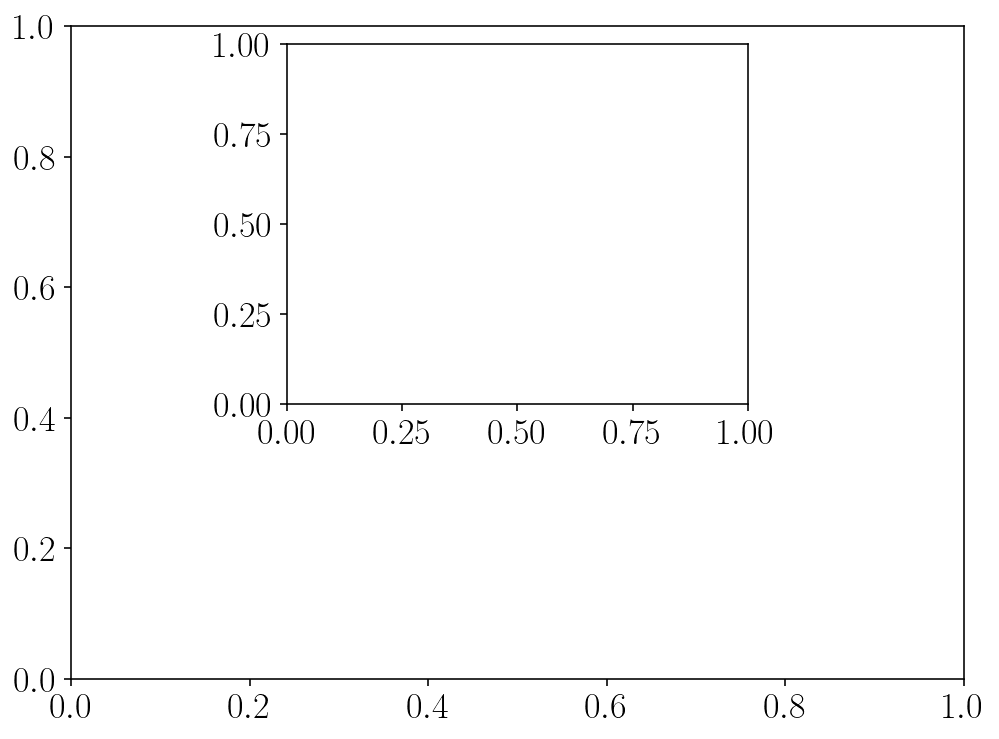

In [31]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.ticker import MaxNLocator

from cycler import cycler

# hybrs = np.unique(df["hybr"])[:]
hybrs = [ 0.0, 0.95, 0.96, 0.97, 0.98, 0.99, 0.995, 1.0]

# vars = ['Mc', 'eta', 'chi1z', 'chi2z', 'DL']
# vars = ['m1', 'm2', 'chi1z', 'chi2z', 'DL']
# vars = ['m1', 'm2', 'chi_eff', 'DL']
# vars = ['m1_src', 'm2_src',  'q', 'm_tot', 'chi1z', 'chi2z', 'DL']
vars = ['m1_det', 'm2_det', 'chi1z', 'chi2z', 'DL', 'm1_src','m2_src']

custom_cycler = (cycler(color=['tab:blue', 'tab:orange',  'tab:green', 'tab:purple', 'tab:red', 'tab:blue', 'tab:orange']) 
                 + cycler(linestyle=['-', '-', '-', '-','-.', '-.', '-.'])
                 )

snr_lim= 100
n_sigma = 2


fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 6))

axins = inset_axes(ax, width=3.2, height=2.5, loc=9)

ax.set_prop_cycle(custom_cycler)
axins.set_prop_cycle(custom_cycler)

bias_perc_plot(df, ax, hybrs[:], axins=axins, n_sigma=n_sigma, x_qty="faith", xlabel="Avg Faithfulness", vars=vars, title='3G', labels=labels, snr_lim=snr_lim,
                lw=3)


ax.axhline(y=5, ls='--', lw=2, color='k')
axins.axhline(y=5, ls='--', lw=2, color='k')

ax.set_ylim(0, 2.4e1)
ax.set_xlim(0, 2.8e-3)

ax.set_ylabel(f'$\geq {n_sigma}\sigma$ Bias (\%)')
ax.set_xlabel("$\overline{\mathcal{M}}$")

ax.legend(bbox_to_anchor=(1.02, 1.02), loc='upper left', ncol=1)

# ax.xaxis.set_major_locator(MaxNLocator(prune='lower'))
ax.tick_params(axis='x', pad=15)

ax.grid(which='major', alpha=0.5)
ax.minorticks_on()
ax.tick_params(which='both', direction='in', tick2On=True)
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0), useMathText=True)


axins.set_xlim(0, 3e-5) # Limit the region for zoom
axins.set_ylim(0, 15)
# axins.set_xscale('log')

axins.grid(which='major', alpha=1)
axins.minorticks_on()
axins.tick_params(which='both', direction='in', tick2On=True)
axins.set_facecolor("#fffffc")
axins.yaxis.set_tick_params(labelleft=False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.4", ls='-')


plt.tight_layout

# plt.savefig('1D_bias_plots/3g_pop_percentage_vs_faith.pdf', dpi=300, bbox_inches='tight')
plt.show()


/opt/anaconda3/envs/gwbench/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars


error: (xe>=x[m-1]) failed for 2nd keyword xe: curfit:xe=nan

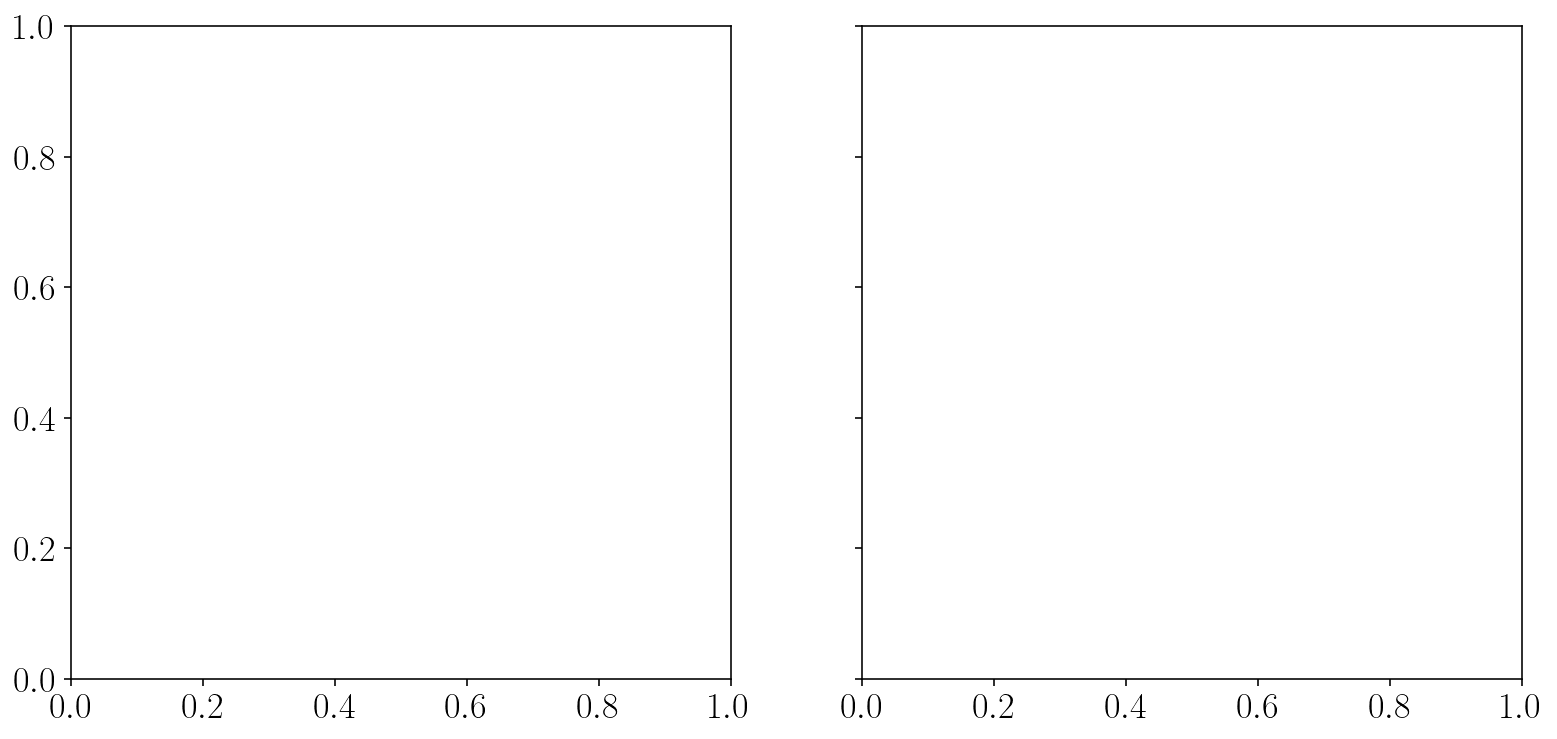

In [32]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.ticker import MaxNLocator

from cycler import cycler

# hybrs = np.unique(df["hybr"])[:]
hybrs = [ 0.0, 0.95, 0.96, 0.97, 0.98, 0.99, 0.995, 1.0]

# vars = ['Mc', 'eta', 'chi1z', 'chi2z', 'DL']
# vars = ['m1', 'm2', 'chi1z', 'chi2z', 'DL']
# vars = ['m1', 'm2', 'chi_eff', 'DL']
# vars = ['m1_src', 'm2_src',  'q', 'm_tot', 'chi1z', 'chi2z', 'DL']
vars = ['DL', 'm1_src','m2_src', 'm1_det', 'm2_det', 'chi1z', 'chi2z']
vars2 = ['DL', 'm1_src','m2_src']

custom_cycler = (cycler(color=['tab:red', 'tab:blue', 'tab:orange', 'tab:blue', 'tab:orange',  'tab:green', 'tab:purple']) 
                 + cycler(linestyle=['-.', '-.', '-.','-', '-', '-', '-'])
                 )

snr_lim= 100
n_sigma = 2


fig, [ax, ax2] = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(13, 6))


ax.set_prop_cycle(custom_cycler)

bias_perc_plot(df, ax, hybrs[:], n_sigma=n_sigma, x_qty="faith", xlabel="Avg Faithfulness", vars=vars, title='3G', labels=labels, snr_lim=snr_lim,
                lw=3)


ax.axhline(y=5, ls='--', lw=2, color='k')

ax.set_xlim(0, 3e-3)
ax.set_ylim(0, 20)
ax.tick_params(axis='x', pad=15)

ax.grid(which='major', alpha=0.5)
ax.minorticks_off()
ax.tick_params(which='both', direction='in', tick2On=True)
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0), useMathText=True)

ax.legend(loc='upper right', ncol=3)

ax.set_ylabel(f'$\geq {n_sigma}\sigma$ Bias (\%)')
ax.set_xlabel("$\overline{\mathcal{M}}$")



custom_cycler2 = (cycler(color=['tab:red', 'tab:blue', 'tab:orange']))
ax2.set_prop_cycle(custom_cycler2)

bias_perc_plot(df, ax2, hybrs[:], n_sigma=n_sigma, x_qty="faith", xlabel="Avg Faithfulness", vars=vars2, title='3G', labels=labels, snr_lim=snr_lim, ls='-.',
                lw=3)

ax2.axhline(y=5, ls='--', lw=2, color='k')

ax2.set_xlim(0, 3e-5) # Limit the region for zoom
ax2.set_ylim(0, 20)

ax2.grid(which='major', alpha=0.5)
ax2.minorticks_off()
ax2.tick_params(which='both', direction='in', tick2On=True)
ax2.ticklabel_format(axis='x', style='sci', scilimits=(0,0), useMathText=True)
ax2.tick_params(axis='x', pad=15)

ax2.legend(loc='upper right', ncol=1)

# ax2.set_ylabel(f'$\geq {n_sigma}\sigma$ Bias (\%)')
ax2.set_xlabel("$\overline{\mathcal{M}}$")

plt.tight_layout()

# plt.savefig('1D_bias_plots/3g_pop_percentage_vs_faith.pdf', dpi=300, bbox_inches='tight')
plt.show()


# Relative Bias Histograms

In [30]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 22
})

In [31]:
def bias_hist_plot(df, ax, hybr='0.9', title='', vars = ['Mc', 'eta', 'chi1z', 'chi2z', 'DL'], n_sigma=2.0, snr_factor = 1.0,
                    bins=30, legend_loc='upper right', snr_lim = None ,kde=False, labels=None, 
                    hyb_text = True, hyb_text_x=-18, hyb_text_y=2.7, 
                    faith_text = True, faith_text_x=-18, faith_text_y=1.0, **kwargs):
    mask = (df['hybr']==hybr)

    snr_cut_str = " "
    if snr_lim is not None:
        mask = mask & (df["snr"]>snr_lim)
        snr_cut_str = f"SNR>{snr_lim:.1f}"
    
    df = df[mask]

    for var in vars:
        data = snr_factor* df[f"{var}_bias"]/df[f"{var}_err"]
        bias_num = np.sum(np.abs(data)>n_sigma)
        bias_perc = 100* np.sum(np.abs(data)>n_sigma) / len(data)
        if labels is None:
            label=var + f" ({bias_perc:.1f}\% biased)"
        else:
            # label = labels[var] + "  ($N_{\\rm bias}$ = " + f"{bias_num})"
            label = labels[var] + f" ({bias_perc:.1f}\% biased)"
        if not kde:
            ax.hist(data, bins=bins, histtype='step', label=label, **kwargs)
        else:
            sns.kdeplot(data=data, ax=ax, bw_adjust=1, gridsize=1000, label=label)

    # ax.set_xlabel("$\Delta \\theta / \sigma_{\\theta}$")
    # ax.set_title(title)
    if hyb_text:
        ax.text(hyb_text_x, hyb_text_y, f'$\lambda$={hybr:.2f}', fontsize=20)
    
    if faith_text:
        faith = np.average(df["faith"])
        ax.text(faith_text_x, faith_text_y, "$\overline{\mathcal{M}} = $"+f" {1-faith:.1e}", fontsize=20)

    ax.legend(loc=legend_loc, fontsize=20)
    
    # ticks
    ax.tick_params(labelbottom=False, direction="in", which='major', length=5.0, width=1.0, top=True)



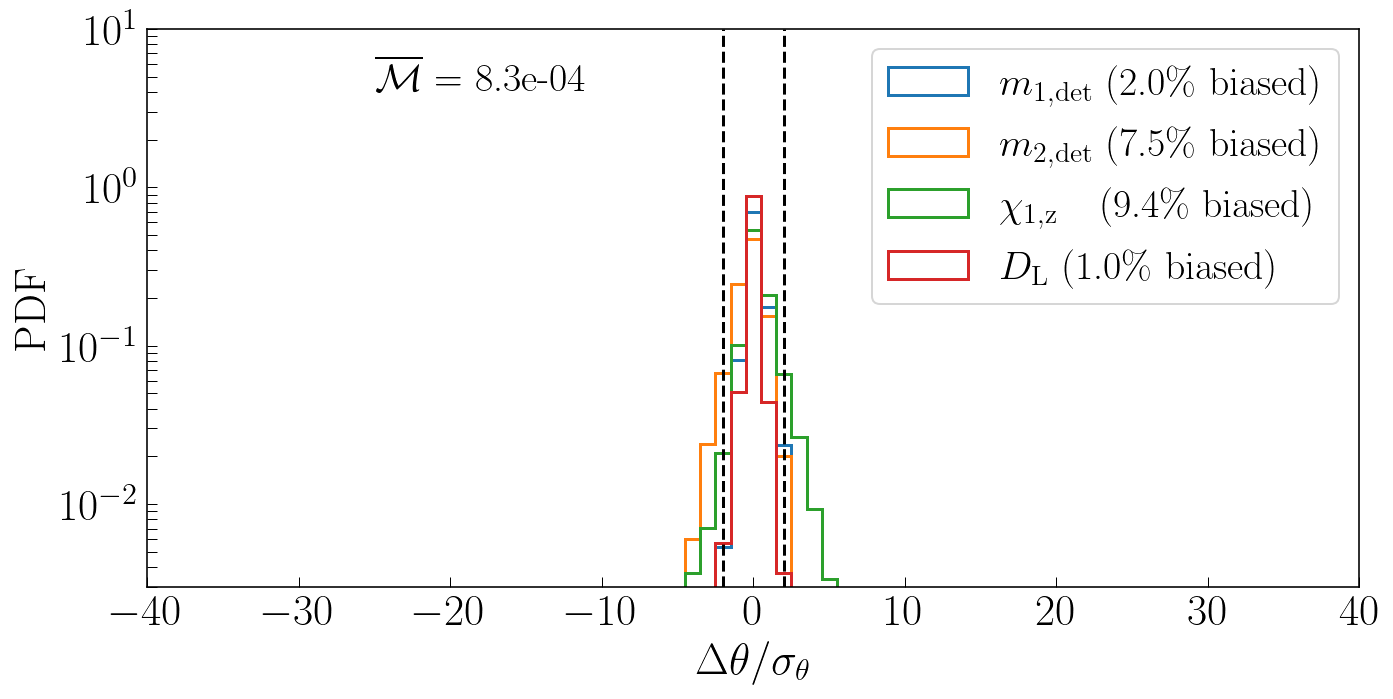

In [32]:
hybr=0.0
fig, ax = plt.subplots(ncols=1, nrows=1, sharex=True, figsize=(10, 5))

# vars = ['m1_src', 'q']
# vars = ['m1', 'm2', 'chi1z', 'chi2z', 'DL']
vars = ['m1_det', 'm2_det', 'chi1z', 'DL']
# vars = ['m1_src', 'm2_src', 'chi1z', 'DL']
# vars = ['Mc']


bins=np.linspace(-100, 100, 200)
# bins=30

snr_lim= 100

bias_hist_plot(df, ax, hybr=hybr, title='', n_sigma=2.0, vars=vars, bins=bins, labels=labels, snr_lim=snr_lim,
               hyb_text=False, faith_text=True, hyb_text_x=-25, faith_text_x=-25, faith_text_y=4,
            lw=1.5, density=True, kde=False)


# ax.text(x=-5, y=-1, s="IMRPhenomXAS", fontsize=18)


ax.axvline(x=2, color='k', ls='--')
ax.axvline(x=-2, color='k', ls='--')

ax.set_xlim(-40, 40)
ax.minorticks_off()
ax.set_ylim(0.003, 10)
ax.set_yscale('log')

ax.set_ylabel('PDF')

    
plt.xlabel("$\Delta \\theta / \sigma_{\\theta}$")
plt.tight_layout()

ax.tick_params(labelbottom=True, direction="in", length=5.0, width=.5, which="both", top=False)

# plt.savefig('1D_bias_plots/3g_pop_bias_histogram_hybr_0.pdf', dpi=300)

plt.show()

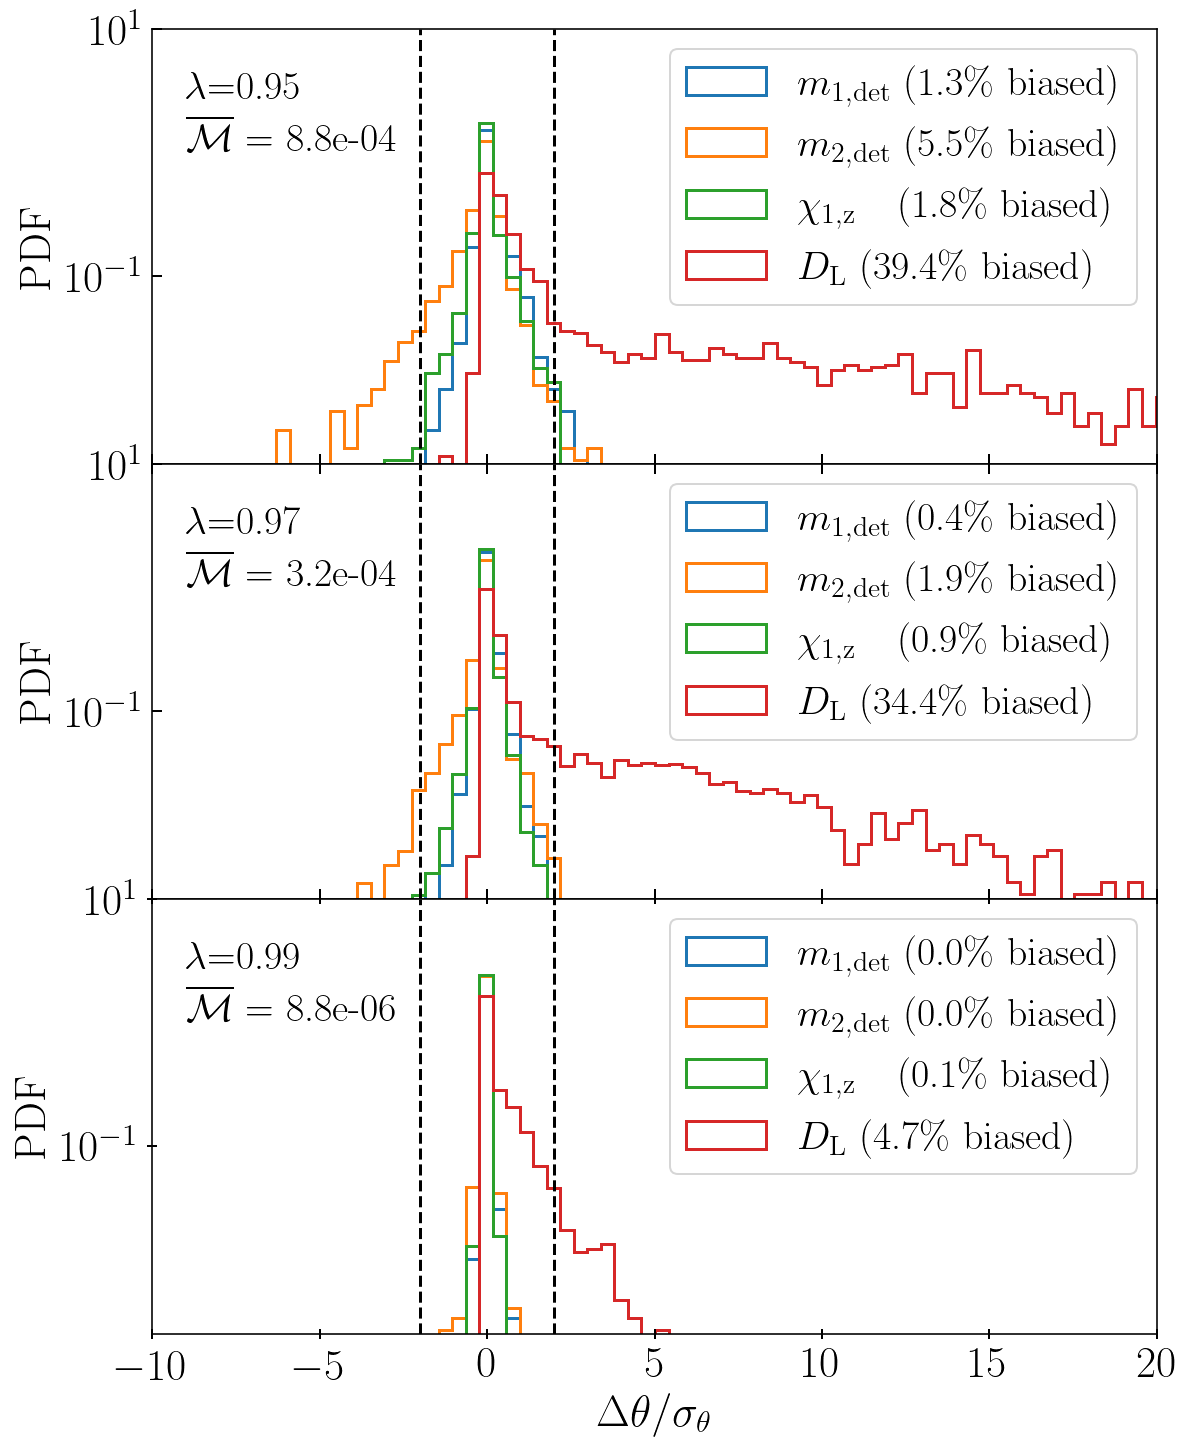

In [104]:
# hybrs = np.unique(df["hybr"])
hybrs = [0.95, 0.97, 0.995]

fig, axes = plt.subplots(ncols=1, nrows=len(hybrs), sharex=True, figsize=(9, 4*len(hybrs)))

# vars = ['m1_src', 'q']
# vars = ['m1', 'm2', 'chi1z', 'chi2z', 'DL']
# vars = ['m1', 'm2', 'chi_eff', 'DL']
vars = ['m1_det', 'm2_det', 'chi1z', 'DL']



bins=np.linspace(-16, 24, 100)
# bins=30

snr_lim= 100

for i, hybr in enumerate(hybrs):
    bias_hist_plot(df, axes[i], hybr=hybr, title=f'$\lambda$={hybr:.3f}', n_sigma=2.0, vars=vars, bins=bins, labels=labels, snr_lim=snr_lim,
                 hyb_text_x=-9, faith_text_x=-9,
                lw=1.5, density=True, kde=False)

axes[0].tick_params(labelbottom=False, direction="in", which='both', length=5.0, width=1.0, top=False)
axes[-1].tick_params(labelbottom=True, direction="inout", length=5.0, width=1.0, which="both", top=True)


for ax in axes:
    ax.axvline(x=2, color='k', ls='--')
    ax.axvline(x=-2, color='k', ls='--')
    ax.set_xlim(-10, 20)
    ax.set_ylim(0.0, 3.5)
    ax.minorticks_off()
    ax.set_ylim(0.003, 10)
    ax.set_yscale('log')
    ax.set_ylabel('PDF')
    
plt.xlabel("$\Delta \\theta / \sigma_{\\theta}$")

plt.subplots_adjust(hspace=.0)

# plt.tight_layout()

# plt.savefig('1D_bias_plots/3g_pop_bias_histograms.pdf', dpi=300)

plt.show()

### mini-investigation: why is m1 bias negative for $\lambda=0$ but positive for $\lambda=1$ ?

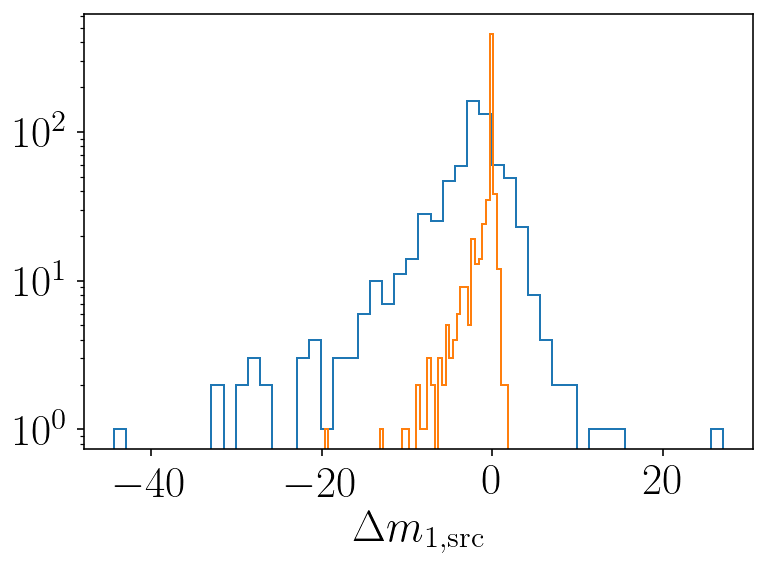

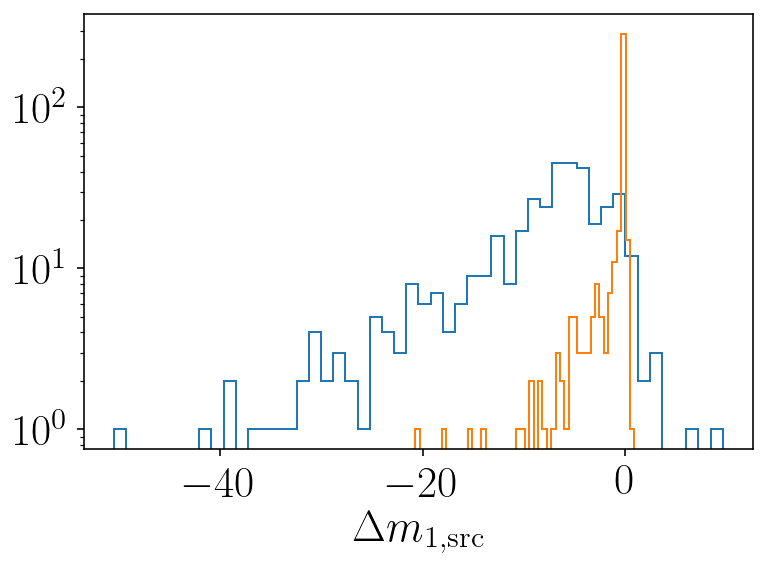

In [278]:
bins = 50

data = df[(df["hybr"]==0.0) & (df["snr"]>100) & (df["q"]>0.9)]
plt.hist(data["m1_src_bias"], bins=bins, histtype='step');

data = df[(df["hybr"]==0.99) & (df["snr"]>100) & (df["q"]>0.9)]
plt.hist(data["m1_src_bias"],bins=bins, histtype='step');

plt.xlabel("$\Delta m_{1, \\rm src}$")

plt.semilogy()
plt.show()


data = df[(df["hybr"]==0.0) & (df["snr"]>100) & (df["q"]<0.5)]
plt.hist(data["m1_src_bias"], bins=bins, histtype='step');

data = df[(df["hybr"]==0.99) & (df["snr"]>100) & (df["q"]<0.5)]
plt.hist(data["m1_src_bias"],bins=bins, histtype='step');

plt.xlabel("$\Delta m_{1, \\rm src}$")

plt.semilogy()
plt.show()


As we go from IMRPhenomD to IMRPhenomXAS, the differences in the extreme mass-ratio binaries are huge. Going from one to the other, I can check which part of the waveform disagree wildly (inspiral vs merger). That might give some hint as to what's going on. If the hybrid waveforms have some behavior that makes them mimic more high mass 

# Identify 3 interesting Binaries to study with Bayesian PE

In [33]:
import scipy.stats as stats

def plot_bias(index, vars, labels, hybr=0.0, hybr_2=None):
    fig, axes = plt.subplots(ncols=1, nrows=len(vars), figsize=(8, 3*len(vars)))
    ax = list(axes)
    
    df_bias = df[(df["hybr"]==hybr) * df["index"]==index]
    if hybr_2 is not None:
        df_2_bias = df[(df["hybr"]==hybr_2) * df["index"]==index]

    for i, param in enumerate((vars)):
        mu = df_bias[param]
        sigma = df_bias[param+"_err"]
        bias = df_bias[param+"_bias"]

        x = np.linspace(mu-3*bias, mu+3*bias, 10000)
        if (param == 'chi1z' or param == 'chi2z'):
            x = np.linspace(-1, 1, 10000)
        if (param == 'q'):
            x = np.linspace(0, 1, 10000)
        if (param == 'eta'):
            x = np.linspace(0, 0.25, 10000)
        if (param == 'DL' or param == 'z' or param=='Mc' or param=='m1_det' or param=='m1_src' or param=='m2_det' or param=='m2_src'):
            x = np.linspace(np.maximum(0, mu-np.abs(3*bias)), mu+np.abs(3*bias), 10000)

        inj_est = stats.norm.pdf(x, mu, sigma)
        inj_est = inj_est/np.sum(inj_est)

        biased_est = stats.norm.pdf(x, mu+bias, sigma)
        biased_est = biased_est/ np.sum(biased_est)

        # print(bias/sigma)
        
        ax[i].plot(x, inj_est, label=f"Injected (IMRPhenomXAS)", color='k', lw=2)
        ax[i].plot(x, biased_est, label=f"Recovered (IMRPhenomD)",color='r', lw=2)

        if hybr_2 is not None:
            bias_2 = df_2_bias[param+"_bias"]
            biased_est_2 = stats.norm.pdf(x, mu+bias_2, sigma)
            biased_est_2 = biased_est_2/ np.sum(biased_est_2)
            ax[i].plot(x, biased_est_2, label=f"Hybrid ($\lambda=${hybr_2:.2f})",color='orange', lw=2)

        ax[i].set_xlabel(labels[param])
        ax[i].set_ylabel(f"p({labels[param]})")
        
        if i==0:
            ax[i].legend(bbox_to_anchor=(1.1, 1), fontsize=14)


    # plt.suptitle( " Systematic Bias \n IMRPhenomXAS and IMRPhenomD", y=1.02, fontsize=20)
    plt.tight_layout()
    plt.show()

In [34]:
def plot_bias_hybrs(index, vars, labels, hybrs=[0.0, 0.8, 1.0]):
    fig, axes = plt.subplots(ncols=len(hybrs), nrows=len(vars), figsize=(15, 3*len(vars)))
    ax = list(axes)
    
    for j, hybr in enumerate(hybrs):
        df_bias = df[(df["hybr"]==hybr) * df["index"]==index]

        for i, param in enumerate((vars)):
            mu = df_bias[param]
            sigma = df_bias[param+"_err"]
            bias = df_bias[param+"_bias"]

            x = np.linspace(mu-3*sigma, mu+3*sigma, 10000)
            if (param == 'chi1z' or param == 'chi2z'):
                x = np.linspace(-1, 1, 10000)
            if (param == 'q'):
                x = np.linspace(0, 1, 10000)
            if (param == 'eta'):
                x = np.linspace(0, 0.25, 10000)
            if (param == 'DL' or param == 'z' or param=='Mc' or param=='m1_det' or param=='m1_src' or param=='m2_det' or param=='m2_src'):
                x = np.linspace(np.maximum(0, mu-np.abs(3*sigma)), mu+np.abs(2*sigma)+ np.abs(2*bias), 10000)

            inj_est = stats.norm.pdf(x, mu, sigma)
            inj_est = inj_est/np.sum(inj_est)

            biased_est = stats.norm.pdf(x, mu+bias, sigma)
            biased_est = biased_est/ np.sum(biased_est)

            ax[i][j].plot(x, inj_est, label=f"Injected (IMRPhenomXAS)", color='k', lw=2)
            ax[i][j].plot(x, biased_est, label=f"Recovered (IMRPhenomD)", color='r', lw=2)
            ax[i][j].set_xlabel(labels[param])
            ax[i][j].set_ylabel(f"p({labels[param]})")
            
            if i==0:
                ax[i][j].set_title(f"$\lambda$={hybr}")
                if j==len(hybrs)-1:
                    ax[i][j].legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=14)


    plt.suptitle( " Systematic Bias \n IMRPhenomXAS and IMRPhenomD", y=1.02, fontsize=20)
    plt.tight_layout()
    plt.show()

### Golden Binary ($m_1 \sim 37 M_\odot$, $q \sim 0.8$, $\chi_{1,z} \sim 0$, $\chi_{2,z} \sim 0.02$, z $\sim 0.34$, SNR $\sim 725$): 54837

It's like GW150914, but DL = 1900 Mpc instead of 400 Mpc. So all biases would be roughly 5x for GW150914

In [35]:
mask = (df["hybr"]==0.0)  * (df["snr"]>300) * (np.abs(df["chi1z"])<0.1) * (np.abs(df["chi2z"])<0.1) * (df["z"]>0.1) * (df["Mc_bias"]/df["Mc_err"]>100)
df[mask]

,index,Mc,eta,chi1x,chi2x,chi1y,chi2y,chi1z,chi2z,DL,...,m2_src_bias,m1_det,m2_det,m1_det_err,m2_det_err,m1_det_bias,m2_det_bias,q,q_err,q_bias


                    13970
index        54837.000000
Mc              39.097781
eta              0.247392
chi1x            0.000000
chi2x            0.000000
chi1y            0.000000
chi2y            0.000000
chi1z           -0.006386
chi2z            0.027479
DL            1884.305356
tc               0.000000
phic             0.000000
iota             0.389333
ra               0.167403
dec             -0.352156
psi              4.411578
gmst0            0.000000
hybr             0.000000
Mc_err           0.002724
eta_err          0.001624
chi1z_err        0.157146
chi2z_err        0.193266
DL_err         102.768080
tc_err           0.001042
phic_err         0.727043
iota_err         0.135296
ra_err           0.000477
dec_err          0.000404
psi_err          0.363362
Mc_bias         -0.032433
eta_bias        -0.005545
chi1z_bias       1.169801
chi2z_bias      -1.495369
DL_bias         53.728155
tc_bias         -0.008062
phic_bias       -0.024713
iota_bias       -0.082962
ra_bias     

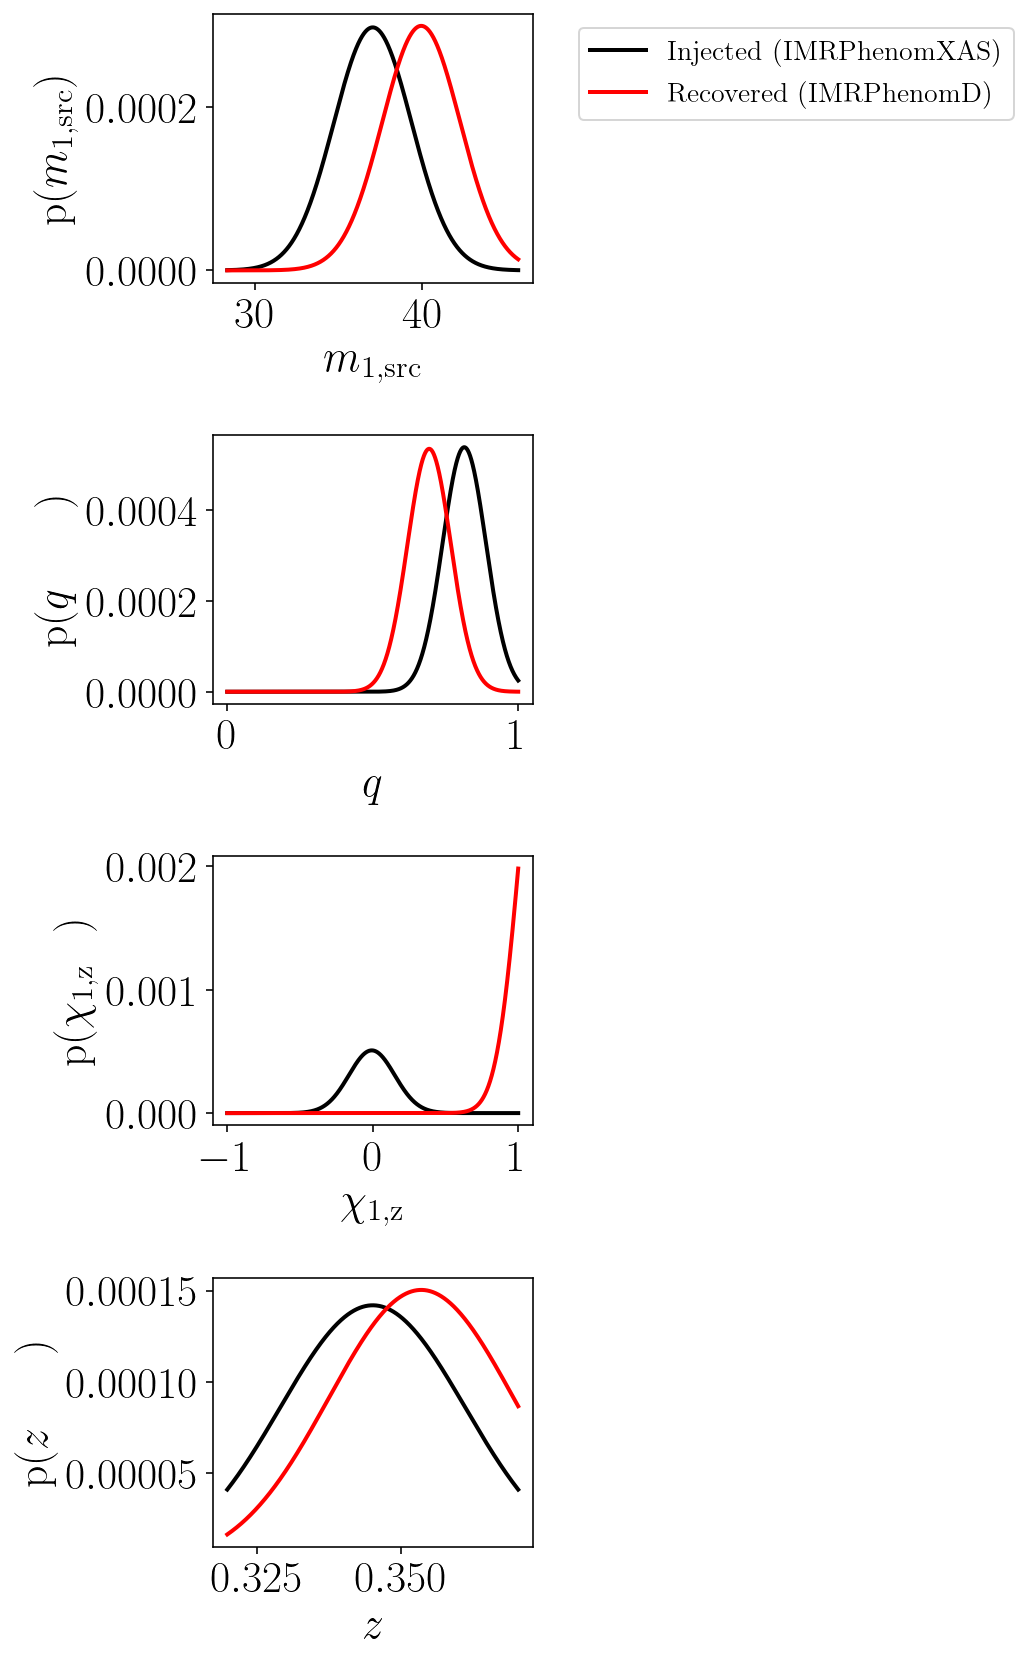

In [36]:
index = 54837
print(df[(df["index"]==index) & (df["hybr"]==0.0)].transpose().to_string())
# print("SNR: ", df[(df["index"]==index) & (df["hybr"]==0.0)]["snr"].values)


vars=['m1_src', 'q', 'chi1z', 'z']
# vars=['m1_src', 'm2_src', 'chi1z', 'z', 'DL', 'ra', 'dec', 'iota']
plot_bias(index=index, vars=vars ,labels=labels, hybr=0.0)#, hybr_2 = 0.96)

### Bias is above mass gap: 16687

In [37]:
mask = (df["hybr"]==0.0) & (df["snr"]>100) &  ((df["m1_src"]+df["m1_src_bias"])>60) & (df["m1_src"]<50) & (np.abs(df["m1_src_bias"]/df["m1_src_err"])>2) & (df["z_bias"]/df["z_err"] < 1)#(df["z"] + df["z_bias"] > 0.2) & (df["z"] < 4)
df[mask]

,index,Mc,eta,chi1x,chi2x,chi1y,chi2y,chi1z,chi2z,DL,...,m2_src_bias,m1_det,m2_det,m1_det_err,m2_det_err,m1_det_bias,m2_det_bias,q,q_err,q_bias
14660,14730,92.487138,0.237930,0.0,0.0,0.0,0.0,0.052691,-0.006268,12805.866802,...,2.938064,133.488596,85.394254,11.550907,2.395749,6.879323,-4.112860,0.639712,0.039160,-0.060652
7857,48538,117.878099,0.219871,0.0,0.0,0.0,0.0,0.119240,-0.170834,30585.822084,...,90.731241,197.023746,95.480338,32.745591,2.388487,-84.761315,16.782093,0.484613,0.030505,0.515387


                    14660
index        14730.000000
Mc              92.487138
eta              0.237930
chi1x            0.000000
chi2x            0.000000
chi1y            0.000000
chi2y            0.000000
chi1z            0.052691
chi2z           -0.006268
DL           12805.866802
tc               0.000000
phic             0.000000
iota             0.339845
ra               1.306549
dec             -0.717373
psi              5.742473
gmst0            0.000000
hybr             0.000000
Mc_err           0.239806
eta_err          0.004019
chi1z_err        0.239248
chi2z_err        0.377444
DL_err        3325.816000
tc_err           0.010069
phic_err         5.079508
iota_err         0.753936
ra_err           0.004719
dec_err          0.001559
psi_err          2.539361
Mc_bias         -0.182797
eta_bias        -0.005696
chi1z_bias       0.430528
chi2z_bias      -0.751967
DL_bias      -3148.776893
tc_bias         -0.018874
phic_bias        4.532866
iota_bias        0.697905
ra_bias     

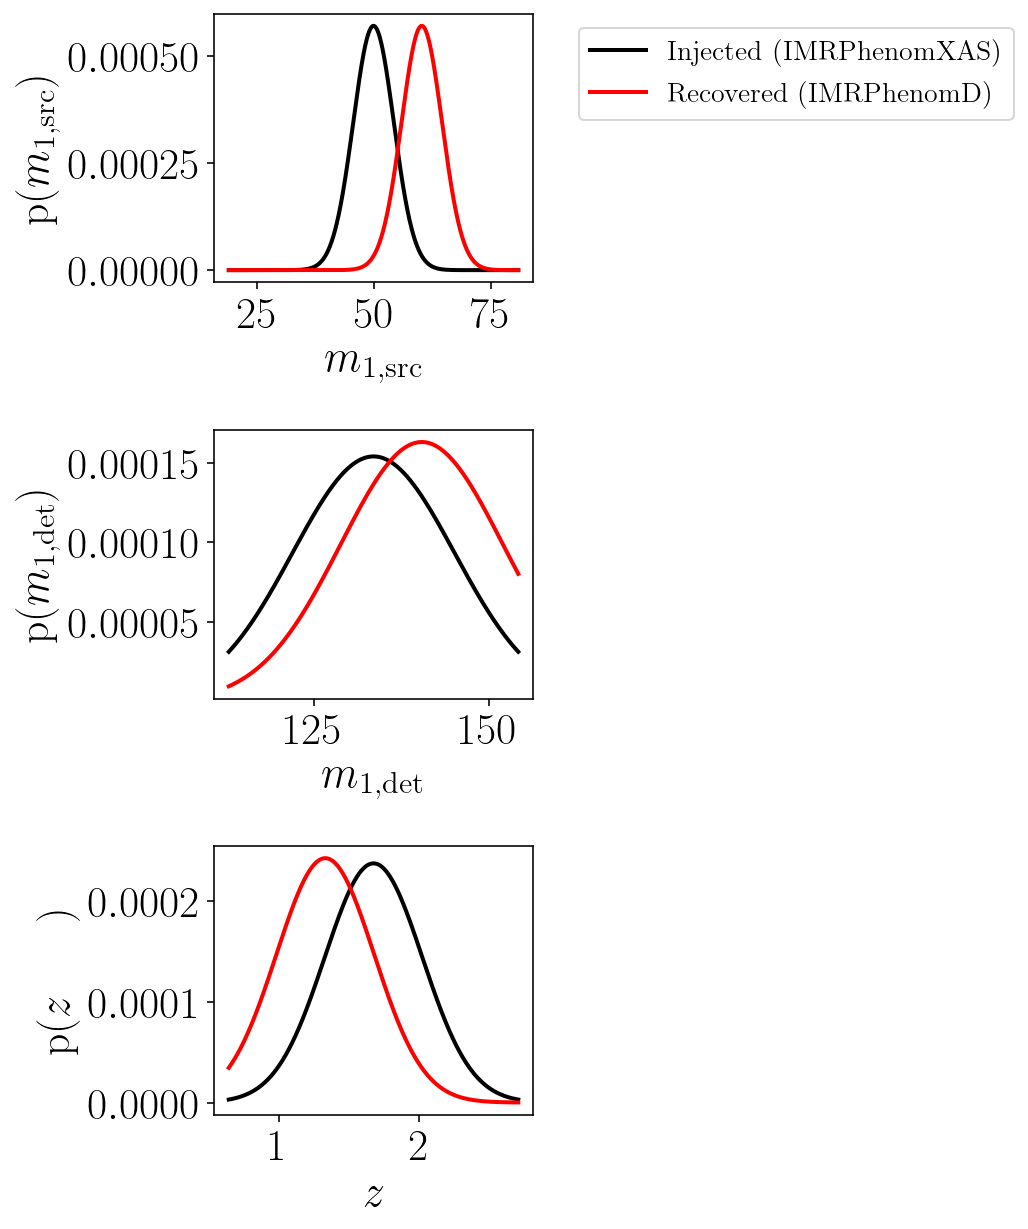

In [38]:
# index = 16687
# index = 49005
index = 14730

print(df[(df["index"]==index) & (df["hybr"]==0.0)].transpose().to_string())
print("SNR: ", df[(df["index"]==index) * (df["hybr"]==0.0)]["snr"].values)
df_index = df[(df["index"]==index)* (df["hybr"]==0.0)]
m1 = ((df_index["m1_src"]))
bias = ((df_index["m1_src_bias"]))
err = ((df_index["m1_src_err"]))
print(m1)
print(m1+bias)
print(bias/err)

vars=['m1_src', 'm1_det', 'z']
# # vars=['m1_src', 'm2_src', 'chi1z', 'z', 'DL', 'ra', 'dec', 'iota']
plot_bias(index=index, vars=vars ,labels=labels, hybr=0.0)


                    14660
index        14730.000000
Mc              92.487138
eta              0.237930
chi1x            0.000000
chi2x            0.000000
chi1y            0.000000
chi2y            0.000000
chi1z            0.052691
chi2z           -0.006268
DL           12805.866802
tc               0.000000
phic             0.000000
iota             0.339845
ra               1.306549
dec             -0.717373
psi              5.742473
gmst0            0.000000
hybr             0.000000
Mc_err           0.239806
eta_err          0.004019
chi1z_err        0.239248
chi2z_err        0.377444
DL_err        3325.816000
tc_err           0.010069
phic_err         5.079508
iota_err         0.753936
ra_err           0.004719
dec_err          0.001559
psi_err          2.539361
Mc_bias         -0.182797
eta_bias        -0.005696
chi1z_bias       0.430528
chi2z_bias      -0.751967
DL_bias      -3148.776893
tc_bias         -0.018874
phic_bias        4.532866
iota_bias        0.697905
ra_bias     

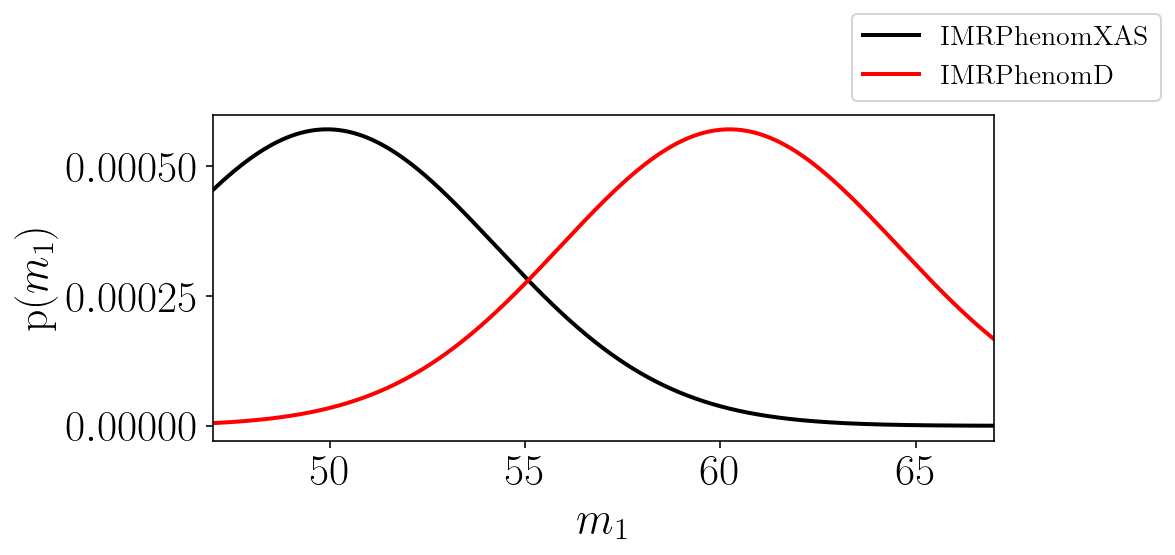

In [39]:
# index = 16687
index = 14730
print(df[(df["index"]==index) & (df["hybr"]==0.0)].transpose().to_string())

df_index = df[(df["index"]==index) & (df["hybr"]==0.0)]
mu = ((df_index["m1_src"]))
bias = ((df_index["m1_src_bias"]))
sigma = ((df_index["m1_src_err"]))

print(mu)
print(mu+bias)

fig, ax = plt.subplots(figsize=(7, 3))

x = np.linspace(mu-3*bias, mu+3*bias, 10000)
inj_est = stats.norm.pdf(x, mu, sigma)
inj_est = inj_est/np.sum(inj_est)

biased_est = stats.norm.pdf(x, mu+bias, sigma)
biased_est = biased_est/ np.sum(biased_est)

inj_est[x<0] = 0
biased_est[x<0] = 0

plt.plot(x, inj_est, label=f"IMRPhenomXAS", color='k', lw=2)
plt.plot(x, biased_est, label=f"IMRPhenomD",color='r', lw=2)

plt.xlim(47, 67)

plt.xlabel("$m_1$")
plt.ylabel("p$(m_1)$")

plt.legend(bbox_to_anchor=(0.8, 1), fontsize=14)

plt.show()

### Large, misaligned Spins ($m_1 \sim 6.5 M_\odot$, $q \sim 0.75$, $\chi_{1,z} \sim -0.6$, $\chi_{2,z} \sim 0.2$, z $\sim 0.2$ , SNR $\sim 170$): 88308

In [40]:
mask = (df["hybr"]==0.0) * ((df["chi1z"]/df["chi2z"]) < 0) * (np.abs(df["chi1z"]) > 0.5) * (df["snr"] > 100)
df[mask]

,index,Mc,eta,chi1x,chi2x,chi1y,chi2y,chi1z,chi2z,DL,...,m2_src_bias,m1_det,m2_det,m1_det_err,m2_det_err,m1_det_bias,m2_det_bias,q,q_err,q_bias
10223,10265,3.861517,0.241520,0.0,0.0,0.0,0.0,-0.530622,0.012536,130.905634,...,0.719143,5.362543,3.694490,0.159538,0.099315,-0.927243,0.740810,0.688944,0.038461,0.311056
6357,26573,8.686779,0.206617,0.0,0.0,0.0,0.0,-0.552783,0.025244,982.429409,...,1.747165,15.847784,6.527035,0.675805,0.196769,-2.384227,0.990061,0.411858,0.027168,0.146471
19862,81809,6.796047,0.249965,0.0,0.0,0.0,0.0,0.540684,-0.091326,3069.890885,...,-0.401910,7.899968,7.714568,0.407438,0.232521,0.206669,-0.194894,0.976532,0.057095,-0.048937
15602,98334,6.604596,0.249999,0.0,0.0,0.0,0.0,0.559473,-0.004161,454.593236,...,-0.081661,7.601469,7.571944,0.043427,0.039130,0.100885,-0.099089,0.996116,0.010204,-0.025912


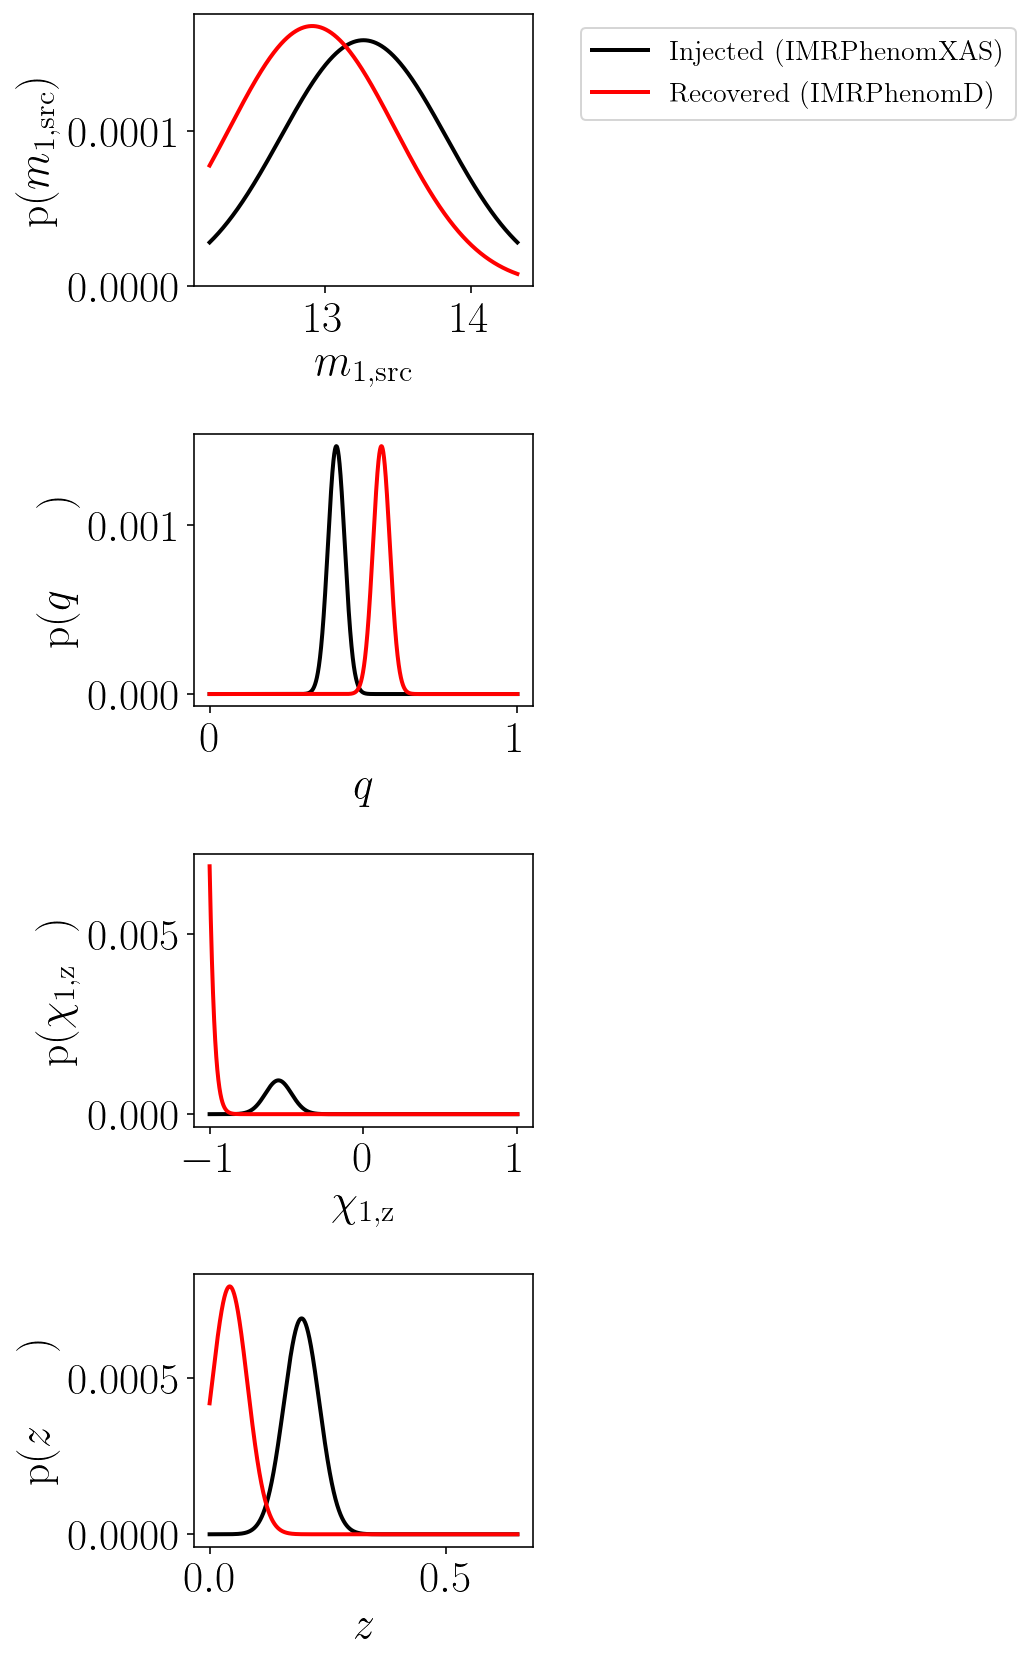

In [41]:
index = 26573
# print(df[(df["index"]==index) & (df["hybr"]==0.0)].transpose().to_string())
# print("SNR: ", df[(df["index"]==index) * (df["hybr"]==0.0)]["snr"].values)

vars=['m1_src', 'q', 'chi1z', 'z']
# vars=['m1_src', 'm2_src', 'chi1z', 'z', 'DL', 'ra', 'dec', 'iota']
plot_bias(index=index, vars=vars ,labels=labels, hybr=0.0)

In [42]:
mask = (df["hybr"]==0.0) * (np.abs(df["m1_src"])>40) * (np.abs(df["m2_src"])>40) * (df["z"] < 1.0)
df[mask]

,index,Mc,eta,chi1x,chi2x,chi1y,chi2y,chi1z,chi2z,DL,...,m2_src_bias,m1_det,m2_det,m1_det_err,m2_det_err,m1_det_bias,m2_det_bias,q,q_err,q_bias
4520,4530,77.866412,0.246395,0.0,0.0,0.0,0.0,0.066716,0.088726,6194.468899,...,-1.542028,101.062209,79.393517,9.340440,3.540016,6.876298,-4.918757,0.785591,0.071999,-0.095617
8387,69819,68.503066,0.247566,0.0,0.0,0.0,0.0,-0.004625,0.000305,4551.510201,...,-3.309801,86.962568,71.342682,7.100820,3.191615,7.794039,-5.723701,0.820384,0.073617,-0.127883
11263,72819,76.385828,0.249495,0.0,0.0,0.0,0.0,0.077219,-0.199096,3802.796745,...,-5.066033,91.797482,83.903929,11.389608,5.229279,10.424813,-8.461987,0.914011,0.107805,-0.175993
17340,79170,47.527595,0.248222,0.0,0.0,0.0,0.0,0.229195,0.152711,1108.390612,...,-0.193674,59.452667,50.205604,3.114192,2.087929,0.277210,-0.275567,0.844463,0.071531,-0.008533


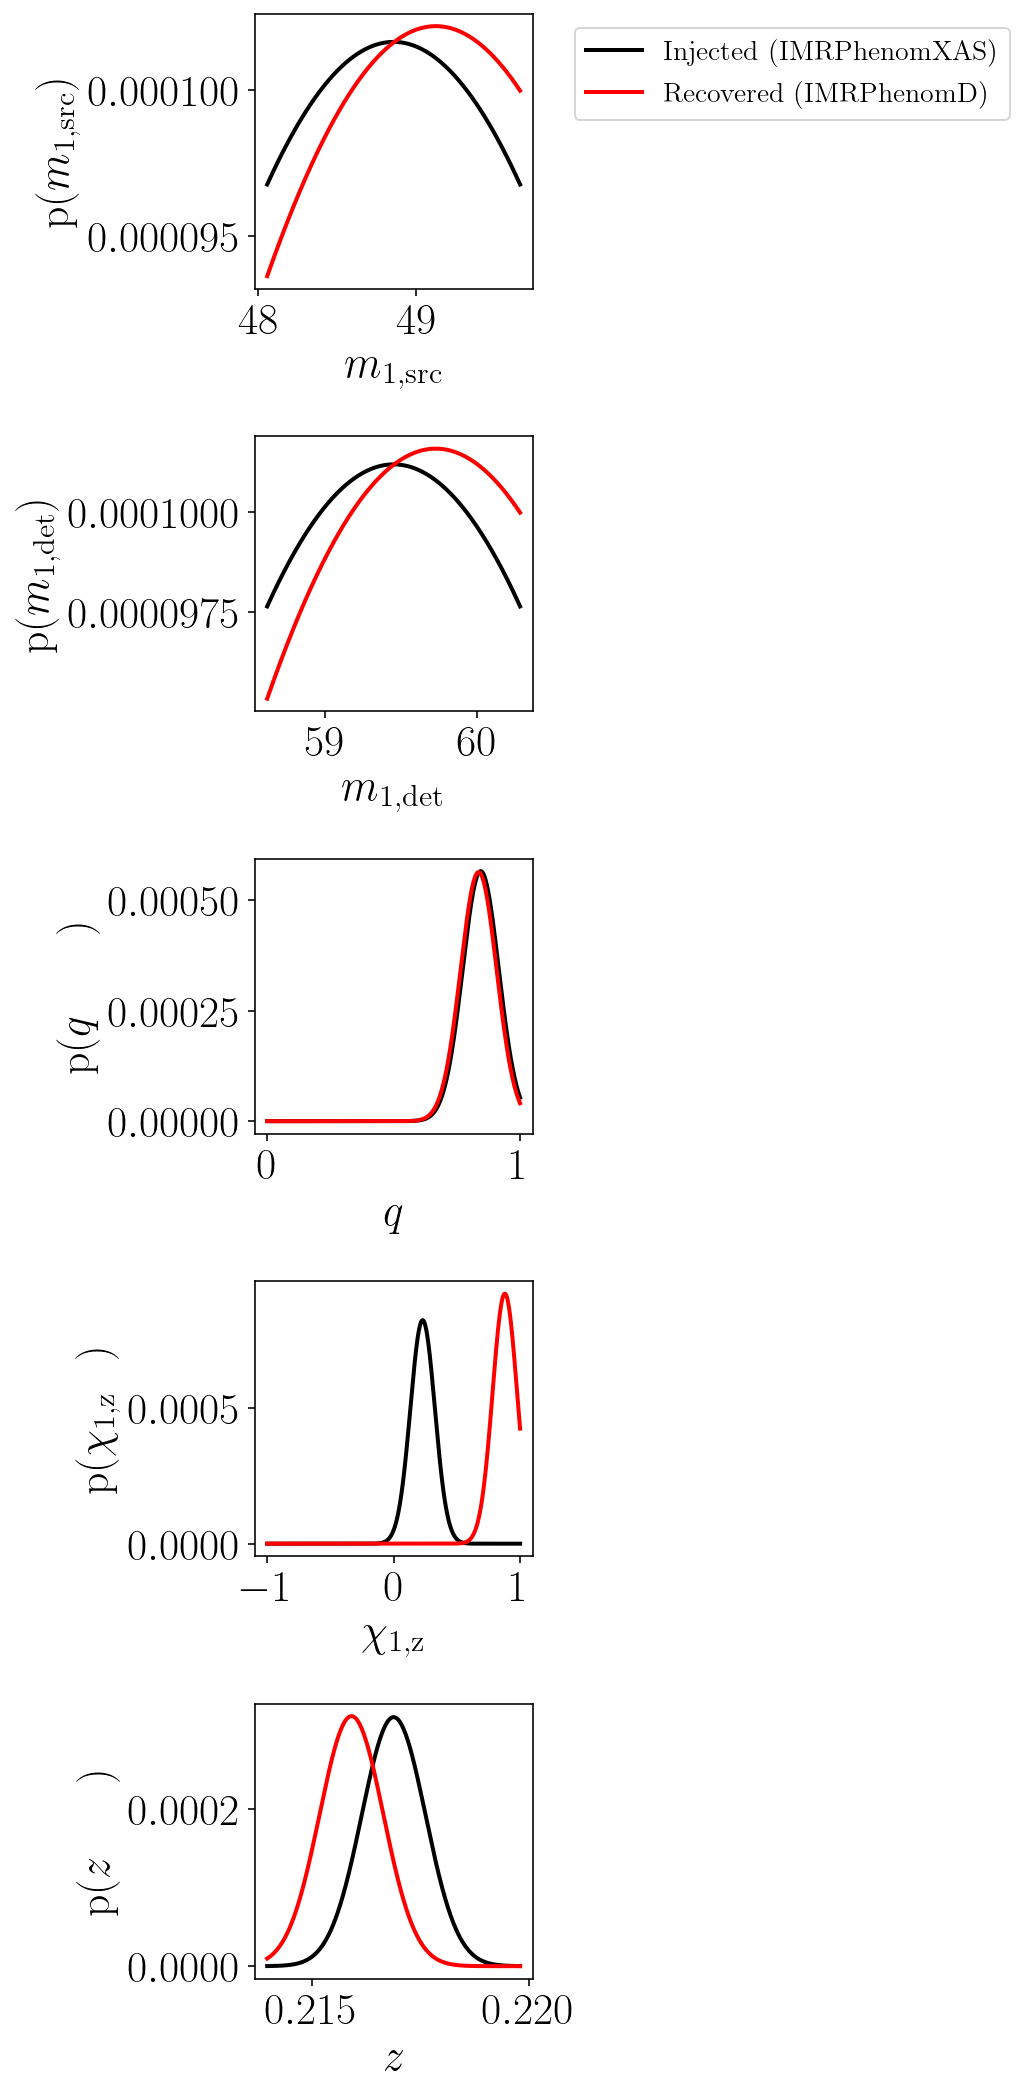

In [43]:
index = 79170
# print(df[(df["index"]==index) * (df["hybr"]==0.0)].transpose().to_string())
# print("SNR: ", df[(df["index"]==index) * (df["hybr"]==0.0)]["snr"].values)

vars=['m1_src', 'm1_det', 'q', 'chi1z', 'z']
# vars=['m1_src', 'm2_src', 'chi1z', 'z', 'DL', 'ra', 'dec', 'iota']
plot_bias(index=index, vars=vars ,labels=labels, hybr=0.0)

# CV Bias Validity Check

Median Mc relative bias = 1.639e-04
Median Mc relative bias (SNR>100) = 4.434e-05
Median Mc relative bias (SNR>200) = 2.842e-05
Median Mc relative bias (SNR>300) = 2.584e-05


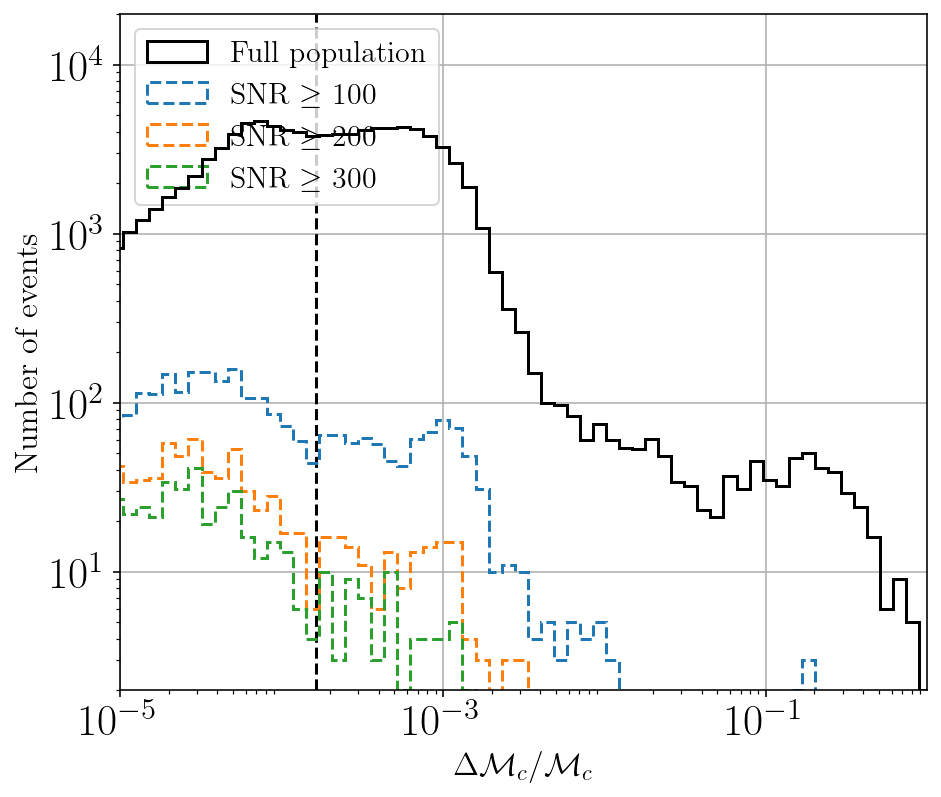

In [44]:
snrs = [100, 200, 300]

fig, ax = plt.subplots(figsize=(7,6))


data = df[(df["hybr"]==0.0) & (df["snr"]>0)]
bins = np.geomspace(1e-7, 10.0, 100)
bias_ratio = np.abs(data["Mc_bias"]/data["Mc"])

plt.hist(bias_ratio, bins=bins, label="Full population", color='k', lw=1.5, histtype='step', zorder=20)
plt.axvline(x = np.median(bias_ratio), ls='--', color='k')
print(f"Median Mc relative bias = {np.median(bias_ratio):.3e}")

for snr in snrs:
    data = df[(df["hybr"]==0.0) & (df["snr"]>snr)]
    bins = np.geomspace(1e-7, 10.0, 100)
    bias_ratio = np.abs(data["Mc_bias"]/data["Mc"])
    plt.hist(bias_ratio, bins=bins, label=f"SNR $\geq$ {snr}", lw=1.5, ls='--', histtype='step')
    print(f"Median Mc relative bias (SNR>{snr:.0f}) = {np.median(bias_ratio):.3e}")

plt.loglog()
plt.xlim(1e-5, 1.0)
plt.ylim(2, 2e4)
plt.legend(fontsize=15, loc='upper left')
plt.grid()

plt.xlabel("$\Delta \mathcal{M}_c /  \mathcal{M}_c$", fontsize=16)
plt.ylabel("Number of events", fontsize=16)

ax.xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))

plt.tight_layout()
plt.show()

Median eta relative bias = 1.704e-02
Median eta relative bias (SNR>100) = 0.01582
Median eta relative bias (SNR>200) = 0.01425
Median eta relative bias (SNR>300) = 0.01410


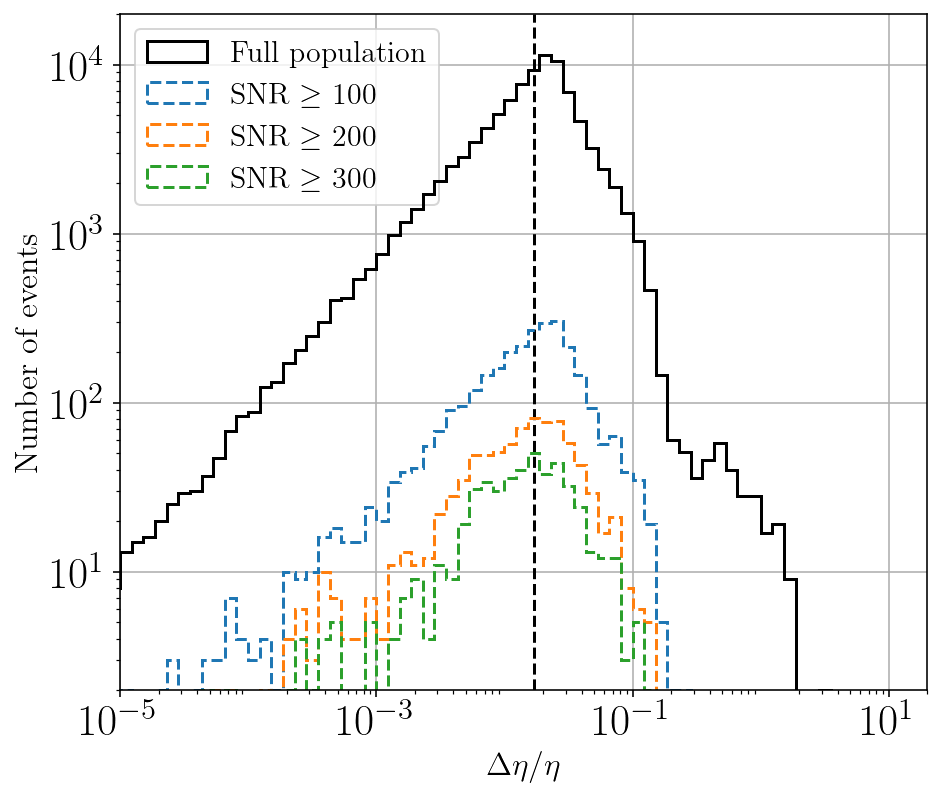

In [45]:
snrs = [100, 200, 300]

fig, ax = plt.subplots(figsize=(7,6))


data = df[(df["hybr"]==0.0) & (df["snr"]>0)]
bins = np.geomspace(1e-7, 100.0, 100)
bias_ratio = np.abs(data["eta_bias"]/data["eta"])

plt.hist(bias_ratio, bins=bins, label="Full population", color='k', lw=1.5, histtype='step', zorder=20)
plt.axvline(x = np.median(bias_ratio), ls='--', color='k')
print(f"Median eta relative bias = {np.median(bias_ratio):.3e}")

for snr in snrs:
    data = df[(df["hybr"]==0.0) & (df["snr"]>snr)]
    bias_ratio = np.abs(data["eta_bias"]/data["eta"])
    plt.hist(bias_ratio, bins=bins, label=f"SNR $\geq$ {snr}", lw=1.5, ls='--', histtype='step')
    print(f"Median eta relative bias (SNR>{snr:.0f}) = {np.median(bias_ratio):.5f}")

plt.loglog()
plt.xlim(1e-5, 20.0)
plt.ylim(2, 2e4)
plt.legend(fontsize=15, loc='upper left')
plt.grid()

plt.xlabel("$\Delta \eta / \eta$", fontsize=16)
plt.ylabel("Number of events", fontsize=16)
ax.xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))

plt.tight_layout()
plt.show()

In [46]:
print("Mc relative bias range:", np.geomspace(1e-4, 1e-1, 5))
print("eta relative bias range:", np.geomspace(1e-3, 0.5, 5))

Mc relative bias range: [0.0001     0.00056234 0.00316228 0.01778279 0.1       ]
eta relative bias range: [0.001      0.00472871 0.02236068 0.10573713 0.5       ]


In [47]:
mask = (df["hybr"]==0.0)  & (np.abs(df["m1_src"])<10.0) & (df["eta"]>0.249) & (np.abs(df["chi1z"])<0.1) & (np.abs(df["chi2z"])<0.1) & (df["snr"]>100)
mask = mask & (np.abs(df["Mc_bias"]/df["Mc"])<0.0001) & (np.abs(df["Mc_bias"]/df["Mc"])>0.00005)
mask = mask & (np.abs(df["eta_bias"]/df["eta"])<0.01) & (np.abs(df["eta_bias"]/df["eta"])>0.005)
df[mask]

# print(df[mask]["eta_bias"]/df[mask]["eta"])

,index,Mc,eta,chi1x,chi2x,chi1y,chi2y,chi1z,chi2z,DL,...,m2_src_bias,m1_det,m2_det,m1_det_err,m2_det_err,m1_det_bias,m2_det_bias,q,q_err,q_bias



index = 47519 "Pessimistic"
Mc Relative Bias = 0.01622597920329299
Mc Bias sigma = 114.5988097062462
eta Relative Bias = 1.227591946077229
eta Bias sigma = 89.63674109631741
snr 344.162282237939


index = 21985 "Typical binary"
Mc Relative Bias = -0.0007167022886414568
Mc Bias sigma = -3.0696657260069653
eta Relative Bias = 0.21933080960302506
eta Bias sigma = 2.123804372963759
snr 107.13642486058056

index = 78736 "Optimistic"
Mc Relative Bias = -7.957984624074578e-05
Mc Bias sigma = -2.8464016102580447
eta Relative Bias = 0.005358660470512126
eta Bias sigma = 0.3129888102913468
snr 315.6506765004311

In [ ]:
# PE results for 'Pessimistic' Binary (in units of \sigma)
pe_bias_pessimistic = {
    'Mc':    4.52412,
    'eta':   3.63709,
    'chi1x': 0.,
    'chi2x': 0.,
    'chi1y': 0.,
    'chi2y': 0.,
    'chi1z': -11.32144,
    'chi2z': 9.298680,
    'DL':    0.387292,
    'tc':    0,
    'phic':  -2.37615,
    'iota':  -0.22528,
    'ra':    -0.62761,
    'dec':   0.38729,
    'psi':   0.020161
}

Mc Relative Bias = -0.0007034392888446546
Mc Bias sigma = -4.968162734107634
eta Relative Bias = -0.018111618984100755
eta Bias sigma = -1.3224805741849113
chi1z Relative Bias = 197.2761874279248
chi1z Bias sigma = 3.6541799184895356
chi2z Relative Bias = -417.3674680454497
chi2z Bias sigma = -3.6558539075056364
DL Relative Bias = 0.005562832536717432
DL Bias sigma = 0.25377733563984917
snr 344.162282237939


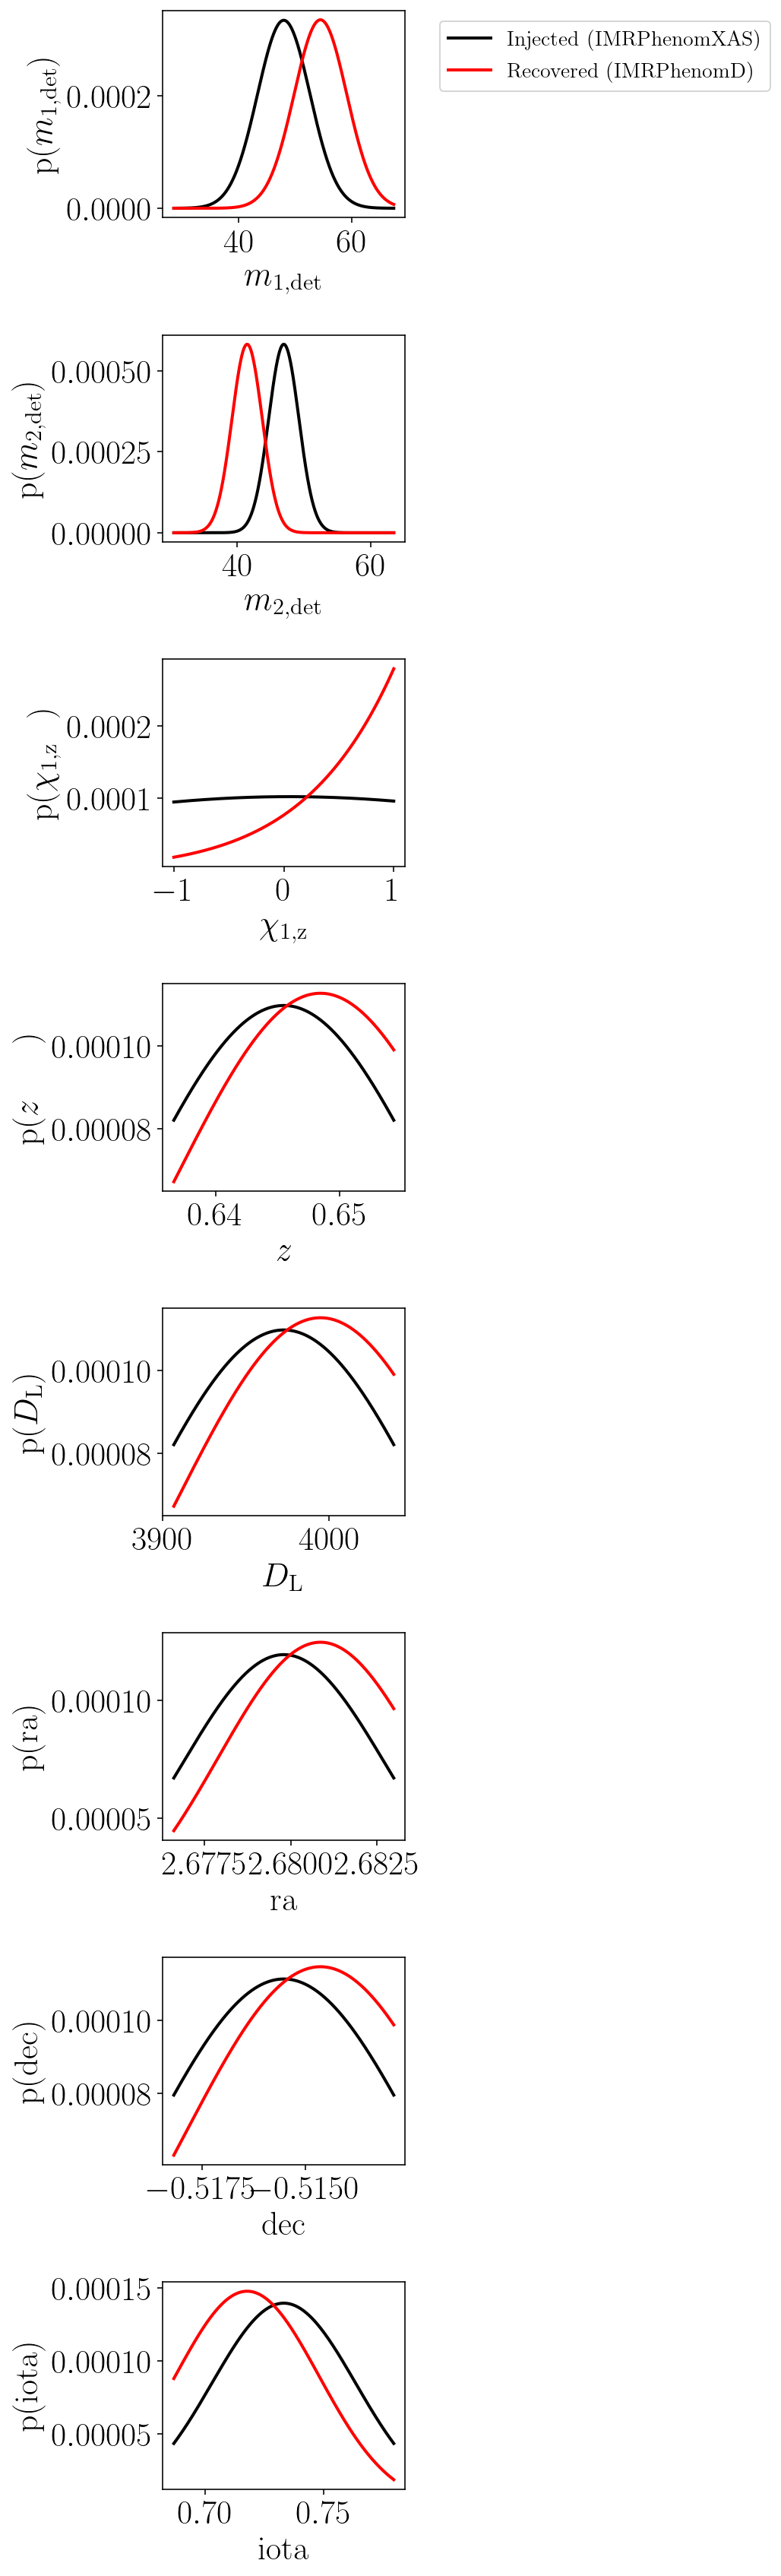

In [48]:
index = 47519 # Pessimistic binary

df_index = df[(df["index"]==index) & (df["hybr"]==0.0)]
for param in ["Mc", "eta", "chi1z", "chi2z", "DL"]:
    param_value = float(df_index[param])
    param_bias = float(df_index[f"{param}_bias"])
    param_err = float(df_index[f"{param}_err"])
    print(param+" Relative Bias =", param_bias/param_value)
    print(param+" Bias sigma =", param_bias/param_err)


print("snr", float(df_index["snr"]))

# vars=['Mc', 'eta', 'chi1z', 'DL']
vars=['m1_det', 'm2_det', 'chi1z', 'z', 'DL', 'ra', 'dec', 'iota']
plot_bias(index=index, vars=vars ,labels=labels, hybr=0.0)

# q-chieff correlation test

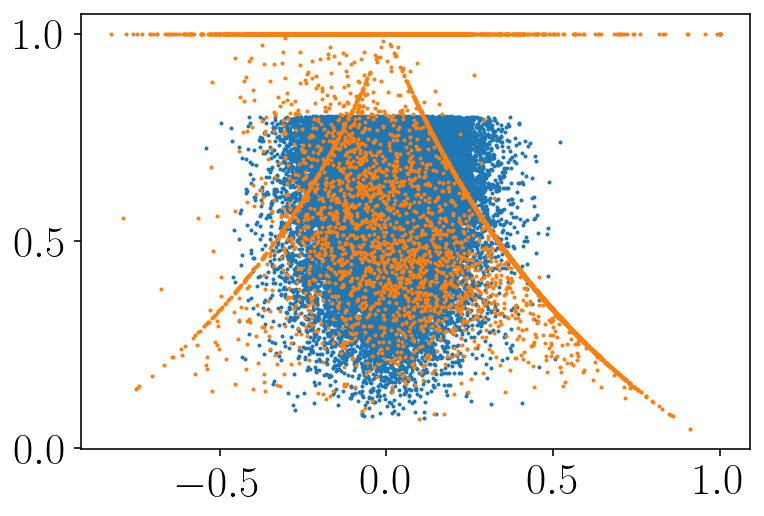

In [78]:
data = df[(df["hybr"]==0.0) & (df["snr"]>10) & (df["q"]<0.8)]
plt.scatter(data["chi_eff"], data["q"], s=1)

plt.scatter(data["chi_eff"]+data["chi_eff_bias"], data["q"]+data["q_bias"], s=1)
plt.show()

(0.0, 400000.0)

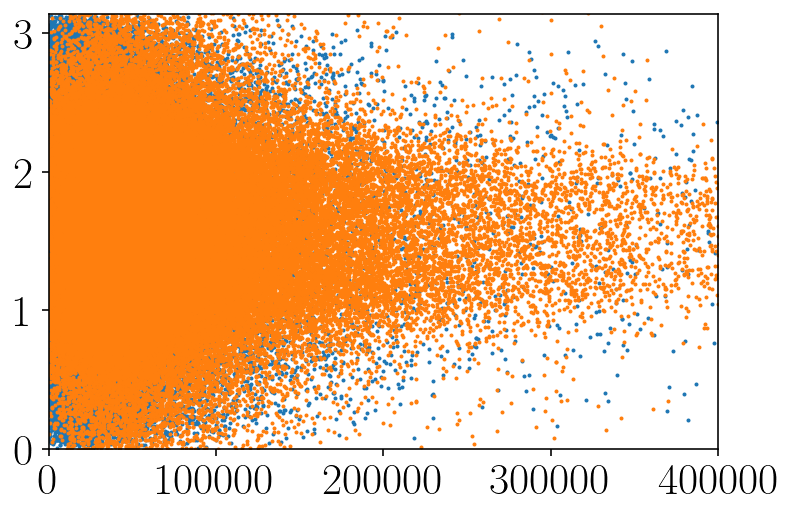

In [79]:
data = df[df["hybr"]==0.0]
plt.scatter(data["DL"], data["iota"], s=1)

plt.scatter(data["DL"]+data["DL_bias"], data["iota"]+data["iota_bias"], s=1)

plt.ylim(0, np.pi)
plt.xlim(0, 400000)